# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2  
%autosave 10

Autosaving every 10 seconds


In [2]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from PIL import Image
import random, os, sys, argparse
from pathlib import Path
from tqdm import tqdm
import pickle

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import shap

In [3]:
sys.path.insert(0,'/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/toy_expts/')
from models import *

# User Hyperparams

In [4]:
'''
vgg16_kmnist_27437
vgg16_kmnist_patch_48316
vgg16_mnist_75872
vgg16_mnist_patch_42954
vgg16_cifar10_29954
'''

'\nvgg16_kmnist_27437\nvgg16_kmnist_patch_48316\nvgg16_mnist_75872\nvgg16_mnist_patch_42954\nvgg16_cifar10_29954\n'

In [33]:
model = 'vgg16' # resnet18, vgg16, densenet121, mlp
dataset = 'kmnist' # mnist,kmnist
add_patch_flag = False
num_classes = 10   
data_csv = None
expt_name = f'vgg16_kmnist_{int(random.random()*100000)}'
save_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/toy_expts/output/'

num_epochs = 3
lr = 0.1
seed = 0
num_ch = 1 # num of channels in image
num_embs = 1000 # 1500 for mnist, 10k for cifar10
K = 29 # K neighbours
num_test_imgs = 50 # num of test images for plotting PD
lp_norm = 1 # for computing KNN
knn_pos_thresh = 0.5
knn_neg_thresh = 0.5

# Util Functions

In [34]:
# takes in a list of img paths and plots grid of images
def plot_images(img_list, rows, cols, titles=None):
    plt.figure(figsize=(7.5*cols,7.5*rows))
    for i in range(rows*cols):
        plt.subplot(rows,cols,i+1)
        if type(img_list[0])==str:
            img = plt.imread(img_list[i])
        else:
            img = img_list[i]
        plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
    plt.show()

# Load Dataset

In [35]:
# Setting the seed
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [36]:
# datasets
print('==> Preparing data..')
if dataset=='mnist':
    # transformations
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.ToTensor(),
                # torchvision.transforms.Lambda(lambda x: x.repeat(3,1,1))
            ])  # for mnist and fmnist we replicate channels

    root_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/'
    trainset = torchvision.datasets.MNIST(root_dir, transform=trans, download=True)
    testset = torchvision.datasets.MNIST(root_dir, train=False, transform=trans, download=True)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)
elif dataset=='fmnist':
    # transformations
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.ToTensor(),
#                 torchvision.transforms.Lambda(lambda x: x.repeat(3,1,1))
            ])  # for mnist and fmnist we replicate channels

    root_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/'
    trainset = torchvision.datasets.FashionMNIST(root_dir, transform=trans, download=True)
    testset = torchvision.datasets.FashionMNIST(root_dir, train=False, transform=trans, download=True)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)
elif dataset=='kmnist':
    # transformations
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.ToTensor(),
#                 torchvision.transforms.Lambda(lambda x: x.repeat(3,1,1))
            ])  # for mnist and fmnist we replicate channels

    root_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/'
    trainset = torchvision.datasets.KMNIST(root_dir, transform=trans, download=True)
    testset = torchvision.datasets.KMNIST(root_dir, train=False, transform=trans, download=True)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=True, num_workers=2)
elif dataset=='svhn':
    # transformations
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.Grayscale(num_output_channels=1),
                torchvision.transforms.ToTensor(),
            ])  # for mnist and fmnist we replicate channels

    root_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/svhn_gray/'
    trainset = torchvision.datasets.SVHN(root_dir, split='train', transform=trans, download=True)
    testset = torchvision.datasets.SVHN(root_dir, split='test', transform=trans, download=True)
    
    trainset.targets = trainset.labels
    testset.targets = testset.labels
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)
elif dataset=='cifar10':
    # transformations
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.Grayscale(num_output_channels=1),
                torchvision.transforms.ToTensor(),
#                 torchvision.transforms.Normalize(mean=[0.4914,0.4822,0.4465],std=[0.2470,0.2435,0.2616]),
                torchvision.transforms.Normalize(mean=0.4914,std=0.2470)
            ])  # for mnist and fmnist we replicate channels

    root_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/'
    trainset = torchvision.datasets.CIFAR10(root_dir, transform=trans, download=True)
    testset = torchvision.datasets.CIFAR10(root_dir, train=False, transform=trans, download=True)
    
#     # use only 2 classes
#     arr = (np.array(trainset.targets)==0) | (np.array(trainset.targets)==1)
#     trainset.data = trainset.data[arr]
#     trainset.targets = np.array(trainset.targets)[arr]
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=500, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)

==> Preparing data..


In [37]:
dir(trainset.data)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ifloordiv__',
 '__ilshift__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '

In [38]:
# for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
#     break
    

In [39]:
# add patch shortcut
def add_patch(img,lab):
    mid = img.shape[0]//2
    mid_x = mid-2
    mid_y = mid+3    
    if lab==0:
        img[:4,:4] = 255
    elif lab==1:
        img[:4,-4:] = 255
    elif lab==2:
        img[-4:,:4] = 255
    elif lab==3:
        img[-4:,-4:] = 255
    elif lab==4:
        img[mid_x:mid_y,mid_x:mid_y] = 255
    elif lab==5: 
        img[:4,12:16] = 255
    elif lab==6:  
        img[-4:,12:16] = 255
    elif lab==7:
        img[12:16,:4] = 255
    elif lab==8:    
        img[12:16,-4:] = 255        
    return img

if add_patch_flag:    
    for (img,lab) in zip(trainset.data,trainset.targets):
        img = add_patch(img,lab)        
    for (img,lab) in zip(testset.data,testset.targets):
        img = add_patch(img,lab)

# GradCam Viz

In [126]:
# # SHAP on intermediate soft-KNN outputs
# # user hyperparams
# expt_name = 'vgg16_kmnist_patch_48316'
# layer_id = 3 # vgg layer to viz net.module.features[layer_id]
#                # 0,3,7,10,14,17,20,24,27,30,34,37,40
# train_emb_idx = 1 # info_dict['feats'][train_emb_idx]
#               # 0,1,2,3,4,5,6,7,8,9,10,11,12

# # load model
# train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')
# net = nn.DataParallel(customVGG2('VGG16', train_embs_pkl_path, layer_id, train_emb_idx, num_channels=1))
# net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
# net.eval()

# # load batch of images
# batch = next(iter(testloader))
# images, _ = batch

# # prepare shap train and test images
# shap_train_imgs = images[:50].to('cuda')
# shap_test_imgs = images[490:].to('cuda')

# e = shap.DeepExplainer(net, shap_train_imgs)
# shap_values = e.shap_values(shap_test_imgs)

# shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
# test_numpy = np.swapaxes(np.swapaxes(shap_test_imgs.cpu().numpy(), 1, -1), 1, 2)
# shap.image_plot(shap_numpy, -test_numpy, width=100.0)

In [127]:
# GradCAM on intermediate soft-KNN outputs
# user hyperparams
expt_name = 'vgg16_kmnist_patch_84442'
layer_id = 0 # vgg layer to viz net.module.features[layer_id]
               # 0,3,7,10,14,17,20,24,27,30,34,37,40
train_emb_idx = 0 # info_dict['feats'][train_emb_idx]
              # 0,1,2,3,4,5,6,7,8,9,10,11,12

# load model
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')
net = nn.DataParallel(customVGG2('VGG16', train_embs_pkl_path, layer_id, train_emb_idx, num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

# loop over test images
for _ in range(25):
    img_id = int(random.random()*len(trainset.data))
    img = trainset.data[img_id]
    
    # pre-process the img to make it compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img_tensor = to_pil_trans(img.squeeze().to('cuda'))
    else:
        img_tensor = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img_tensor = trans(img_tensor).unsqueeze(0)
    if img_tensor.shape[1]==4:
        img_tensor = img_tensor[:,0,:,:].unsqueeze(0)
        
    img_rgb = img_tensor.squeeze().unsqueeze(-1).expand(32,32,3)

    # gradCAM code
    targets = [ClassifierOutputTarget(0)]
    target_layers = [net.module.features[layer_id]]

    cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)
    grayscale_cams = cam(input_tensor=img_tensor, targets=targets, aug_smooth=False, eigen_smooth=False)
    cam_op = show_cam_on_image(np.array(img_rgb)*0.35, (grayscale_cams[0]>0.8).astype(float)*20, use_rgb=True)
    
    img_list = []
    img_list.append(img_rgb)
    img_list.append(grayscale_cams[0])
    img_list.append((grayscale_cams[0]>0.8).astype(float))
    img_list.append(cam_op)

    # plot results
    plot_images(img_list,rows=1,cols=4,titles=[f'Img Id: {img_id}','Heatmap','Thresholded Heatmap','Overlay'])

FileNotFoundError: [Errno 2] No such file or directory: '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/toy_expts/output/vgg16_kmnist_patch_84442.pkl'

In [ ]:
cam_op.shape, img_rgb.shape, grayscale_cams[0].shape

### Save Figs to Folder

In [ ]:
img_id = 45456# 45456 , 50547
img = trainset.data[img_id]

# pre-process the img to make it compatible for forward pass
to_pil_trans = transforms.ToPILImage()
if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    img_tensor = to_pil_trans(img.squeeze().to('cuda'))
else:
    img_tensor = to_pil_trans(img.permute(2,0,1).to('cuda'))
img_tensor = trans(img_tensor).unsqueeze(0)
if img_tensor.shape[1]==4:
    img_tensor = img_tensor[:,0,:,:].unsqueeze(0)

img_rgb = img_tensor.squeeze().unsqueeze(-1).expand(32,32,3)

# gradCAM code
targets = [ClassifierOutputTarget(0)]
target_layers = [net.module.features[layer_id]]

cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)
grayscale_cams = cam(input_tensor=img_tensor, targets=targets, aug_smooth=False, eigen_smooth=False)
cam_op = show_cam_on_image(np.array(img_rgb)*0.35, (grayscale_cams[0]>0.8).astype(float)*20, use_rgb=True)

img_list = []
img_list.append(img_rgb)
img_list.append(grayscale_cams[0])
img_list.append((grayscale_cams[0]>0.8).astype(float))
img_list.append(cam_op)

# plot results
plot_images(img_list,rows=1,cols=4,titles=['Original Img','Heatmap','Thresholded Heatmap','Overlay'])

In [ ]:
plt.axis('off') 
plt.imshow(cam_op)
plt.imsave('/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/paper_quality_plots/results/kmnist_patch_2b.svg',cam_op)

In [ ]:
plt.axis('off') 
plt.imshow(img_rgb)
plt.imsave('/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/paper_quality_plots/results/kmnist_patch_2a.svg',img_rgb)

# Train Model

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy

# Model
print('==> Building model..')
if model=='resnet18':
    # net = VGG('VGG19')
    net = ResNet18(num_channels=num_ch)
    # net = PreActResNet18()
    # net = GoogLeNet()
    # net = DenseNet121()
    # net = ResNeXt29_2x64d()
    # net = MobileNet()
    # net = MobileNetV2()
    # net = DPN92()
    # net = ShuffleNetG2()
    # net = SENet18()
    # net = ShuffleNetV2(1)
    # net = EfficientNetB0()
    # net = RegNetX_200MF()
    # net = SimpleDLA()
elif model=='vgg16':
    net = VGG('VGG16',num_channels=num_ch)
elif model=='densenet121':
    net = DenseNet121()
elif model=='mlp':
    net = nn.Sequential(torch.nn.Linear(1024, 10))
net = net.to(device)
    
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        if model=='mlp':
            outputs = net(inputs.reshape((inputs.shape[0],-1)))
        else:
            outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            if model=='mlp':
                outputs = net(inputs.reshape((inputs.shape[0],-1)))
            else:
                outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
#         if not os.path.isdir(f'{args['expt_name']}_checkpoint'):
#             os.mkdir('checkpoint')
        torch.save(state, os.path.join(save_dir,f'{expt_name}.pt'))
        best_acc = acc


for epoch in range(num_epochs):
    train(epoch)
    test(epoch)
    scheduler.step()

==> Building model..

Epoch: 0


100%|██████████| 469/469 [00:09<00:00, 47.05it/s]


468 469 Loss: 2.128 | Acc: 23.630% (14178/60000)


100%|██████████| 20/20 [00:00<00:00, 23.88it/s]


19 20 Loss: 2.060 | Acc: 25.670% (2567/10000)
Saving..

Epoch: 1


100%|██████████| 469/469 [00:09<00:00, 47.17it/s]


468 469 Loss: 0.775 | Acc: 72.822% (43693/60000)


100%|██████████| 20/20 [00:00<00:00, 23.91it/s]


19 20 Loss: 0.700 | Acc: 79.000% (7900/10000)
Saving..

Epoch: 2


100%|██████████| 469/469 [00:10<00:00, 46.70it/s]


468 469 Loss: 0.140 | Acc: 95.988% (57593/60000)


100%|██████████| 20/20 [00:00<00:00, 21.88it/s]


19 20 Loss: 0.440 | Acc: 87.920% (8792/10000)
Saving..


## Train Ensemble MLP models

In [ ]:
type = 'conv' # conv, linear

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding="same"),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*32*32, 10),
            #nn.Softmax(dim=1)            
        )

    def forward(self, x_batch):
        preds = self.seq(x_batch)
        return preds

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
nets = []

# Model
print('==> Building model..')
for _ in range(5):
    if type=='linear':
        net = nn.Sequential(
            Flatten(),
            torch.nn.Linear(1024, 10)
        )
    else:
        net = ConvNet()
    net.to(device)
    net = torch.nn.DataParallel(net)
    nets.append(net)

cudnn.benchmark = True

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        if model=='mlp':
#             outputs = net(inputs.reshape((inputs.shape[0],-1)))
            outputs = net(inputs)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            if model=='mlp':
#                 outputs = net(inputs.reshape((inputs.shape[0],-1)))
                outputs = net(inputs)
            else:
                outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
#         if not os.path.isdir(f'{args['expt_name']}_checkpoint'):
#             os.mkdir('checkpoint')
        torch.save(state, os.path.join(save_dir,f'{expt_name}.pt'))
        best_acc = acc

for model_id in range(5):
    net = nets[model_id]
        
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr,
                          momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    for epoch in range(5):
        train(epoch)
        test(epoch)
        scheduler.step()

## Obtaining Uncertainties for MLP model

In [291]:
outputs = []
for model_id in tqdm(range(5)):
    net = nets[model_id]
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
#             output = net(inputs.reshape((inputs.shape[0],-1)))
            output = net(inputs)
            break
    output = torch.softmax(output,1) # compute probs
    outputs.append(output)

100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


0.5175638


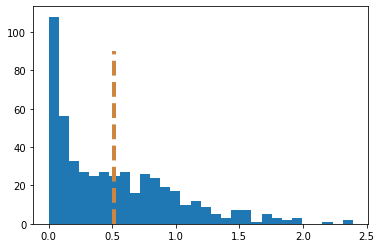

In [292]:
# entr type 1
entrs = []
se_sum = 0
for probs in outputs:
    se = (-probs*torch.log(probs)/torch.log(torch.tensor(2))).sum(1)
    se_sum = se_sum + se
entr1 = se_sum/len(outputs)
entr1 = entr1.detach().cpu().numpy()
plt.vlines(entr1.mean(),0,90,color='peru',linestyle='dashed',linewidth=4)
plt.hist(entr1,bins=30)
print(entr1.mean())

1.5937936

(array([  1.,   0.,   0.,   3.,   0.,   1.,   0.,   0.,   1.,   0.,  19.,
         10.,  15.,  21.,   3.,   4.,   3.,   2.,   1., 120.,  90.,  23.,
         15.,  13.,   7.,   0.,  98.,  28.,  17.,   5.]),
 array([0.78206265, 0.84074444, 0.8994263 , 0.95810807, 1.0167899 ,
        1.0754716 , 1.1341535 , 1.1928352 , 1.251517  , 1.3101989 ,
        1.3688806 , 1.4275625 , 1.4862443 , 1.544926  , 1.6036079 ,
        1.6622896 , 1.7209715 , 1.7796533 , 1.838335  , 1.8970169 ,
        1.9556987 , 2.0143805 , 2.0730622 , 2.1317441 , 2.1904259 ,
        2.2491076 , 2.3077896 , 2.3664713 , 2.425153  , 2.483835  ,
        2.5425167 ], dtype=float32),
 <BarContainer object of 30 artists>)

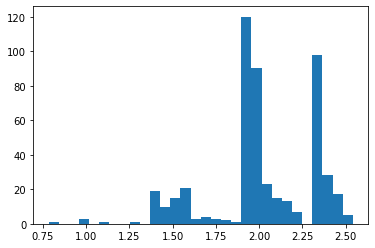

In [146]:
# pred entropy
probs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/5
pe = (-probs*torch.log(probs)/torch.log(torch.tensor(2))).sum(1)
pe = pe.detach().cpu().numpy()
plt.hist(pe,bins=30)

In [294]:
# np.save('/ocean/projects/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/toy_expts/mlp_ens_uncert/fmnist_entr.npy',entr1)

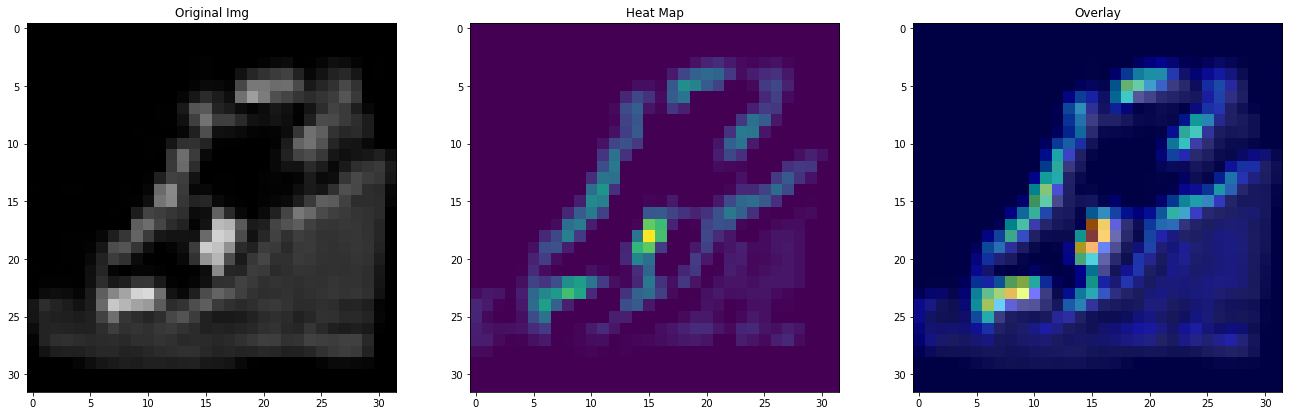

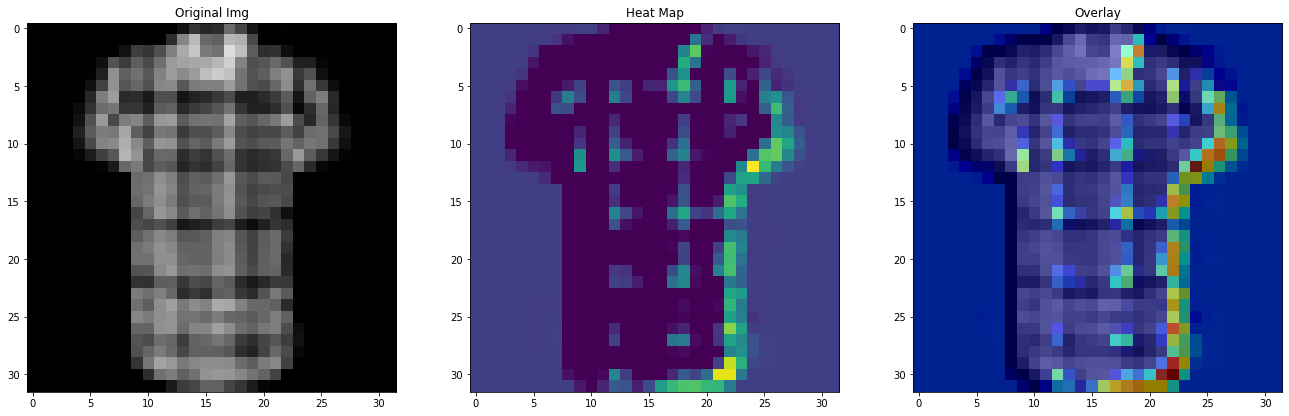

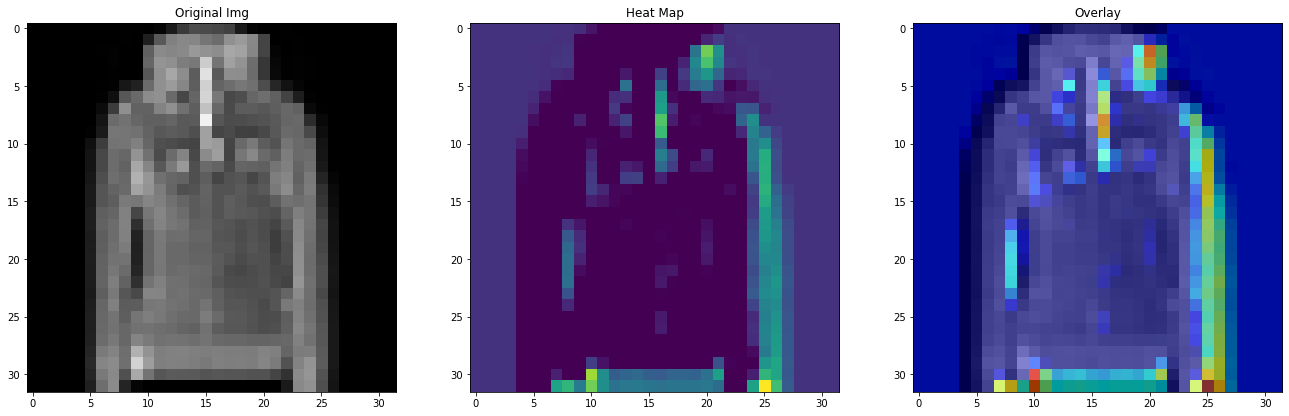

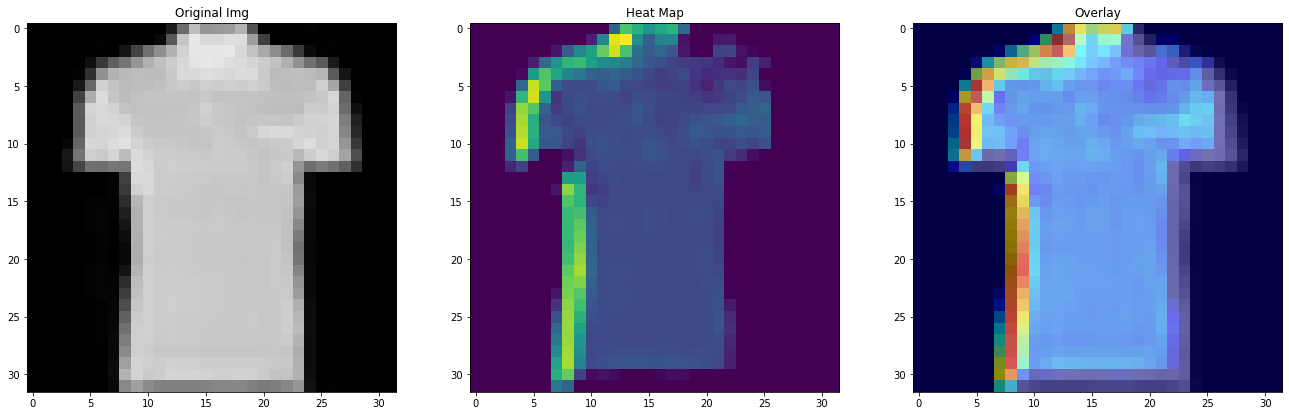

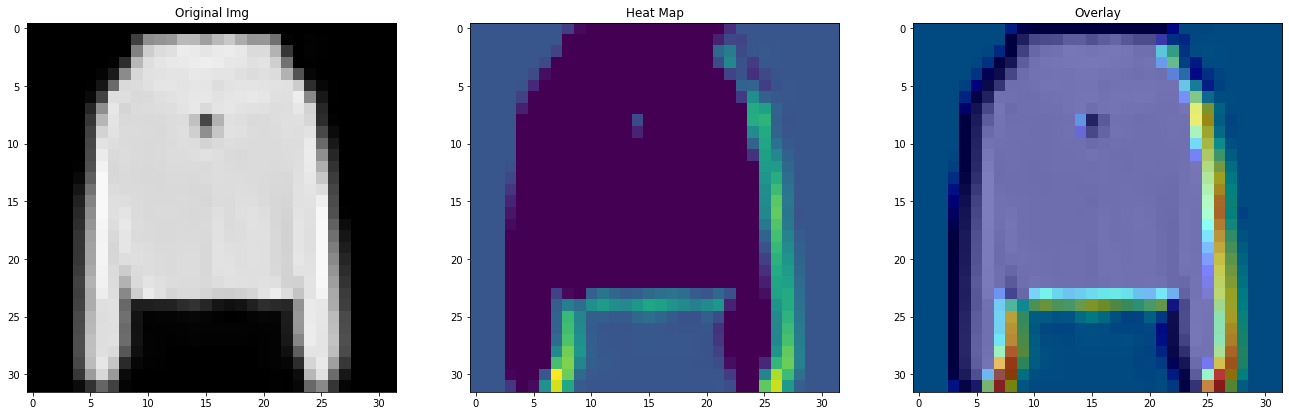

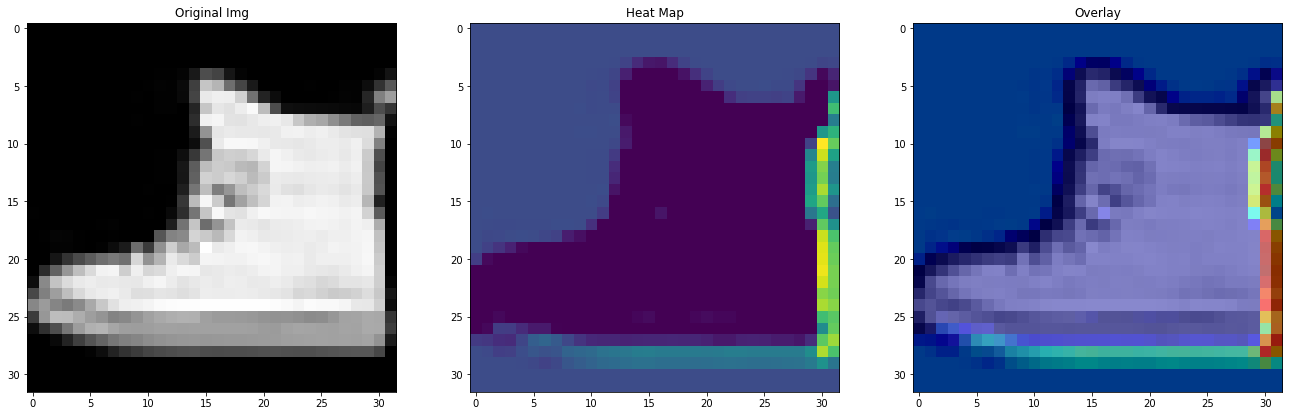

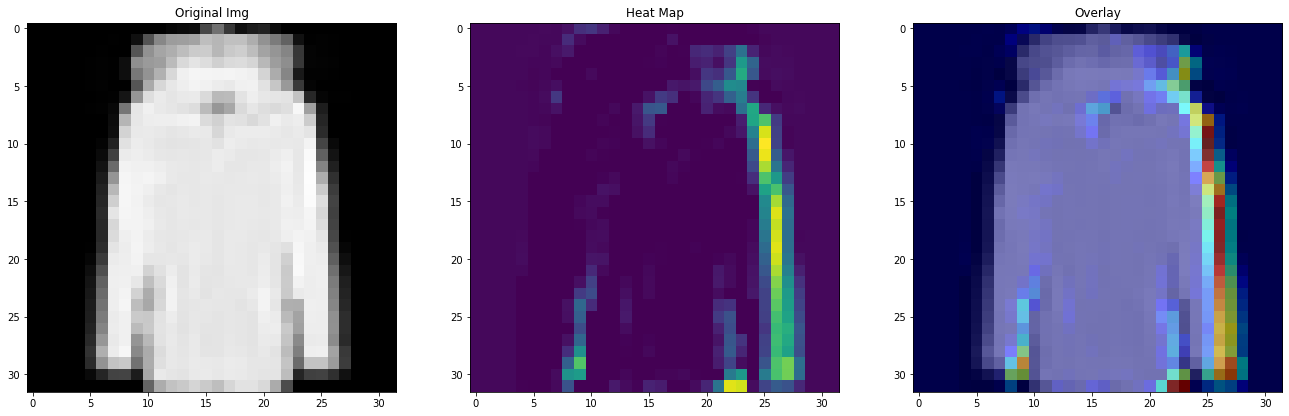

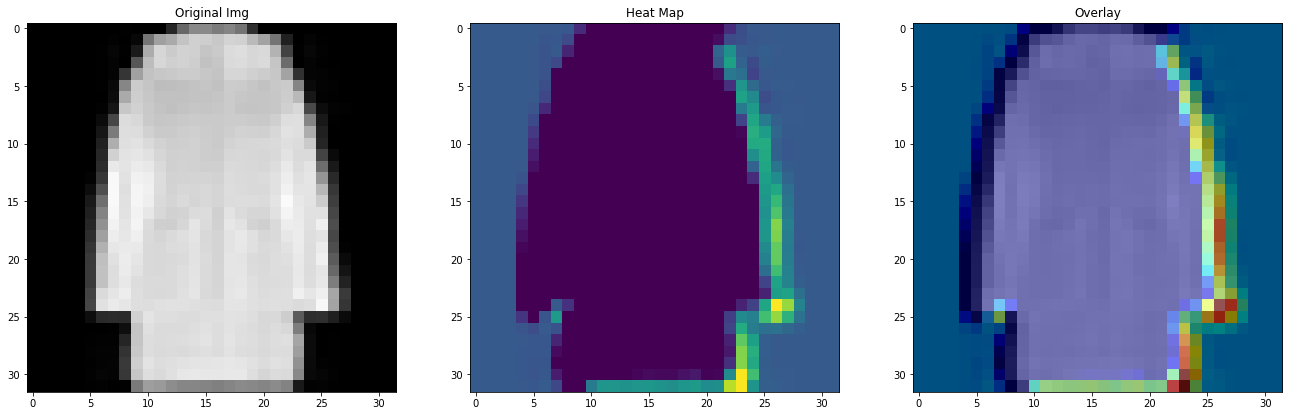

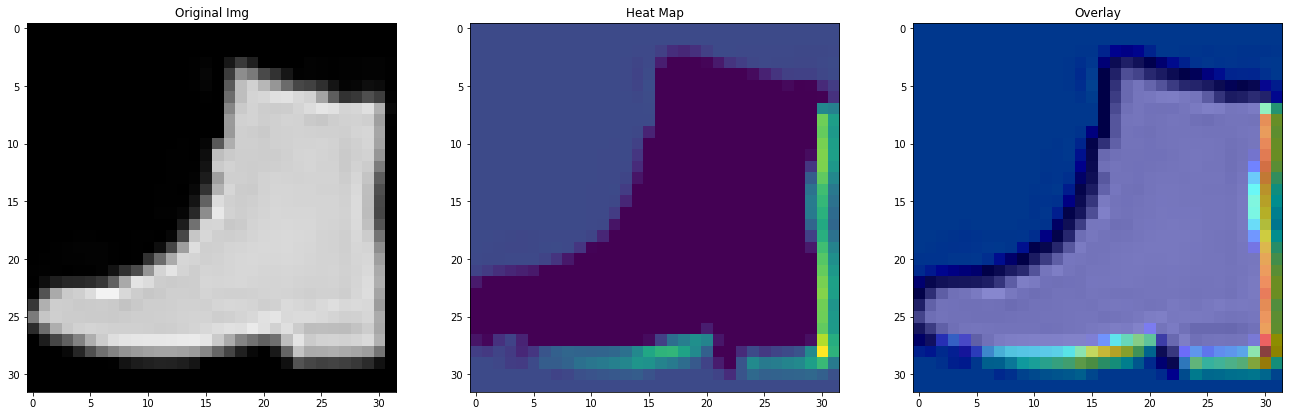

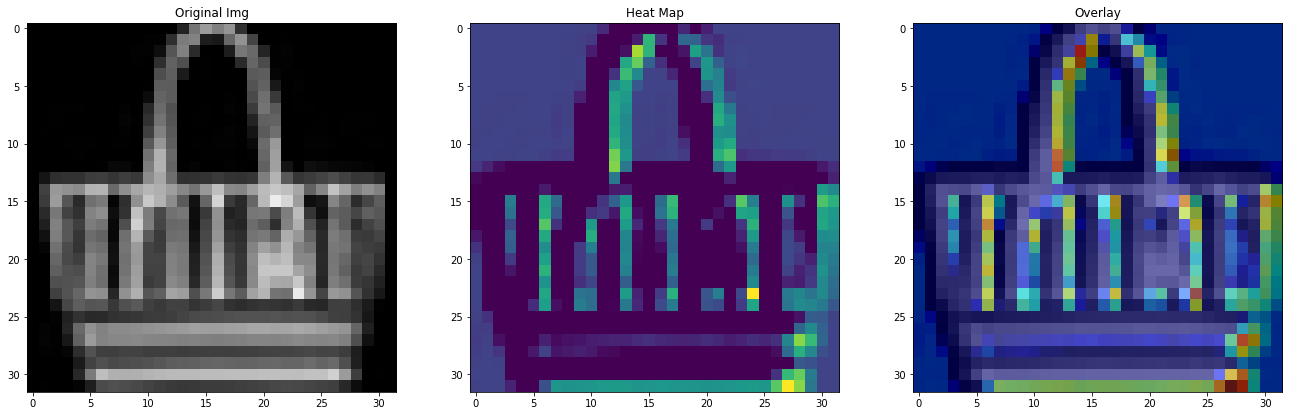

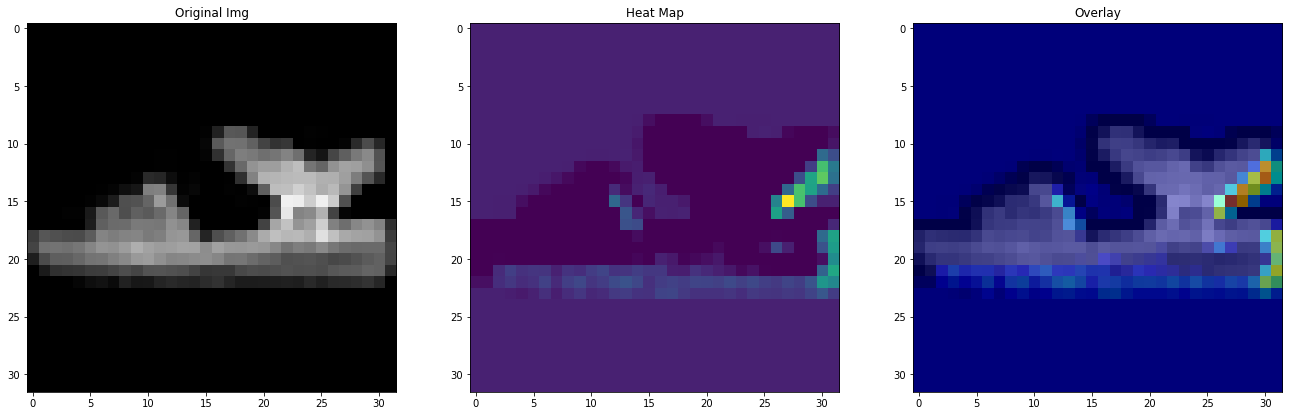

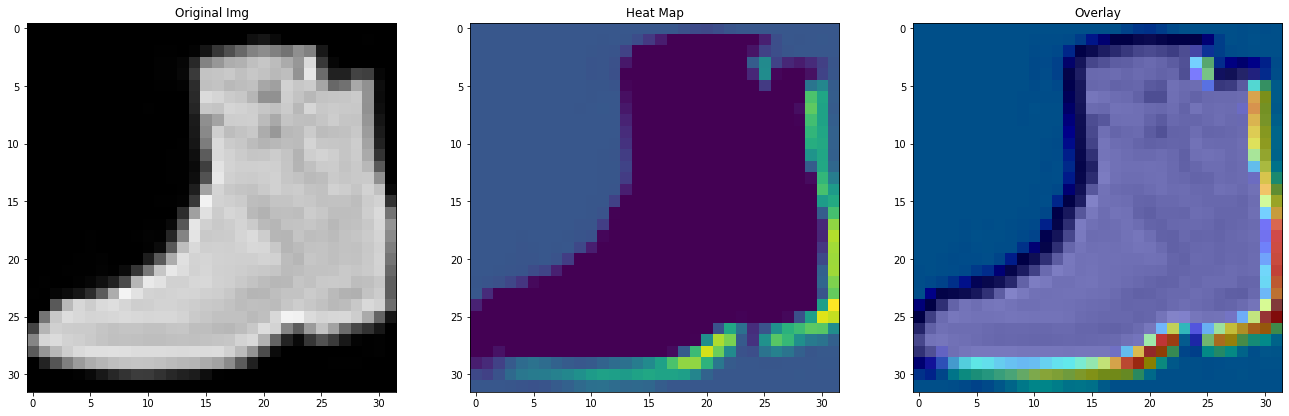

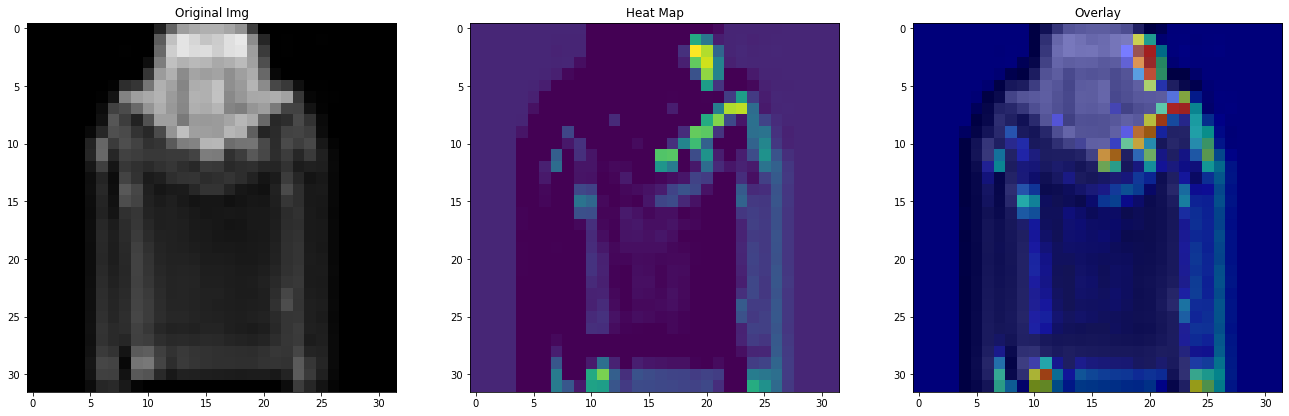

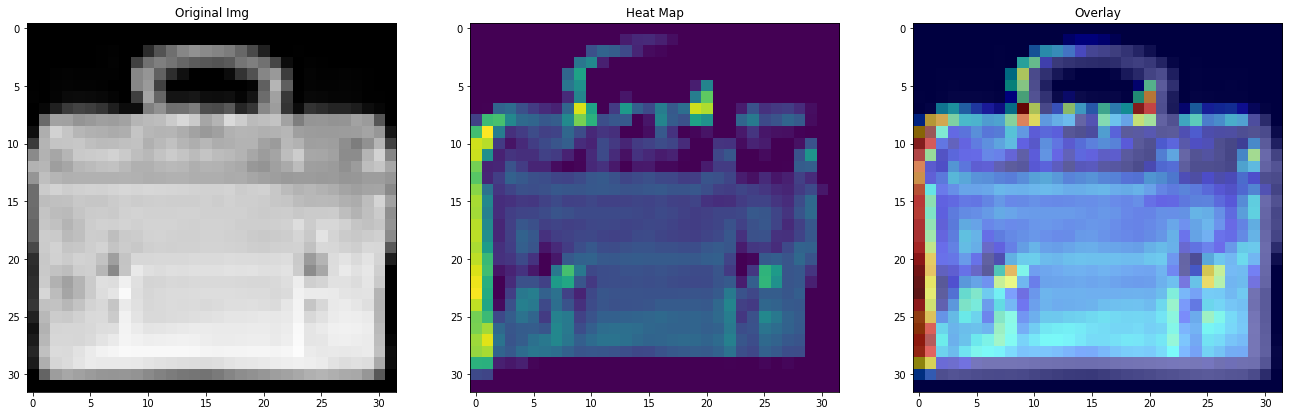

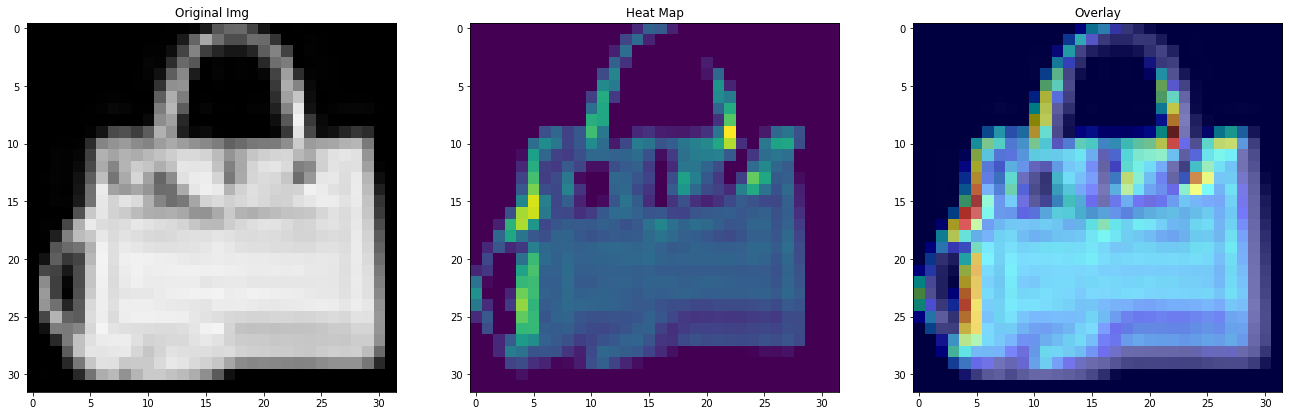

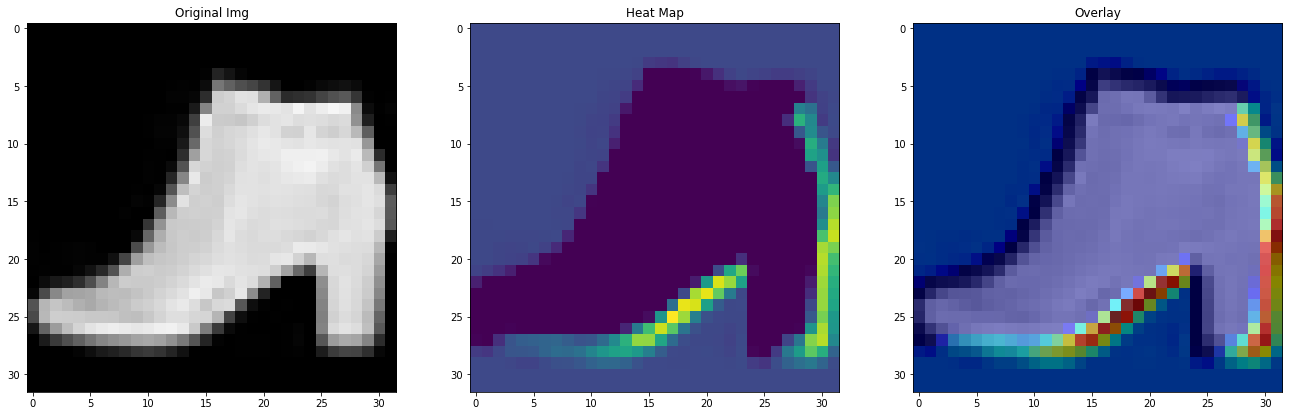

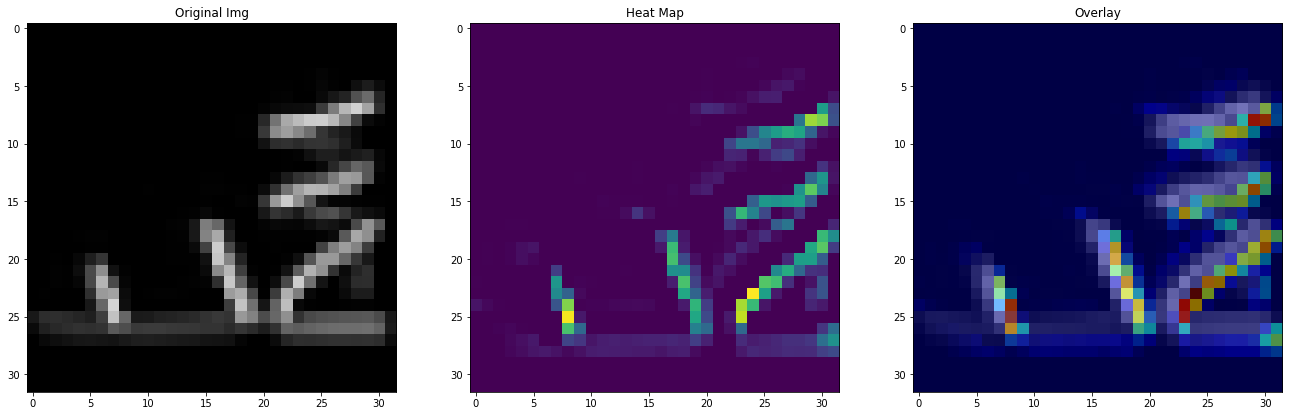

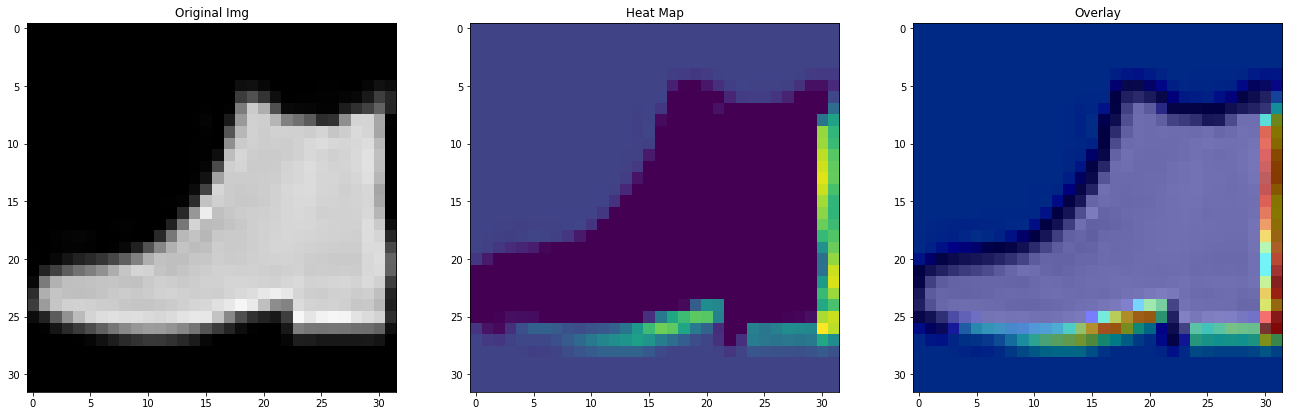

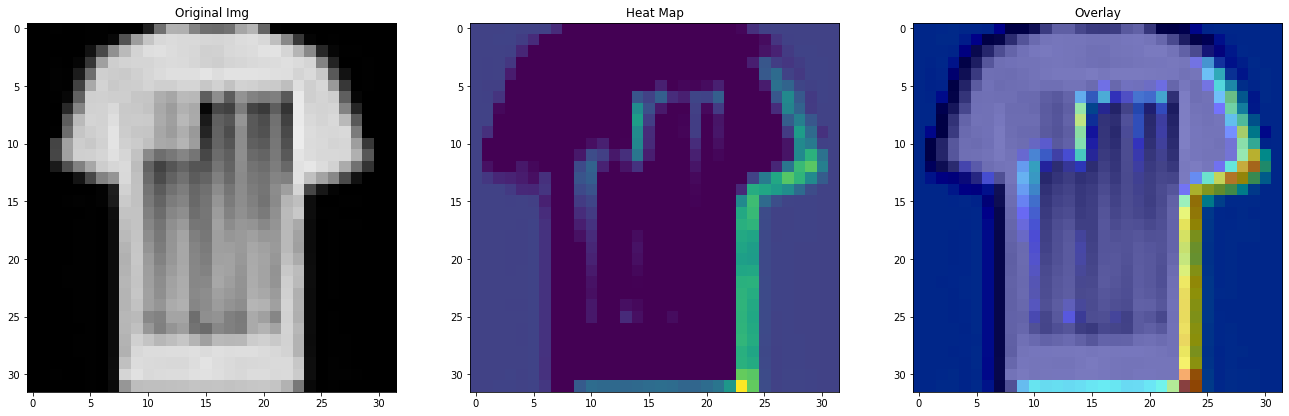

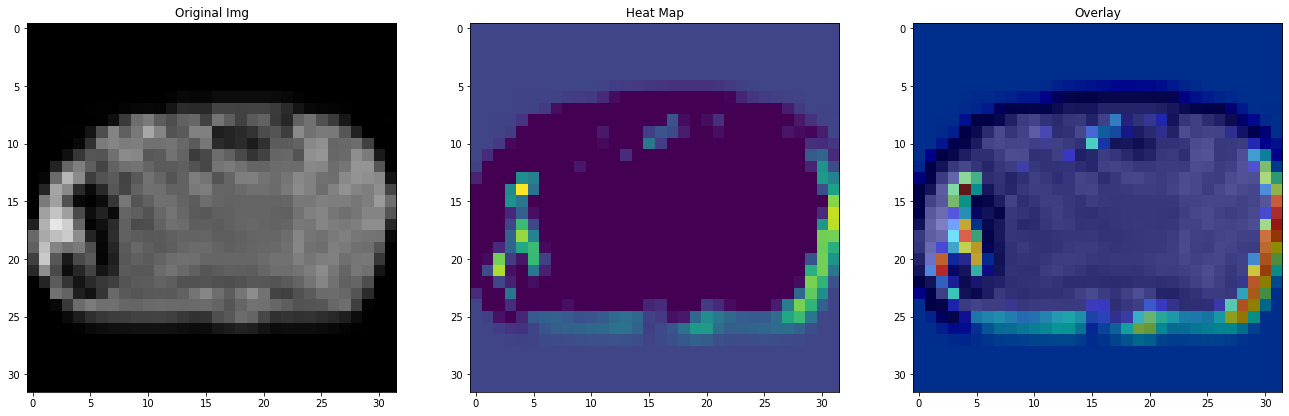

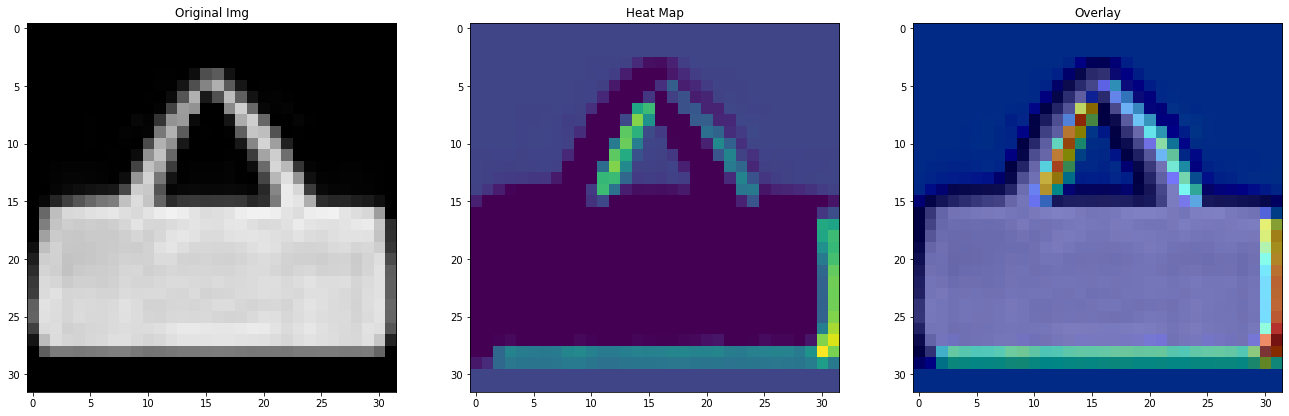

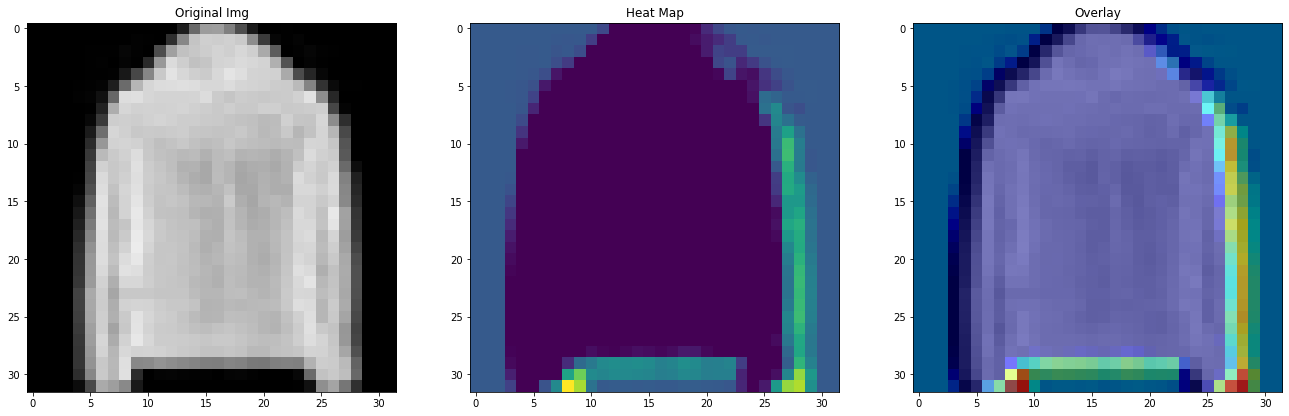

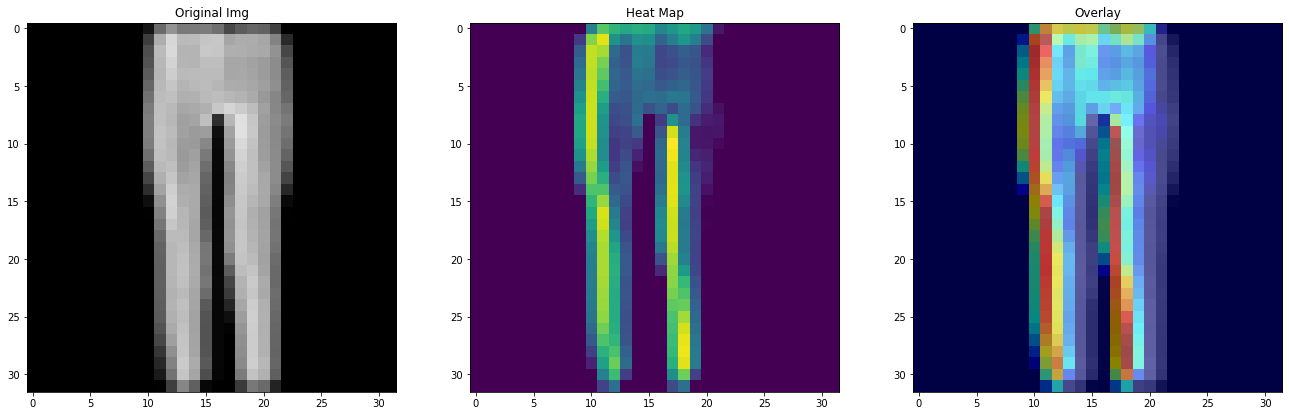

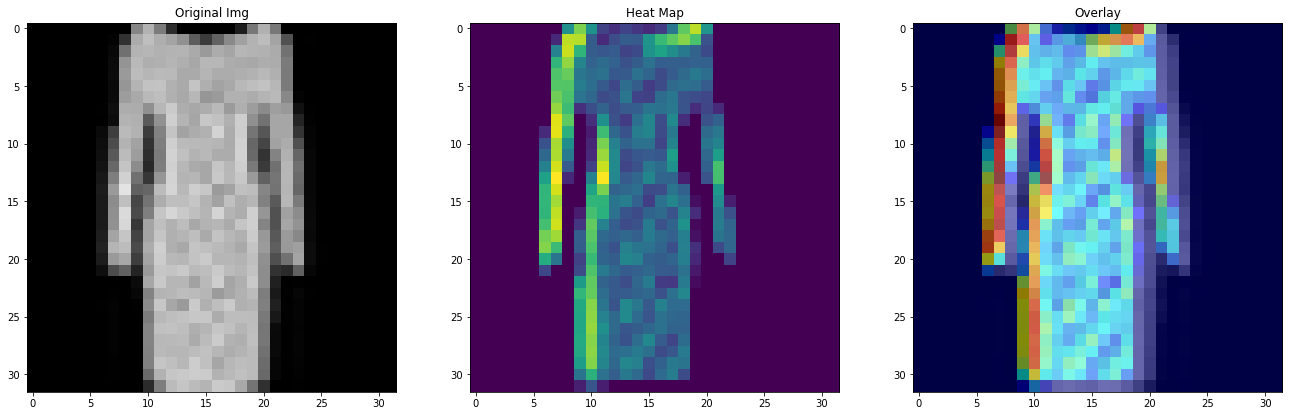

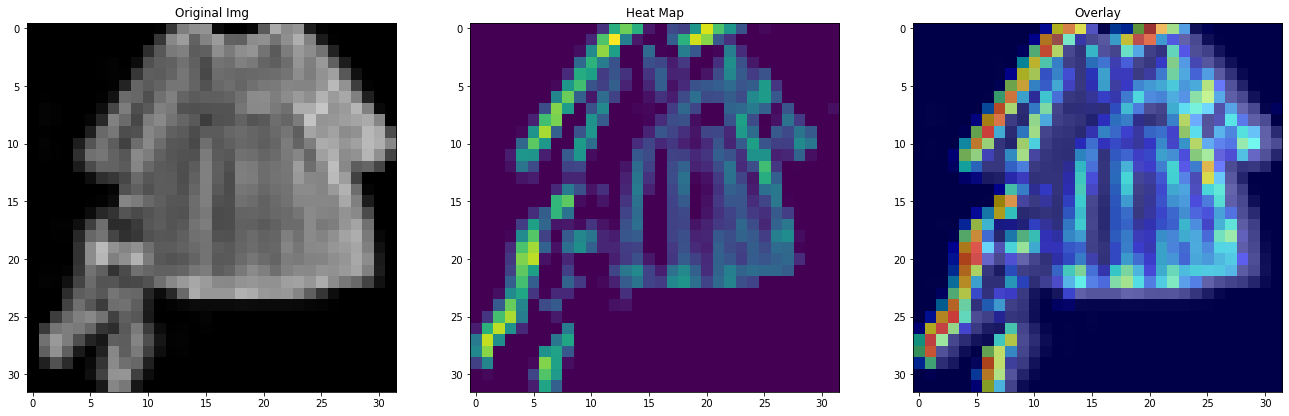

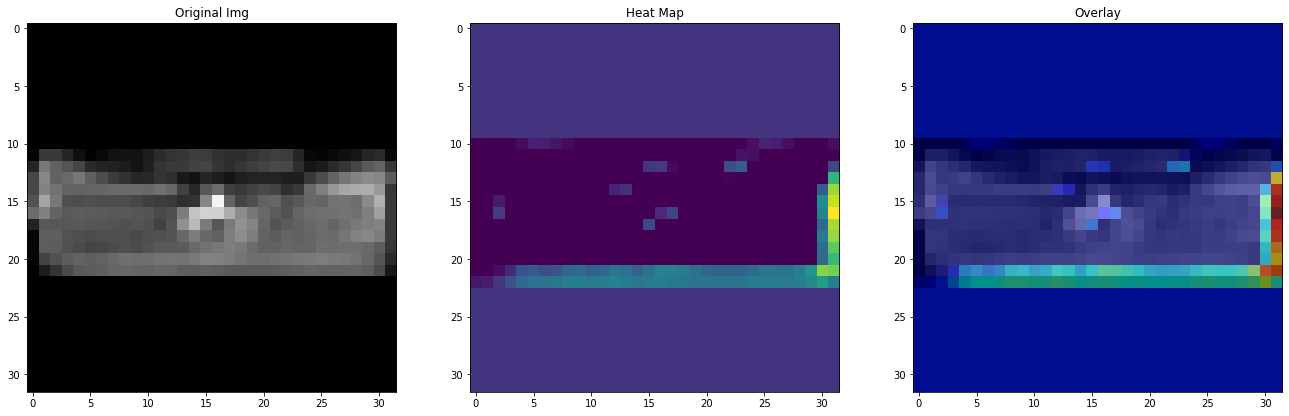

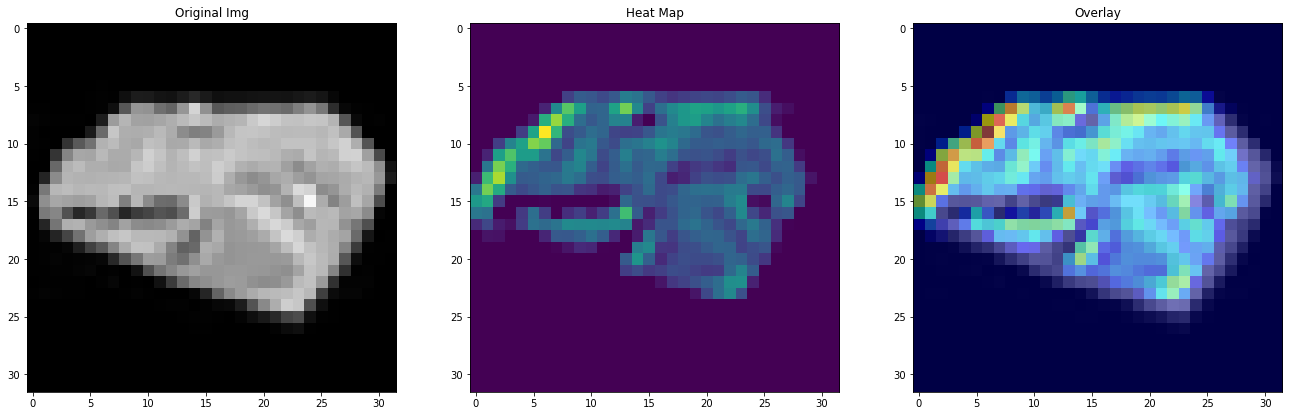

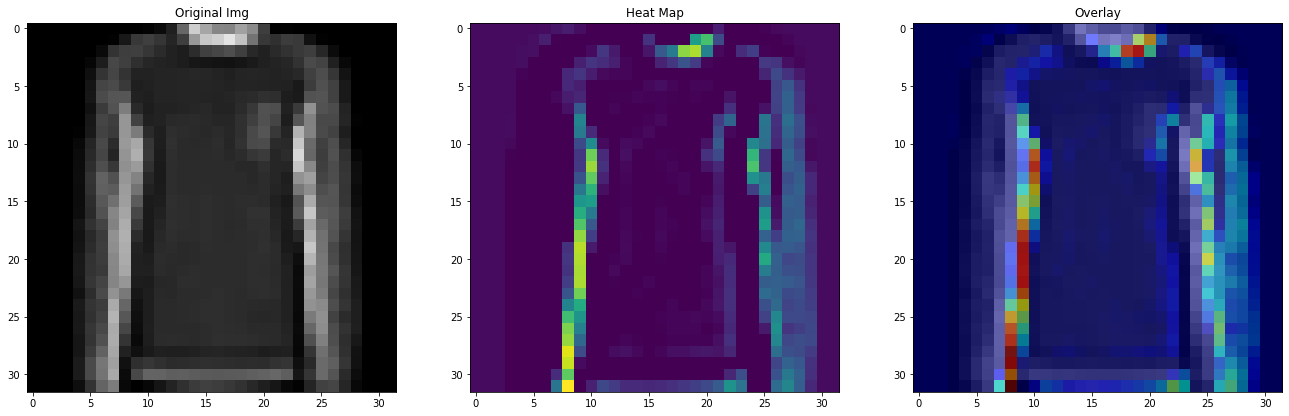

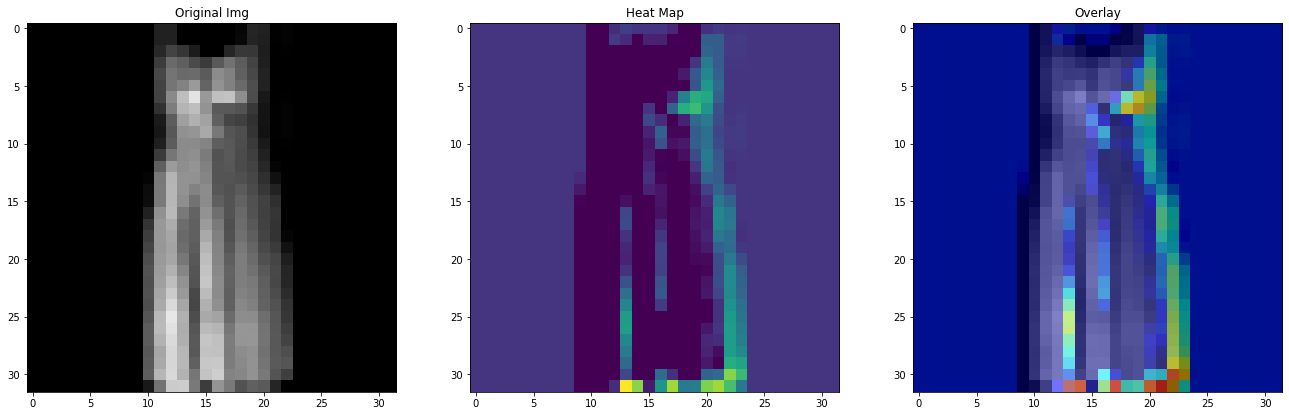

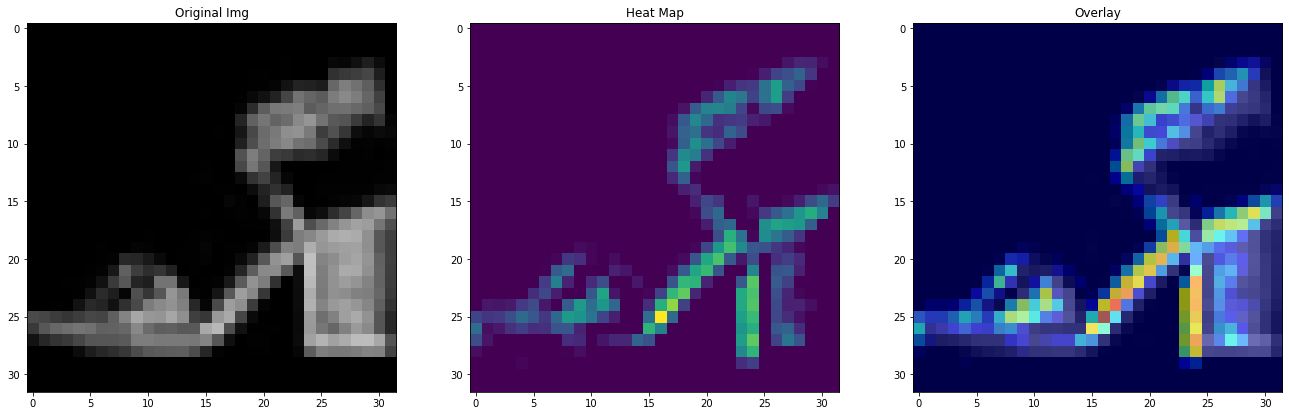

In [40]:
# grad cam on final layer output
net.eval()

# loop over test images
for _ in range(30):
    img_id = int(random.random()*len(testset.data))
    img = testset.data[img_id]
    
    # pre-process the img to make it compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img_tensor = to_pil_trans(img.squeeze().to('cuda'))
    else:
        img_tensor = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img_tensor = trans(img_tensor).unsqueeze(0)
    if img_tensor.shape[1]==4:
        img_tensor = img_tensor[:,0,:,:].unsqueeze(0)
        
    img_rgb = img_tensor.squeeze().unsqueeze(-1).expand(32,32,3)

    # gradCAM code
    targets = [ClassifierOutputTarget(0)]
    target_layers = [net.module.seq[0]]

    cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)
    grayscale_cams = cam(input_tensor=img_tensor, targets=targets, aug_smooth=False, eigen_smooth=True)
    cam_op = show_cam_on_image(np.array(img_rgb), grayscale_cams[0], use_rgb=True)
    
    img_list = []
    img_list.append(img_rgb)
    img_list.append(grayscale_cams[0])
    img_list.append(cam_op)

    # plot results
    plot_images(img_list,rows=1,cols=3,titles=['Original Img','Heat Map','Overlay'])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


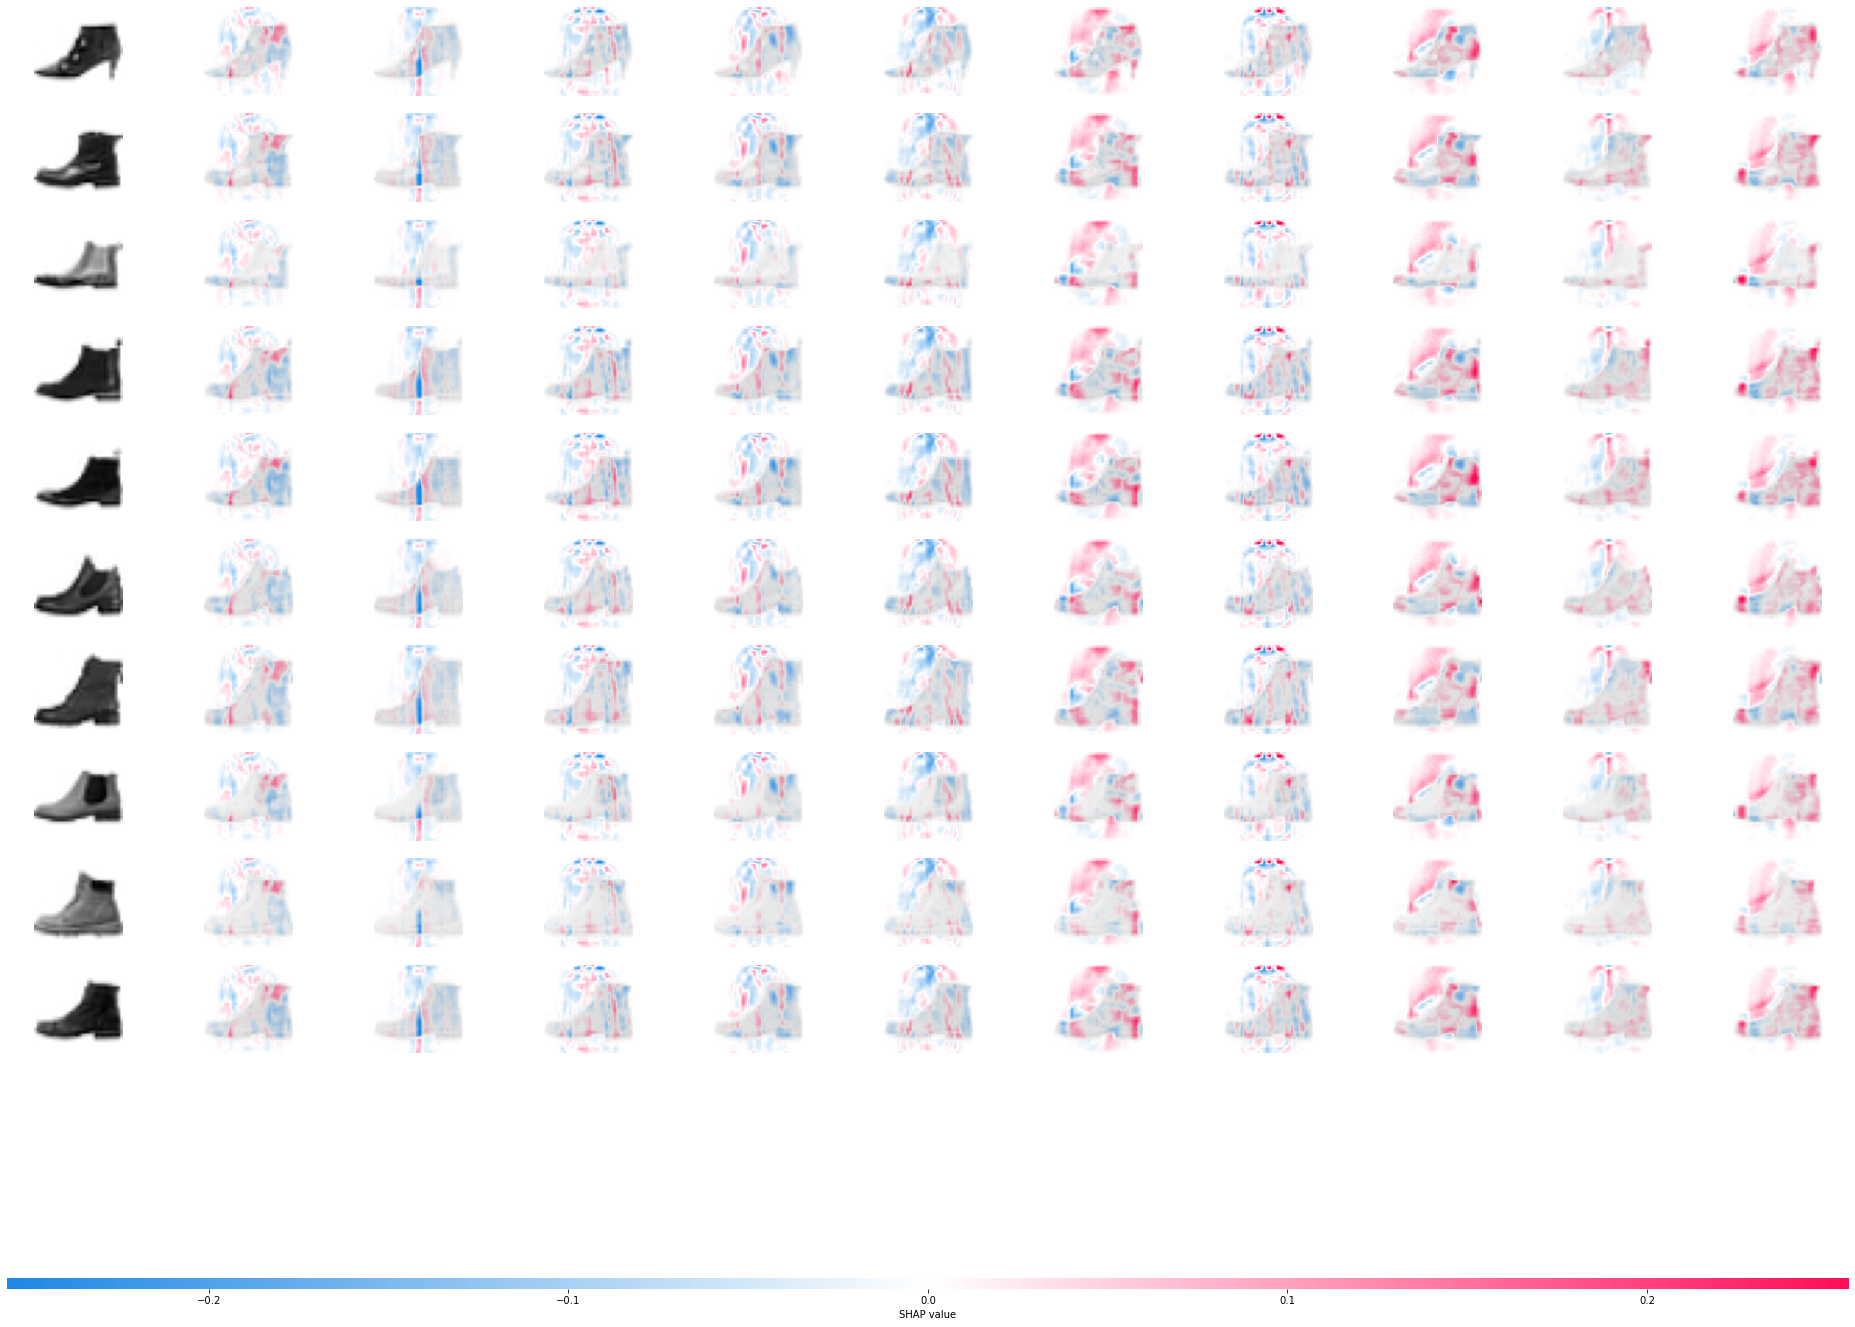

In [13]:
# shap on final layer output
net.eval()

batch = next(iter(testloader))
shap_train_imgs = batch[0][:10].to('cuda')
shap_test_imgs = batch[0][batch[1]==9][10:20].to('cuda')

e = shap.DeepExplainer(net, shap_train_imgs)
shap_values = e.shap_values(shap_test_imgs)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(shap_test_imgs.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy, width=100.0)
# plt.savefig('./shap_test.pdf') # add show=False argument to the shap.image_plot fn to save this plot

# Obtain Train (subset) embeddings

In [41]:
# load checkpoint
# expt_name = 'vgg16_cifar10_29954'
if model=='resnet18':
    net = nn.DataParallel(ResNet18(num_channels=num_ch))
elif model=='vgg16':
    net = nn.DataParallel(VGG('VGG16',num_channels=num_ch))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0

In [42]:
# adding hook function for resnet18
# def add_resnet18_hooks(net, hook):
#     net.module.bn1.register_forward_hook(hook)
    
#     net.module.layer1[0].bn1.register_forward_hook(hook)
#     net.module.layer1[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer1[1].bn1.register_forward_hook(hook)
#     net.module.layer1[1].shortcut.register_forward_hook(hook)

#     net.module.layer2[0].bn1.register_forward_hook(hook)
#     net.module.layer2[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer2[1].bn1.register_forward_hook(hook)
#     net.module.layer2[1].shortcut.register_forward_hook(hook)
    
#     net.module.layer3[0].bn1.register_forward_hook(hook)
#     net.module.layer3[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer3[1].bn1.register_forward_hook(hook)
#     net.module.layer3[1].shortcut.register_forward_hook(hook)
    
#     net.module.layer4[0].bn1.register_forward_hook(hook)
#     net.module.layer4[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer4[1].bn1.register_forward_hook(hook)
#     net.module.layer4[1].shortcut.register_forward_hook(hook)
        
#     return net

def add_resnet18_hooks(net, hook):
    net.module.bn1.register_forward_hook(hook)
    
    net.module.layer1[0].conv1.register_forward_hook(hook)
    net.module.layer1[0].conv2.register_forward_hook(hook)
    
    net.module.layer1[1].conv1.register_forward_hook(hook)
    net.module.layer1[1].conv2.register_forward_hook(hook)

    net.module.layer2[0].conv1.register_forward_hook(hook)
    net.module.layer2[0].conv2.register_forward_hook(hook)
    
    net.module.layer2[1].conv1.register_forward_hook(hook)
    net.module.layer2[1].conv2.register_forward_hook(hook)
    
    net.module.layer3[0].conv1.register_forward_hook(hook)
    net.module.layer3[0].conv2.register_forward_hook(hook)
    
    net.module.layer3[1].conv1.register_forward_hook(hook)
    net.module.layer3[1].conv2.register_forward_hook(hook)
    
    net.module.layer4[0].conv1.register_forward_hook(hook)
    net.module.layer4[0].conv2.register_forward_hook(hook)
    
    net.module.layer4[1].conv1.register_forward_hook(hook)
    net.module.layer4[1].conv2.register_forward_hook(hook)
        
    return net

def add_vgg16_hooks(net, hook):
    net.module.features[0].register_forward_hook(hook)
    net.module.features[3].register_forward_hook(hook)
    net.module.features[7].register_forward_hook(hook)
    net.module.features[10].register_forward_hook(hook)
    net.module.features[14].register_forward_hook(hook)
    net.module.features[17].register_forward_hook(hook)
    net.module.features[20].register_forward_hook(hook)
    net.module.features[24].register_forward_hook(hook)
    net.module.features[27].register_forward_hook(hook)
    net.module.features[30].register_forward_hook(hook)
    net.module.features[34].register_forward_hook(hook)
    net.module.features[37].register_forward_hook(hook)
    net.module.features[40].register_forward_hook(hook)        
    return net

def add_densenet121_hooks(net, hook):
    
    for idx,layer in enumerate(net.module.dense1):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense2):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense3):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense4):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    return net

In [43]:
feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out):
#     out = torch.nn.functional.interpolate(out,(8,8))
#     feature_maps.append(torch.mean(out,dim=[2,3]))
    feature_maps.append(torch.reshape(out, (out.shape[0],-1)))

if model=='resnet18':
    net = add_resnet18_hooks(net, hook_feat_map)
elif model=='vgg16':
    net = add_vgg16_hooks(net, hook_feat_map)
elif model=='densenet121':
    net = add_densenet121_hooks(net, hook_feat_map)

In [44]:
def to_cpu(arr):
    for idx,x in enumerate(arr):
        arr[idx] = x.to('cpu')
    return arr

def print_memory_profile(s):
    # print GPU memory
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(s)
    print(t/1024**3,r/1024**3,a/1024**3)
    print('\n')


In [45]:
# # something wrong here with my equal sampling I think
# if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
#     imgs = torch.empty((0,trainset.data[0].shape[0],trainset.data[0].shape[1]))
# else:
#     imgs = torch.empty((0,trainset.data[0].shape[0],trainset.data[0].shape[1],trainset.data[0].shape[2]))
# targs = torch.empty(0)

# for i in tqdm(range(num_classes)): 
#     cls_inds = (torch.tensor(trainset.targets)==i).nonzero(as_tuple=True)[0]

#     # randomly permute cls_inds, and subsample
#     # in total we want 3k samples of train embeddings
#     perm = torch.randperm(cls_inds.size(0))
#     inds = perm[:num_embs//num_classes]
#     cls_inds = cls_inds[inds]
#     samples = torch.tensor(trainset.data[cls_inds])
#     imgs = torch.cat((imgs,samples)) # this will have num_embs samples finally    
#     targs = torch.cat((targs,torch.ones_like(cls_inds)*i))
    
# if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
#     # resize again to 32x32
#     imgs_resized = torch.empty((0,32,32))
#     T = transforms.ToPILImage()
#     for img in imgs:
#         imgs_resized = torch.cat((imgs_resized,trans(T(img))))
#     train_subset = torch.utils.data.TensorDataset(imgs_resized,targs)
# else:    
#     train_subset = torch.utils.data.TensorDataset(imgs,targs)

In [46]:
labs = torch.tensor(trainset.targets)
perm = torch.randperm(labs.size(0))
inds = perm[:num_embs]
labs = labs[inds]
samples = torch.tensor(trainset.data)[inds]

if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    # resize again to 32x32
    samples_resized = torch.empty((0,32,32))
    T = transforms.ToPILImage()
    for img in samples:
        samples_resized = torch.cat((samples_resized,trans(T(img))))
    train_subset = torch.utils.data.TensorDataset(samples_resized,labs) 
elif dataset=='cifar10':
    # resize again to 32x32
    samples_resized = torch.empty((0,32,32))
    T = transforms.ToPILImage()
    for img in samples:
        samples_resized = torch.cat((samples_resized,trans(T(img.permute(2,0,1)))))
    samples_resized = samples_resized.unsqueeze(1)
    train_subset = torch.utils.data.TensorDataset(samples_resized,labs)  
elif dataset=='svhn':
    # resize again to 32x32
    samples_resized = torch.empty((0,32,32))
    T = transforms.ToPILImage()
    for img in samples:
        samples_resized = torch.cat((samples_resized,trans(T(img))))
    samples_resized = samples_resized.unsqueeze(1)
    train_subset = torch.utils.data.TensorDataset(samples_resized,labs) 
else:
    train_subset = torch.utils.data.TensorDataset(samples,labs)
trainloader2 = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [47]:
img.shape

torch.Size([28, 28])

In [48]:
samples_resized.shape

torch.Size([1000, 32, 32])

In [49]:
# code for saving pkl file of layer embeddings
save_path = os.path.join(save_dir,f'{expt_name}.pkl')
trainloader2 = torch.utils.data.DataLoader(train_subset, batch_size=30000, shuffle=True, num_workers=2)

handle = open(save_path, "wb")

with torch.no_grad():
    net.eval()
    for b_idx,batch in enumerate(tqdm(trainloader2)):        
        # print GPU memory
        print_memory_profile('Initial')
        
        if dataset=='mnist'  or dataset=='kmnist' or dataset=='fmnist':
            imgs = batch[0].unsqueeze(1).to('cuda')
        elif dataset=='svhn' or dataset=='cifar10':
            imgs = batch[0].to('cuda')
        else:
            imgs = batch[0].permute(0,3,1,2).to('cuda')
        labels = batch[1]
        
        feature_maps = []
        out = net(imgs.float())
        
        info_dict = {'batch_idx':b_idx,'num_batches':len(trainloader2),'feats':feature_maps,'labels':labels}
        pickle.dump(info_dict, handle)  
        
        # print GPU memory
        print_memory_profile('After processing Batch')
        
        # free up GPU memory
        del feature_maps, info_dict
        torch.cuda.empty_cache()     
        
        # print GPU memory
        print_memory_profile('After freeing GPU memory')
        
handle.close()
        

  0%|          | 0/1 [00:00<?, ?it/s]

Initial
31.7391357421875 1.9296875 0.2883000373840332




100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

After processing Batch
31.7391357421875 1.9296875 1.318854808807373


After freeing GPU memory
31.7391357421875 1.919921875 0.28833723068237305




# Compute PD

In [63]:
# compute_pd.py

def compute_pred_depth(arr):
    last = arr[-1]

    p_depth = 1
    for i in range(len(arr)-1):
        ele = arr[-1-(i+1)]
        if ele!=last:
            p_depth = (len(arr)-(i+1)) + 1
            break
    
    return p_depth

In [64]:
labs = torch.tensor(testset.targets)
perm = torch.randperm(labs.size(0))
inds = perm[:num_test_imgs]
labs = labs[inds]
samples = torch.tensor(testset.data)[inds]

if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    # resize again to 32x32
    samples_resized = torch.empty((0,32,32))
    T = transforms.ToPILImage()
    for img in samples:
        samples_resized = torch.cat((samples_resized,trans(T(img))))
    test_subset = torch.utils.data.TensorDataset(samples_resized,labs)
else:
    test_subset = torch.utils.data.TensorDataset(samples,labs)
testloader2 = torch.utils.data.DataLoader(test_subset, batch_size=128, shuffle=True, num_workers=2)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [65]:
# ===================== Storing Batch Statistics =====================

batch_info = {}
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')
ckpt_path = os.path.join(save_dir,f'{expt_name}.pt')
batch_info['readme'] = f'---- K={K} ---- ckpt_path={ckpt_path} ---- pkl_path={train_embs_pkl_path} ----'
batch_info['imgs'] = [] # test images
batch_info['preds'] = [] # corresponding model predictions
batch_info['pred_probs'] = [] # corresponding model predictions
batch_info['labels'] = [] # labels of the test images
batch_info['pd'] = [] # corresponding prediction depths
batch_info['layers_knn_prob'] = [] # for each test image we have a list of knn means for every layer
batch_info['layers_knn_mode'] = [] # for each test image we have a list of knn mode for every layer

print_memory_profile('Initial')

Initial
31.7391357421875 1.921875 0.28933000564575195




In [67]:
# loop over test images
invalid_counter = 0 # for invalid predictions (last layer mode != model output)
for test_id, (img,lab) in enumerate(tqdm(testset)):
    if test_id==120:
        break
    img = img.permute([1,2,0])
    batch_info['imgs'].append(img)
    with torch.no_grad():
        to_pil_trans = transforms.ToPILImage()
        if dataset=='mnist':
            img = to_pil_trans(img.to('cuda'))
        else:
            img = to_pil_trans(img.permute(2,0,1).to('cuda'))
        img = trans(img).unsqueeze(0)
        lab = int(lab)
        if img.shape[1]==4:
            img = img[:,0,:,:].unsqueeze(0)
        feature_maps = []
        out = net(img)
        print(f'OUT = {out}')
        print(f'Model output: {out.max()}')
        batch_info['preds'].append(int(out.argmax()))
        batch_info['pred_probs'].append(float(torch.nn.functional.softmax(out).max()))
        batch_info['labels'].append(lab)

        print_memory_profile('Model forward pass')
        with open(train_embs_pkl_path, 'rb') as handle:            
            info_dict = pickle.load(handle)
            print_memory_profile('Pickle load')

            # loop over layers in densenet, and compute KNN for this test image
            knn_preds_mode = []  # layer-wise final KNN classification preds   
            knn_preds_prob = []
            for layer_id,feat in tqdm(enumerate(feature_maps)):
                X_i = feat.unsqueeze(1)  # (10000, 1, 784) test set
                X_j = info_dict['feats'][layer_id].unsqueeze(0)  # (1, 60000, 784) train set
                if lp_norm==2:
                    D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
                elif lp_norm==1:
                    D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
                else:
                    raise('Invalid lp_norm in arguments!')

                ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
                lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]
#                 print(f'!!!!!!test_img:{test_id}, nbrs in layer {layer_id}: {ind_knn[1]}')
                mode = int(lab_knn.squeeze().mode()[0])
                knn_preds_mode.append(mode)
                knn_preds_prob.append(float((lab_knn==mode).float().mean()))

            print_memory_profile('Pickle batch processed')

            # free GPU memory
            del info_dict
            torch.cuda.empty_cache()
            print_memory_profile('After GPU memory freed') 

            print('Test Image: %d' %(test_id))
            print(f'knn_preds_mode: {knn_preds_mode}')
            print(f'knn_preds_prob: {knn_preds_prob}')
            print(f'label: {lab}')
            print(f'pred: {int(out.argmax())}')
            print('\n')
            batch_info['layers_knn_prob'].append(knn_preds_prob)
            batch_info['layers_knn_mode'].append(knn_preds_mode)
            if int(out.argmax())==knn_preds_mode[-1]: # PD accurate
                if knn_pos_thresh==0.5 and knn_neg_thresh==0.5:
                    batch_info['pd'].append(compute_pred_depth(knn_preds_mode))
                else:
                    raise('Code not ready yet! Compute pred arr function also has to be updated!')
            else: # PD inaccurate, KNN pred doesn't match model pred
                print('Invalid datapoint: last_layer_mode != model_output')
                invalid_counter += 1
#                 batch_info['pd'].append(-99)
                if knn_pos_thresh==0.5 and knn_neg_thresh==0.5:
                    batch_info['pd'].append(compute_pred_depth(knn_preds_mode))
                else:
                    raise('Code not ready yet! Compute pred arr function also has to be updated!')
print(f'Invalid Counts Ratio: {invalid_counter}/{num_test_imgs}')

  0%|          | 0/10000 [00:00<?, ?it/s]Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


OUT = tensor([[-1.7316, -5.3279,  3.5643,  2.2154, -1.5620,  4.8390, -3.0720,  1.1280,
         -2.1618,  2.3775]], device='cuda:0')
Model output: 4.839032173156738
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





0it [00:00, ?it/s]
13it [00:00, 51.31it/s][A
  0%|          | 1/10000 [00:01<4:12:22,  1.51s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 0
knn_preds_mode: [5, 5, 5, 8, 2, 2, 2, 2, 3, 2, 2, 2, 2]
knn_preds_prob: [0.6896551847457886, 0.7586206793785095, 0.4137931168079376, 0.24137930572032928, 0.4137931168079376, 0.48275861144065857, 0.5517241358757019, 0.4137931168079376, 0.517241358757019, 0.6206896305084229, 0.48275861144065857, 0.517241358757019, 0.5862069129943848]
label: 2
pred: 5


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 3.5707,  0.1887, -3.4722, -5.0111,  5.3845,  0.1844, -3.1173,  1.1616,
         -1.5010,  2.4064]], device='cuda:0')
Model output: 5.384515762329102
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1490.43it/s]
  0%|          | 2/10000 [00:02<3:38:03,  1.31s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 1
knn_preds_mode: [9, 9, 9, 9, 9, 9, 9, 9, 9, 4, 4, 4, 4]
knn_preds_prob: [0.6896551847457886, 0.7241379022598267, 0.7586206793785095, 0.7586206793785095, 0.7931034564971924, 0.8275862336158752, 0.8620689511299133, 0.8965517282485962, 0.6551724076271057, 0.517241358757019, 0.6206896305084229, 0.8275862336158752, 0.8965517282485962]
label: 9
pred: 4


OUT = tensor([[ -5.8003, -10.2767,   3.3484,   8.6145,  -1.0561,   4.8683,   2.0364,
           1.9169,   1.1908,  -4.7014]], device='cuda:0')
Model output: 8.61446762084961
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1497.43it/s]
  0%|          | 3/10000 [00:03<3:27:28,  1.25s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 2
knn_preds_mode: [3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.27586206793785095, 0.27586206793785095, 0.48275861144065857, 0.48275861144065857, 0.5862069129943848, 0.5517241358757019, 0.6206896305084229, 0.7931034564971924, 0.931034505367279, 0.9655172228813171, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-3.5406, -0.1507, -1.7429, -0.2869,  1.8646,  0.8693,  1.8991, -1.8463,
          7.3356, -4.7127]], device='cuda:0')
Model output: 7.335569858551025
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1497.88it/s]
  0%|          | 4/10000 [00:05<3:22:24,  1.21s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 3
knn_preds_mode: [8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.5517241358757019, 0.37931033968925476, 0.6551724076271057, 0.6896551847457886, 0.931034505367279, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 8
pred: 8


OUT = tensor([[ -7.3355, -15.8178,   6.1570,  12.7378,  -1.7101,   6.3543,   1.7264,
           4.6499,  -1.9824,  -4.3942]], device='cuda:0')
Model output: 12.737768173217773
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1458.58it/s]
  0%|          | 5/10000 [00:06<3:20:17,  1.20s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 4
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.8620689511299133, 0.8275862336158752, 0.7931034564971924, 0.7931034564971924, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[ -6.1456, -12.5253,   4.5843,   9.7117,  -1.7312,   7.5515,  -0.4318,
           1.8485,   0.4740,  -3.0628]], device='cuda:0')
Model output: 9.711723327636719
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1467.45it/s]
  0%|          | 6/10000 [00:07<3:19:01,  1.19s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 5
knn_preds_mode: [5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.6206896305084229, 0.6896551847457886, 0.4482758641242981, 0.48275861144065857, 0.5862069129943848, 0.5862069129943848, 0.7931034564971924, 0.8275862336158752, 0.931034505367279, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-4.9761, -0.7426, -2.5296,  0.4864,  2.8742,  0.3962,  3.5692, -2.0270,
          9.9293, -7.3982]], device='cuda:0')
Model output: 9.929262161254883
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1458.19it/s]
  0%|          | 7/10000 [00:08<3:18:15,  1.19s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 6
knn_preds_mode: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.6896551847457886, 0.48275861144065857, 0.7931034564971924, 0.7931034564971924, 0.7586206793785095, 0.7586206793785095, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 8
pred: 8


OUT = tensor([[-4.1611, -7.5914,  1.6707,  6.0704, -0.6260,  4.1007,  1.5708,  0.8646,
          2.4607, -4.3444]], device='cuda:0')
Model output: 6.070368766784668
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1440.69it/s]
  0%|          | 8/10000 [00:09<3:17:36,  1.19s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 7
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.6206896305084229, 0.6896551847457886, 0.6896551847457886, 0.7586206793785095, 0.48275861144065857, 0.5517241358757019, 0.7241379022598267, 0.7241379022598267, 0.7931034564971924, 0.7931034564971924, 0.931034505367279, 0.9655172228813171, 0.931034505367279]
label: 3
pred: 3


OUT = tensor([[-1.8014, -5.1910,  2.2036,  2.9116, -1.0846,  4.6375, -1.4890,  0.2780,
         -0.0101, -0.3383]], device='cuda:0')
Model output: 4.637461185455322
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1471.73it/s]
  0%|          | 9/10000 [00:10<3:17:13,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 8
knn_preds_mode: [5, 5, 5, 5, 9, 2, 2, 2, 3, 2, 3, 3, 5]
knn_preds_prob: [0.517241358757019, 0.6551724076271057, 0.6206896305084229, 0.4482758641242981, 0.3103448152542114, 0.3103448152542114, 0.4137931168079376, 0.517241358757019, 0.48275861144065857, 0.37931033968925476, 0.5862069129943848, 0.6206896305084229, 0.48275861144065857]
label: 2
pred: 5


OUT = tensor([[-0.0268, -4.4449, -1.1372,  0.6778,  0.4502,  5.9425, -3.6559, -1.2933,
          3.9447, -0.5415]], device='cuda:0')
Model output: 5.9424614906311035
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1470.42it/s]
  0%|          | 10/10000 [00:12<3:16:52,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 9
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5]
knn_preds_prob: [0.4482758641242981, 0.48275861144065857, 0.5862069129943848, 0.5517241358757019, 0.6206896305084229, 0.7241379022598267, 0.7931034564971924, 0.48275861144065857, 0.37931033968925476, 0.6206896305084229, 0.9655172228813171, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[-12.6591,   0.1881,   3.7529,   4.1446,   0.6277,  -6.4423,  14.7383,
           4.0616,   1.9836, -10.9597]], device='cuda:0')
Model output: 14.738283157348633
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1465.91it/s]
  0%|          | 11/10000 [00:13<3:16:48,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 10
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.5862069129943848, 0.6206896305084229, 0.6551724076271057, 0.6896551847457886, 0.7931034564971924, 0.8965517282485962, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[ -8.4394, -17.6986,   6.5021,  14.3700,  -1.5913,   7.2093,   2.0393,
           4.9071,  -1.6858,  -5.2254]], device='cuda:0')
Model output: 14.370043754577637
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1503.67it/s]
  0%|          | 12/10000 [00:14<3:18:08,  1.19s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 11
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.931034505367279, 0.7586206793785095, 0.9655172228813171, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-5.1009, -6.9305,  1.0866,  5.8552, -0.5404,  4.0389,  1.9971,  0.0169,
          4.7944, -5.3100]], device='cuda:0')
Model output: 5.855244159698486
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1450.27it/s]
  0%|          | 13/10000 [00:15<3:18:00,  1.19s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 12
knn_preds_mode: [5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.5862069129943848, 0.8275862336158752, 0.517241358757019, 0.37931033968925476, 0.6206896305084229, 0.7586206793785095, 0.8965517282485962, 0.7931034564971924, 0.517241358757019, 0.517241358757019, 0.517241358757019, 0.8275862336158752, 0.8620689511299133]
label: 3
pred: 3


OUT = tensor([[ -4.2428, -10.4760,   2.6042,   7.7856,  -0.5517,   5.3338,   0.6872,
           2.2604,   0.3117,  -3.5668]], device='cuda:0')
Model output: 7.785627365112305
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1457.60it/s]
  0%|          | 14/10000 [00:16<3:17:32,  1.19s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 13
knn_preds_mode: [8, 6, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.27586206793785095, 0.2068965584039688, 0.3103448152542114, 0.3103448152542114, 0.4137931168079376, 0.4137931168079376, 0.48275861144065857, 0.8620689511299133, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-4.6807,  5.8470, -0.0135, -5.1179,  2.5495, -1.8593,  1.5875, -0.8209,
          1.8509,  0.4327]], device='cuda:0')
Model output: 5.84704065322876
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1500.93it/s]
  0%|          | 15/10000 [00:18<3:17:06,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 14
knn_preds_mode: [8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.4482758641242981, 0.27586206793785095, 0.3448275923728943, 0.37931033968925476, 0.5862069129943848, 0.4137931168079376, 0.4482758641242981, 0.5517241358757019, 0.7241379022598267, 0.931034505367279, 0.9655172228813171, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[ 0.6344, -2.6611, -0.5051, -0.7985,  1.1422,  3.9153, -3.0266, -0.2273,
          0.3879,  1.1030]], device='cuda:0')
Model output: 3.915311098098755
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1449.58it/s]
  0%|          | 16/10000 [00:19<3:17:08,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 15
knn_preds_mode: [2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.37931033968925476, 0.3448275923728943, 0.5517241358757019, 0.4482758641242981, 0.6206896305084229, 0.7241379022598267, 0.7931034564971924, 0.8620689511299133, 0.8620689511299133, 0.8275862336158752, 0.8620689511299133, 0.9655172228813171, 0.931034505367279]
label: 5
pred: 5


OUT = tensor([[ 0.6168,  0.7468, -3.9387, -5.0019,  7.9379, -0.5518, -1.2278,  0.2184,
          1.3227, -0.5003]], device='cuda:0')
Model output: 7.937880516052246
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1466.30it/s]
  0%|          | 17/10000 [00:20<3:16:16,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 16
knn_preds_mode: [4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.27586206793785095, 0.3103448152542114, 0.4137931168079376, 0.517241358757019, 0.8275862336158752, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 4
pred: 4


OUT = tensor([[-3.5730, -0.7751, -2.6952, -0.1965,  2.9233,  0.9564,  2.0396, -2.0590,
          8.9380, -5.9368]], device='cuda:0')
Model output: 8.93802261352539
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1451.35it/s]
  0%|          | 18/10000 [00:21<3:15:34,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 17
knn_preds_mode: [5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.517241358757019, 0.6206896305084229, 0.8275862336158752, 0.931034505367279, 0.48275861144065857, 0.5862069129943848, 0.6551724076271057, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 8
pred: 8


OUT = tensor([[-11.1465,  -1.0483,   4.8139,   4.5969,  -0.1078,  -4.7784,  12.3434,
           3.4069,   0.2141,  -8.7178]], device='cuda:0')
Model output: 12.343400001525879
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1288.76it/s]
  0%|          | 19/10000 [00:22<3:15:17,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 18
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.6206896305084229, 0.6551724076271057, 0.6206896305084229, 0.6206896305084229, 0.7931034564971924, 0.8620689511299133, 0.8620689511299133, 0.931034505367279, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[ -3.6555, -12.3232,   3.4693,   8.9292,  -0.9006,   4.2050,   1.2727,
           5.0516,  -2.4962,  -3.3176]], device='cuda:0')
Model output: 8.929191589355469
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1483.05it/s]
  0%|          | 20/10000 [00:23<3:15:07,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 19
knn_preds_mode: [3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.517241358757019, 0.7241379022598267, 0.517241358757019, 0.517241358757019, 0.517241358757019, 0.6206896305084229, 0.9655172228813171, 0.9655172228813171, 1.0, 0.8275862336158752, 0.9655172228813171, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[ 1.6330, -1.1279, -2.0927, -1.4017,  2.2802, -1.4373,  1.5864,  3.1855,
         -1.2555, -1.5838]], device='cuda:0')
Model output: 3.1855268478393555
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1456.59it/s]
  0%|          | 21/10000 [00:25<3:14:50,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 20
knn_preds_mode: [1, 6, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1]
knn_preds_prob: [0.37931033968925476, 0.3448275923728943, 0.24137930572032928, 0.4137931168079376, 0.48275861144065857, 0.6206896305084229, 0.6551724076271057, 0.5517241358757019, 0.4482758641242981, 0.37931033968925476, 0.3103448152542114, 0.37931033968925476, 0.517241358757019]
label: 7
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 3.1857, -5.2232, -2.3301, -0.0379,  1.1300,  5.4652, -4.4630,  0.4579,
          1.1775,  0.5442]], device='cuda:0')
Model output: 5.465190410614014
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1463.55it/s]
  0%|          | 22/10000 [00:26<3:14:19,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 21
knn_preds_mode: [5, 5, 5, 8, 8, 5, 0, 5, 5, 4, 5, 5, 5]
knn_preds_prob: [0.4482758641242981, 0.7241379022598267, 0.3103448152542114, 0.37931033968925476, 0.37931033968925476, 0.37931033968925476, 0.3448275923728943, 0.37931033968925476, 0.517241358757019, 0.37931033968925476, 0.6896551847457886, 0.8620689511299133, 0.931034505367279]
label: 5
pred: 5


OUT = tensor([[ 2.3849, -9.5892, -2.2790,  0.8138,  1.2150, -1.6132, -1.0988, 13.5605,
         -4.1937,  0.5818]], device='cuda:0')
Model output: 13.560501098632812
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1452.17it/s]
  0%|          | 23/10000 [00:27<3:14:23,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 22
knn_preds_mode: [5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.4137931168079376, 0.517241358757019, 0.4137931168079376, 0.4137931168079376, 0.7586206793785095, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 7
pred: 7


OUT = tensor([[ 1.8950, -5.8797, -1.0683,  0.1105,  0.8570,  7.6690, -6.3885, -0.5707,
          1.4556,  1.9301]], device='cuda:0')
Model output: 7.668996334075928
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1499.86it/s]
  0%|          | 24/10000 [00:28<3:15:07,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 23
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.5862069129943848, 0.5862069129943848, 0.6896551847457886, 0.6896551847457886, 0.7241379022598267, 0.7931034564971924, 0.8275862336158752, 0.8965517282485962, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[ 4.4727, -7.6385, -3.1358,  0.4153,  1.4132, -0.6948, -1.1898,  9.7974,
         -3.3826, -0.2263]], device='cuda:0')
Model output: 9.797416687011719
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1448.46it/s]
  0%|          | 25/10000 [00:29<3:15:33,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 24
knn_preds_mode: [7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.7586206793785095, 0.4482758641242981, 0.8275862336158752, 0.8275862336158752, 0.931034505367279, 0.8620689511299133, 0.931034505367279, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 7
pred: 7


OUT = tensor([[10.3744, -4.0843, -5.2681, -3.4823,  3.6267,  2.4727, -6.1419,  2.2086,
         -2.6993,  2.8010]], device='cuda:0')
Model output: 10.374430656433105
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1456.39it/s]
  0%|          | 26/10000 [00:30<3:15:52,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 25
knn_preds_mode: [5, 5, 5, 5, 0, 5, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6896551847457886, 0.8620689511299133, 0.7241379022598267, 0.7586206793785095, 0.48275861144065857, 0.48275861144065857, 0.517241358757019, 0.8965517282485962, 0.8965517282485962, 0.931034505367279, 1.0, 1.0, 0.931034505367279]
label: 0
pred: 0


OUT = tensor([[-3.9203, -8.9838,  2.2167,  6.8282, -0.7928,  4.8112,  0.8111,  1.5959,
          1.1321, -3.5993]], device='cuda:0')
Model output: 6.828199863433838
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1453.48it/s]
  0%|          | 27/10000 [00:32<3:16:06,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 26
knn_preds_mode: [5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.7241379022598267, 0.8620689511299133, 0.4137931168079376, 0.4482758641242981, 0.5517241358757019, 0.6206896305084229, 0.8275862336158752, 0.8620689511299133, 0.931034505367279, 0.8965517282485962, 1.0, 1.0, 0.9655172228813171]
label: 3
pred: 3


OUT = tensor([[ 0.2491, -3.6045, -0.2931,  1.0770,  0.3842,  2.6083, -0.7008,  0.7747,
          0.5333, -1.0676]], device='cuda:0')
Model output: 2.6082701683044434
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1466.86it/s]
  0%|          | 28/10000 [00:33<3:15:44,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 27
knn_preds_mode: [2, 5, 2, 2, 2, 2, 2, 2, 9, 8, 5, 3, 5]
knn_preds_prob: [0.37931033968925476, 0.4137931168079376, 0.4137931168079376, 0.5862069129943848, 0.5862069129943848, 0.4482758641242981, 0.37931033968925476, 0.27586206793785095, 0.2068965584039688, 0.24137930572032928, 0.27586206793785095, 0.37931033968925476, 0.37931033968925476]
label: 5
pred: 5


OUT = tensor([[ 2.9185, -1.6455, -3.7948, -3.0477,  5.3904,  0.7083, -1.8087,  0.8121,
          0.7298, -0.5397]], device='cuda:0')
Model output: 5.390385627746582
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1455.42it/s]
  0%|          | 29/10000 [00:34<3:15:23,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 28
knn_preds_mode: [5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.3448275923728943, 0.4482758641242981, 0.37931033968925476, 0.4137931168079376, 0.6896551847457886, 0.8275862336158752, 0.8275862336158752, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 0.9655172228813171]
label: 4
pred: 4


OUT = tensor([[ 0.1732, -0.4994, -3.2830, -2.4728,  4.7297,  0.2271,  0.0468, -0.1376,
          3.2115, -2.3090]], device='cuda:0')
Model output: 4.729738235473633
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1447.43it/s]
  0%|          | 30/10000 [00:35<3:15:36,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 29
knn_preds_mode: [1, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.3103448152542114, 0.37931033968925476, 0.3448275923728943, 0.37931033968925476, 0.4137931168079376, 0.4482758641242981, 0.7241379022598267, 0.7241379022598267, 1.0, 1.0, 1.0, 0.9655172228813171, 0.7931034564971924]
label: 4
pred: 4


OUT = tensor([[-5.4409,  1.3804,  0.1848,  0.0195,  1.5675, -3.9218,  7.4702,  2.5294,
          1.5650, -5.7151]], device='cuda:0')
Model output: 7.470158100128174
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1446.96it/s]
  0%|          | 31/10000 [00:36<3:14:50,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 30
knn_preds_mode: [8, 5, 8, 8, 6, 6, 6, 6, 1, 1, 6, 6, 6]
knn_preds_prob: [0.3103448152542114, 0.4482758641242981, 0.3103448152542114, 0.3448275923728943, 0.3448275923728943, 0.37931033968925476, 0.37931033968925476, 0.4482758641242981, 0.37931033968925476, 0.48275861144065857, 0.6551724076271057, 0.7586206793785095, 0.5517241358757019]
label: 6
pred: 6


OUT = tensor([[-5.8050, -0.6816, -1.5641,  1.1385,  2.0725,  0.1274,  4.4410, -1.8231,
          9.2235, -7.5202]], device='cuda:0')
Model output: 9.223453521728516
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1458.97it/s]
  0%|          | 32/10000 [00:37<3:14:27,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 31
knn_preds_mode: [6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.517241358757019, 0.5517241358757019, 0.5517241358757019, 0.517241358757019, 0.37931033968925476, 0.517241358757019, 0.5517241358757019, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 8
pred: 8


OUT = tensor([[-1.4570, -3.4654,  1.5200,  1.4465, -0.6957,  3.8240, -1.3526, -0.0197,
          0.3112, -0.0593]], device='cuda:0')
Model output: 3.824043035507202
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1509.66it/s]
  0%|          | 33/10000 [00:39<3:15:31,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 32
knn_preds_mode: [6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.3103448152542114, 0.3448275923728943, 0.3103448152542114, 0.3448275923728943, 0.4137931168079376, 0.5517241358757019, 0.6896551847457886, 0.4137931168079376, 0.3103448152542114, 0.37931033968925476, 0.4137931168079376, 0.48275861144065857, 0.6551724076271057]
label: 5
pred: 5


OUT = tensor([[ 0.4859, -0.6610,  0.1444, -5.3447,  1.3938,  1.9522, -6.8419,  1.9205,
         -2.2008,  9.2490]], device='cuda:0')
Model output: 9.24896240234375
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1459.04it/s]
  0%|          | 34/10000 [00:40<3:15:56,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 33
knn_preds_mode: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.7241379022598267, 0.6206896305084229, 0.7586206793785095, 0.7241379022598267, 0.931034505367279, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 9
pred: 9


OUT = tensor([[ 0.4592, -9.0025, -0.0378,  2.3604,  0.1875, 10.2843, -7.7070, -0.2316,
          1.8073,  1.9742]], device='cuda:0')
Model output: 10.284306526184082
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1497.72it/s]
  0%|          | 35/10000 [00:41<3:16:10,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 34
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[-10.5892,  -1.2726,   3.3562,   4.4953,   0.5797,  -4.6134,  12.3255,
           3.0944,   1.8529,  -9.6872]], device='cuda:0')
Model output: 12.325507164001465
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1447.27it/s]
  0%|          | 36/10000 [00:42<3:16:11,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 35
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.7586206793785095, 0.6206896305084229, 0.7241379022598267, 0.6896551847457886, 0.931034505367279, 0.9655172228813171, 0.9655172228813171, 0.8965517282485962, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[-9.3158, -0.9835,  5.4816,  3.6255, -0.6311, -3.3945,  9.0102,  3.0470,
         -1.7942, -5.2427]], device='cuda:0')
Model output: 9.010217666625977
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1453.79it/s]
  0%|          | 37/10000 [00:43<3:16:23,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 36
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.5517241358757019, 0.6206896305084229, 0.7241379022598267, 0.7586206793785095, 0.6896551847457886, 0.6896551847457886, 0.5862069129943848, 0.6896551847457886, 0.7586206793785095, 0.8620689511299133, 0.8965517282485962, 0.8620689511299133, 0.8965517282485962]
label: 6
pred: 6


OUT = tensor([[-2.8619, -6.1823,  1.2108,  4.6766, -0.5537,  3.4897,  1.1685,  0.6742,
          2.0247, -3.6503]], device='cuda:0')
Model output: 4.676604747772217
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1445.47it/s]
  0%|          | 38/10000 [00:45<3:16:36,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 37
knn_preds_mode: [3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.3103448152542114, 0.27586206793785095, 0.3448275923728943, 0.3103448152542114, 0.27586206793785095, 0.37931033968925476, 0.37931033968925476, 0.5862069129943848, 0.7586206793785095, 0.6206896305084229, 0.8275862336158752, 0.931034505367279, 0.7931034564971924]
label: 3
pred: 3


OUT = tensor([[11.4995, -7.0244, -6.2990, -1.7709,  2.7072,  1.5080, -4.7252,  6.3666,
         -3.4460,  0.9760]], device='cuda:0')
Model output: 11.499549865722656
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1469.11it/s]
  0%|          | 39/10000 [00:46<3:16:22,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 38
knn_preds_mode: [0, 5, 0, 0, 0, 7, 7, 7, 0, 0, 0, 0, 0]
knn_preds_prob: [0.517241358757019, 0.4137931168079376, 0.6206896305084229, 0.5517241358757019, 0.5517241358757019, 0.517241358757019, 0.5517241358757019, 0.5517241358757019, 0.6896551847457886, 0.9655172228813171, 0.9655172228813171, 0.931034505367279, 0.6896551847457886]
label: 0
pred: 0


OUT = tensor([[-7.5582,  0.1421,  2.4391,  2.3109,  0.1592, -4.1389,  9.2703,  3.1283,
          0.5202, -6.6164]], device='cuda:0')
Model output: 9.270292282104492
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1460.80it/s]
  0%|          | 40/10000 [00:47<3:16:17,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 39
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.4482758641242981, 0.5862069129943848, 0.27586206793785095, 0.24137930572032928, 0.37931033968925476, 0.37931033968925476, 0.4482758641242981, 0.9655172228813171, 0.931034505367279, 0.8275862336158752, 0.8620689511299133, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[-1.2480,  0.0558, -2.0168, -2.0531,  4.6119, -1.0125,  1.9740,  0.7752,
          1.2882, -2.6638]], device='cuda:0')
Model output: 4.611924171447754
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1465.59it/s]
  0%|          | 41/10000 [00:48<3:16:20,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 40
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.4482758641242981, 0.37931033968925476, 0.5517241358757019, 0.5862069129943848, 0.7586206793785095, 0.517241358757019, 0.48275861144065857, 0.6206896305084229, 0.8275862336158752, 0.9655172228813171, 1.0, 0.9655172228813171, 0.7931034564971924]
label: 4
pred: 4


OUT = tensor([[ 3.4720, -5.8379, -2.5319, -0.6505,  1.1759, -0.9100, -1.2652,  8.7886,
         -3.2212,  0.8184]], device='cuda:0')
Model output: 8.788551330566406
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1458.11it/s]
  0%|          | 42/10000 [00:49<3:16:05,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 41
knn_preds_mode: [6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.3103448152542114, 0.3448275923728943, 0.37931033968925476, 0.27586206793785095, 0.5862069129943848, 0.7586206793785095, 0.931034505367279, 1.0, 0.8965517282485962, 1.0, 1.0, 1.0, 0.9655172228813171]
label: 7
pred: 7


OUT = tensor([[-4.1309, -1.2849, -2.5847,  0.5955,  2.4713,  1.1038,  2.5621, -2.1758,
          9.8376, -6.7847]], device='cuda:0')
Model output: 9.837559700012207
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1458.73it/s]
  0%|          | 43/10000 [00:51<3:16:13,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 42
knn_preds_mode: [5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.6206896305084229, 0.8620689511299133, 0.931034505367279, 0.8965517282485962, 0.6551724076271057, 0.6896551847457886, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 8
pred: 8


OUT = tensor([[-6.9773,  9.2259,  1.7767, -6.8562,  2.2679, -4.1790,  3.2021,  0.3044,
         -1.0435,  2.0309]], device='cuda:0')
Model output: 9.225866317749023
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1461.94it/s]
  0%|          | 44/10000 [00:52<3:16:06,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 43
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.8965517282485962, 0.7241379022598267, 0.8965517282485962, 0.8275862336158752, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[-11.2940,   3.8838,   2.9874,   0.3304,   1.5680,  -5.5948,  11.2962,
           1.7677,   1.8141,  -7.2271]], device='cuda:0')
Model output: 11.296243667602539
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1470.65it/s]
  0%|          | 45/10000 [00:53<3:15:49,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 44
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 1, 1, 6, 6, 6, 6]
knn_preds_prob: [0.517241358757019, 0.5517241358757019, 0.5517241358757019, 0.5517241358757019, 0.5517241358757019, 0.6896551847457886, 0.5862069129943848, 0.48275861144065857, 0.517241358757019, 0.8275862336158752, 0.8620689511299133, 0.8275862336158752, 0.8620689511299133]
label: 1
pred: 6


OUT = tensor([[-10.0337,   0.8117,   3.5797,   2.5442,   0.6599,  -4.7706,  10.9415,
           2.8691,   0.3591,  -7.3749]], device='cuda:0')
Model output: 10.941489219665527
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1463.35it/s]
  0%|          | 46/10000 [00:54<3:15:23,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 45
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.5862069129943848, 0.6206896305084229, 0.7586206793785095, 0.6896551847457886, 0.8275862336158752, 0.7931034564971924, 0.7586206793785095, 0.8965517282485962, 0.8965517282485962, 0.9655172228813171, 0.9655172228813171, 0.9655172228813171, 1.0]
label: 6
pred: 6


OUT = tensor([[ 0.5193, -0.1420,  0.0155, -5.4663,  1.4338,  1.6994, -6.4850,  1.7963,
         -2.1766,  8.8803]], device='cuda:0')
Model output: 8.880269050598145
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1466.86it/s]
  0%|          | 47/10000 [00:55<3:15:42,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 46
knn_preds_mode: [1, 1, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.27586206793785095, 0.3448275923728943, 0.3103448152542114, 0.27586206793785095, 0.4137931168079376, 0.5862069129943848, 0.6551724076271057, 0.7241379022598267, 0.8965517282485962, 0.931034505367279, 1.0, 1.0, 1.0]
label: 9
pred: 9


OUT = tensor([[ 9.9448, -4.0739, -5.1997, -3.0868,  3.2290,  2.3891, -5.5490,  2.2119,
         -2.2012,  2.1444]], device='cuda:0')
Model output: 9.944812774658203
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1462.65it/s]
  0%|          | 48/10000 [00:56<3:16:01,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 47
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.8965517282485962, 0.8965517282485962, 0.8965517282485962, 0.8965517282485962, 0.8275862336158752, 0.7586206793785095, 0.7931034564971924, 0.6896551847457886, 0.6896551847457886, 0.8965517282485962, 1.0, 1.0, 1.0]
label: 0
pred: 0


OUT = tensor([[ 1.2962, -2.8452, -0.6377, -0.3780,  0.6587,  3.0226, -2.2125,  0.5482,
         -0.1012,  0.6230]], device='cuda:0')
Model output: 3.022582769393921
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1459.12it/s]
  0%|          | 49/10000 [00:58<3:15:56,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 48
knn_preds_mode: [1, 1, 1, 1, 1, 2, 4, 6, 5, 5, 5, 5, 5]
knn_preds_prob: [0.4482758641242981, 0.48275861144065857, 0.48275861144065857, 0.5517241358757019, 0.27586206793785095, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.27586206793785095, 0.4137931168079376, 0.48275861144065857, 0.5517241358757019, 0.6551724076271057]
label: 5
pred: 5


OUT = tensor([[10.9295, -4.5438, -5.5283, -3.1821,  3.4837,  2.3165, -5.8923,  2.8107,
         -2.9543,  2.3788]], device='cuda:0')
Model output: 10.929508209228516
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1467.72it/s]
  0%|          | 50/10000 [00:59<3:15:48,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 49
knn_preds_mode: [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.7241379022598267, 0.5862069129943848, 0.7931034564971924, 0.7241379022598267, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 0
pred: 0


OUT = tensor([[-5.0135,  7.0666,  0.9786, -6.0815,  1.8180, -2.4044,  1.1756, -0.3171,
          0.1354,  2.4889]], device='cuda:0')
Model output: 7.066648960113525
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1455.50it/s]
  1%|          | 51/10000 [01:00<3:15:58,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 50
knn_preds_mode: [8, 1, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.3448275923728943, 0.3448275923728943, 0.37931033968925476, 0.3103448152542114, 0.37931033968925476, 0.4482758641242981, 0.5517241358757019, 0.6896551847457886, 0.931034505367279, 0.931034505367279, 1.0, 1.0, 0.9655172228813171]
label: 1
pred: 1


OUT = tensor([[-3.3983,  1.4281, -0.0185, -1.1193,  1.8725, -3.3309,  5.3674,  2.7942,
         -0.5389, -3.3728]], device='cuda:0')
Model output: 5.367404937744141
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1457.99it/s]
  1%|          | 52/10000 [01:01<3:15:55,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 51
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 1]
knn_preds_prob: [0.5517241358757019, 0.6896551847457886, 0.4482758641242981, 0.4482758641242981, 0.6206896305084229, 0.7241379022598267, 0.6206896305084229, 0.6551724076271057, 0.6896551847457886, 0.4137931168079376, 0.4482758641242981, 0.5862069129943848, 0.48275861144065857]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 1.4854,  0.2203, -3.9637, -4.4684,  7.0315, -0.4953, -1.1166,  0.6458,
          0.8653, -0.5429]], device='cuda:0')
Model output: 7.03148889541626
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1439.10it/s]
  1%|          | 53/10000 [01:02<3:15:52,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 52
knn_preds_mode: [9, 7, 9, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.48275861144065857, 0.27586206793785095, 0.4137931168079376, 0.4137931168079376, 0.4137931168079376, 0.4137931168079376, 0.6551724076271057, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0]
label: 4
pred: 4


OUT = tensor([[ 1.3789, -1.3405, -3.9573, -1.9164,  3.9980,  0.5889, -0.0568, -0.0995,
          4.0956, -3.0288]], device='cuda:0')
Model output: 4.09563684463501
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1496.49it/s]
  1%|          | 54/10000 [01:03<3:16:04,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 53
knn_preds_mode: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.4137931168079376, 0.3103448152542114, 0.3448275923728943, 0.3448275923728943, 0.4482758641242981, 0.48275861144065857, 0.6896551847457886, 0.8275862336158752, 0.931034505367279, 0.931034505367279, 0.5862069129943848, 0.5517241358757019, 0.8620689511299133]
label: 8
pred: 8


OUT = tensor([[ 3.9317, -0.2635, -4.4337, -4.8537,  6.5960, -0.0476, -2.5360,  1.0708,
         -0.5471,  0.7808]], device='cuda:0')
Model output: 6.595983028411865
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1447.89it/s]
  1%|          | 55/10000 [01:05<3:16:05,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 54
knn_preds_mode: [9, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.37931033968925476, 0.24137930572032928, 0.37931033968925476, 0.37931033968925476, 0.517241358757019, 0.48275861144065857, 0.5862069129943848, 0.6551724076271057, 0.8965517282485962, 0.8275862336158752, 1.0, 1.0, 1.0]
label: 4
pred: 4


OUT = tensor([[-10.8468,  10.1721,   2.8523,  -5.6359,   2.2598,  -5.8559,   7.2827,
           0.3500,   0.2997,  -1.2368]], device='cuda:0')
Model output: 10.172080039978027
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1508.07it/s]
  1%|          | 56/10000 [01:06<3:15:37,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 55
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.7931034564971924, 0.7241379022598267, 0.7586206793785095, 0.7586206793785095, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[ -7.7351, -17.0500,   6.5348,  13.5855,  -1.7449,   7.1830,   1.3106,
           4.8931,  -2.2658,  -4.2868]], device='cuda:0')
Model output: 13.585535049438477
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1489.90it/s]
  1%|          | 57/10000 [01:07<3:15:38,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 56
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.6206896305084229, 0.5517241358757019, 0.8965517282485962, 0.8620689511299133, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-2.7506, -9.8280,  1.2352,  6.4120, -0.1168,  5.6129, -0.4733,  2.1745,
          0.6686, -2.8558]], device='cuda:0')
Model output: 6.412047386169434
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1456.86it/s]
  1%|          | 58/10000 [01:08<3:15:21,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 57
knn_preds_mode: [8, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.3448275923728943, 0.4482758641242981, 0.4137931168079376, 0.48275861144065857, 0.5862069129943848, 0.48275861144065857, 0.6551724076271057, 0.8620689511299133, 1.0, 0.9655172228813171, 0.931034505367279, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-2.9134, -6.0951,  0.1531,  4.5417,  0.1655,  2.7791,  2.0225,  0.9630,
          2.9742, -4.6915]], device='cuda:0')
Model output: 4.541744709014893
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1441.80it/s]
  1%|          | 59/10000 [01:09<3:15:53,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 58
knn_preds_mode: [8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3]
knn_preds_prob: [0.4137931168079376, 0.3448275923728943, 0.37931033968925476, 0.4137931168079376, 0.4482758641242981, 0.4137931168079376, 0.517241358757019, 0.6896551847457886, 0.7586206793785095, 0.3448275923728943, 0.5517241358757019, 0.8620689511299133, 0.8275862336158752]
label: 3
pred: 3


OUT = tensor([[ 2.6953, -0.5300, -3.5292, -3.7168,  5.4279, -0.4270, -1.1610,  1.7434,
         -0.8734,  0.0976]], device='cuda:0')
Model output: 5.427924156188965
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1454.37it/s]
  1%|          | 60/10000 [01:11<3:15:15,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 59
knn_preds_mode: [1, 6, 2, 2, 6, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.3103448152542114, 0.3103448152542114, 0.3103448152542114, 0.3448275923728943, 0.3448275923728943, 0.517241358757019, 0.5862069129943848, 0.7931034564971924, 0.8965517282485962, 0.9655172228813171, 0.931034505367279, 0.9655172228813171, 0.9655172228813171]
label: 4
pred: 4


OUT = tensor([[-12.7423,   0.0585,   5.9632,   4.4145,  -0.8105,  -6.0760,  13.8266,
           4.4487,  -0.8013,  -8.7531]], device='cuda:0')
Model output: 13.82656192779541
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1455.97it/s]
  1%|          | 61/10000 [01:12<3:15:00,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 60
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.6551724076271057, 0.6551724076271057, 0.6551724076271057, 0.7586206793785095, 0.8965517282485962, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[ 2.2946, -0.9694, -3.9098, -3.6264,  5.8956,  0.8887, -2.1719, -0.0544,
          1.8366, -0.4913]], device='cuda:0')
Model output: 5.895597457885742
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1475.35it/s]
  1%|          | 62/10000 [01:13<3:14:35,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 61
knn_preds_mode: [4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.517241358757019, 0.4137931168079376, 0.7241379022598267, 0.7931034564971924, 0.931034505367279, 0.9655172228813171, 1.0, 0.9655172228813171, 1.0, 1.0, 0.931034505367279, 1.0, 0.9655172228813171]
label: 4
pred: 4


OUT = tensor([[-2.5620,  0.0667, -2.8481, -1.5546,  3.7116,  0.6645,  1.1362, -1.7467,
          7.1399, -4.3629]], device='cuda:0')
Model output: 7.139906883239746
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1466.26it/s]
  1%|          | 63/10000 [01:14<3:14:15,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 62
knn_preds_mode: [8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.27586206793785095, 0.24137930572032928, 0.5862069129943848, 0.5862069129943848, 0.7241379022598267, 0.5517241358757019, 0.7241379022598267, 0.9655172228813171, 0.9655172228813171, 0.8965517282485962, 1.0, 0.9655172228813171, 0.9655172228813171]
label: 8
pred: 8


OUT = tensor([[ -6.5887, -11.5843,   3.3924,   9.2548,  -1.3393,   6.8968,   0.6155,
           1.3042,   2.6394,  -4.4574]], device='cuda:0')
Model output: 9.254834175109863
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1487.18it/s]
  1%|          | 64/10000 [01:15<3:14:24,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 63
knn_preds_mode: [5, 5, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.3448275923728943, 0.4482758641242981, 0.37931033968925476, 0.4482758641242981, 0.517241358757019, 0.5862069129943848, 0.7241379022598267, 0.7931034564971924, 0.931034505367279, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-10.7365,   0.4401,   1.6138,   2.9808,   1.8515,  -5.2376,  12.7079,
           2.3533,   4.2790, -10.7717]], device='cuda:0')
Model output: 12.707929611206055
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1453.91it/s]
  1%|          | 65/10000 [01:16<3:14:33,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 64
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.5862069129943848, 0.5862069129943848, 0.4482758641242981, 0.5517241358757019, 0.7586206793785095, 0.8965517282485962, 0.9655172228813171, 0.9655172228813171, 0.7586206793785095, 0.8965517282485962, 0.9655172228813171, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[ -0.0141, -10.7247,   0.5176,   3.5123,   0.1839,  11.1392,  -8.1640,
           0.3798,   1.1608,   2.1572]], device='cuda:0')
Model output: 11.139169692993164
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1466.50it/s]
  1%|          | 66/10000 [01:18<3:14:16,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 65
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.8620689511299133, 0.931034505367279, 0.931034505367279, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[ 0.0512, -8.4210,  1.3822,  3.6879, -0.2746,  7.0358, -4.2264,  1.1240,
         -0.9777,  0.8022]], device='cuda:0')
Model output: 7.035825252532959
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1456.01it/s]
  1%|          | 67/10000 [01:19<3:14:38,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 66
knn_preds_mode: [2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 5]
knn_preds_prob: [0.3448275923728943, 0.27586206793785095, 0.3103448152542114, 0.27586206793785095, 0.3103448152542114, 0.27586206793785095, 0.3448275923728943, 0.48275861144065857, 0.6551724076271057, 0.6896551847457886, 0.7241379022598267, 0.6206896305084229, 0.7241379022598267]
label: 3
pred: 5


OUT = tensor([[ 0.1802,  0.8952, -3.8227, -4.7435,  7.6390, -0.7725, -0.6283,  0.2371,
          1.5953, -0.9620]], device='cuda:0')
Model output: 7.6389899253845215
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1455.23it/s]
  1%|          | 68/10000 [01:20<3:14:46,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 67
knn_preds_mode: [4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.4482758641242981, 0.48275861144065857, 0.6896551847457886, 0.6896551847457886, 0.9655172228813171, 0.8965517282485962, 0.8965517282485962, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 4
pred: 4


OUT = tensor([[-4.0672, -2.1759,  1.2758,  2.4018, -0.0917, -3.6913,  7.2256,  5.6556,
         -1.5411, -5.2605]], device='cuda:0')
Model output: 7.225627899169922
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1484.31it/s]
  1%|          | 69/10000 [01:21<3:14:55,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 68
knn_preds_mode: [7, 5, 7, 3, 3, 7, 7, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.5517241358757019, 0.4137931168079376, 0.37931033968925476, 0.3448275923728943, 0.3103448152542114, 0.3103448152542114, 0.3448275923728943, 0.517241358757019, 0.6896551847457886, 0.6206896305084229, 0.5517241358757019, 0.7241379022598267, 0.7931034564971924]
label: 6
pred: 6


OUT = tensor([[-3.4836,  0.4575,  1.0309, -0.2767,  1.1108, -2.6354,  4.7666,  2.7156,
         -1.2721, -2.6459]], device='cuda:0')
Model output: 4.766605854034424
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1451.86it/s]
  1%|          | 70/10000 [01:22<3:14:52,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 69
knn_preds_mode: [2, 6, 2, 6, 6, 6, 2, 9, 6, 1, 1, 6, 6]
knn_preds_prob: [0.37931033968925476, 0.4137931168079376, 0.37931033968925476, 0.4137931168079376, 0.48275861144065857, 0.48275861144065857, 0.37931033968925476, 0.48275861144065857, 0.6551724076271057, 0.4137931168079376, 0.517241358757019, 0.6206896305084229, 0.48275861144065857]
label: 1
pred: 6


OUT = tensor([[ 1.5962, -6.4934, -0.7455,  0.6728,  0.5525,  8.1528, -6.5898, -0.4603,
          1.4083,  1.9433]], device='cuda:0')
Model output: 8.152822494506836
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1489.50it/s]
  1%|          | 71/10000 [01:24<3:14:54,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 70
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.6206896305084229, 0.5862069129943848, 0.6551724076271057, 0.7241379022598267, 0.7241379022598267, 0.8275862336158752, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[ 1.9820,  1.0088, -1.0541, -5.4814,  1.9997,  0.9486, -4.7206,  1.2702,
         -2.4457,  6.5189]], device='cuda:0')
Model output: 6.518942356109619
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1464.49it/s]
  1%|          | 72/10000 [01:25<3:15:02,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 71
knn_preds_mode: [1, 1, 1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.27586206793785095, 0.4137931168079376, 0.27586206793785095, 0.3103448152542114, 0.5517241358757019, 0.5517241358757019, 0.48275861144065857, 0.6896551847457886, 0.8965517282485962, 0.8275862336158752, 1.0, 1.0, 1.0]
label: 9
pred: 9


OUT = tensor([[ 2.2404, -0.7778, -0.9504, -5.1432,  1.7996,  1.3844, -5.9467,  2.3558,
         -2.7130,  7.7921]], device='cuda:0')
Model output: 7.792088985443115
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1461.23it/s]
  1%|          | 73/10000 [01:26<3:15:10,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 72
knn_preds_mode: [2, 2, 2, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.3103448152542114, 0.3103448152542114, 0.48275861144065857, 0.517241358757019, 0.5862069129943848, 0.7586206793785095, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 9
pred: 9


OUT = tensor([[ 3.5363, -4.3660, -2.7225, -0.0353,  0.8782, -1.8304,  1.3488,  7.5625,
         -2.7403, -1.8535]], device='cuda:0')
Model output: 7.562458038330078
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1459.55it/s]
  1%|          | 74/10000 [01:27<3:15:17,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 73
knn_preds_mode: [4, 1, 4, 4, 4, 4, 6, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.24137930572032928, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095, 0.3103448152542114, 0.27586206793785095, 0.3103448152542114, 0.4482758641242981, 0.517241358757019, 0.6896551847457886, 0.8620689511299133, 0.931034505367279, 0.7931034564971924]
label: 7
pred: 7


OUT = tensor([[ -1.4976, -10.7923,   2.7855,   5.6351,  -0.8445,   8.6725,  -4.8973,
           1.3970,  -1.1348,   0.9510]], device='cuda:0')
Model output: 8.672453880310059
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1465.44it/s]
  1%|          | 75/10000 [01:28<3:15:17,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 74
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.24137930572032928, 0.2068965584039688, 0.3448275923728943, 0.3448275923728943, 0.37931033968925476, 0.37931033968925476, 0.37931033968925476, 0.5517241358757019, 0.8620689511299133, 1.0, 0.9655172228813171, 0.8965517282485962, 0.7586206793785095]
label: 3
pred: 5


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-7.2005,  0.6007,  7.1066,  0.4169, -3.0471,  0.6566,  1.0815,  0.5140,
         -2.6048,  2.7397]], device='cuda:0')
Model output: 7.106569766998291
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1475.55it/s]
  1%|          | 76/10000 [01:29<3:15:07,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 75
knn_preds_mode: [8, 5, 8, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2]
knn_preds_prob: [0.37931033968925476, 0.3448275923728943, 0.517241358757019, 0.4482758641242981, 0.4137931168079376, 0.48275861144065857, 0.5517241358757019, 0.5862069129943848, 0.6206896305084229, 0.8965517282485962, 0.9655172228813171, 0.9655172228813171, 0.8620689511299133]
label: 2
pred: 2


OUT = tensor([[-2.1234, -7.6620,  1.9386,  4.7523, -0.6719,  5.8750, -1.5006,  0.5188,
          0.5571, -1.5604]], device='cuda:0')
Model output: 5.874996662139893
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1497.88it/s]
  1%|          | 77/10000 [01:31<3:15:21,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 76
knn_preds_mode: [3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.4137931168079376, 0.5517241358757019, 0.5862069129943848, 0.517241358757019, 0.517241358757019, 0.517241358757019, 0.7931034564971924, 0.8620689511299133, 0.517241358757019, 0.7241379022598267, 0.931034505367279, 0.8620689511299133, 0.6206896305084229]
label: 3
pred: 5


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 4.9938, -5.0839, -3.2475, -0.3339,  1.3421, -0.7134, -0.4309,  6.9770,
         -2.9005, -0.7722]], device='cuda:0')
Model output: 6.976994514465332
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1454.88it/s]
  1%|          | 78/10000 [01:32<3:15:14,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 77
knn_preds_mode: [4, 2, 8, 8, 4, 4, 4, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.3448275923728943, 0.24137930572032928, 0.27586206793785095, 0.3103448152542114, 0.3103448152542114, 0.3448275923728943, 0.4137931168079376, 0.4482758641242981, 0.6896551847457886, 0.7586206793785095, 0.8275862336158752, 0.8965517282485962, 0.6551724076271057]
label: 7
pred: 7


OUT = tensor([[-10.7083,   0.6818,   3.4154,   3.0655,   0.2981,  -5.7358,  12.4618,
           3.9027,   0.8859,  -8.7360]], device='cuda:0')
Model output: 12.461835861206055
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1465.87it/s]
  1%|          | 79/10000 [01:33<3:15:14,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 78
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.5517241358757019, 0.6206896305084229, 0.5862069129943848, 0.6206896305084229, 0.6896551847457886, 0.7586206793785095, 0.8965517282485962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[-5.9911, -8.1669,  1.7085,  7.4780, -0.2901,  2.5090,  4.4019,  1.6085,
          3.5172, -6.8550]], device='cuda:0')
Model output: 7.477989196777344
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1457.06it/s]
  1%|          | 80/10000 [01:34<3:14:51,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 79
knn_preds_mode: [8, 5, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.3103448152542114, 0.27586206793785095, 0.3448275923728943, 0.3448275923728943, 0.37931033968925476, 0.37931033968925476, 0.4137931168079376, 0.48275861144065857, 0.931034505367279, 0.7931034564971924, 0.8620689511299133, 1.0, 0.9655172228813171]
label: 3
pred: 3


OUT = tensor([[ 1.7116,  0.8309, -3.6211, -4.5170,  5.8758, -0.7203, -0.9338,  0.8237,
          0.2081,  0.0532]], device='cuda:0')
Model output: 5.875764846801758
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1476.63it/s]
  1%|          | 81/10000 [01:35<3:14:54,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 80
knn_preds_mode: [0, 4, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4]
knn_preds_prob: [0.3448275923728943, 0.17241379618644714, 0.4482758641242981, 0.4137931168079376, 0.4137931168079376, 0.48275861144065857, 0.3448275923728943, 0.4137931168079376, 0.5517241358757019, 0.7241379022598267, 0.8965517282485962, 1.0, 0.9655172228813171]
label: 4
pred: 4


OUT = tensor([[-3.5229,  4.9840, -0.5908, -5.1529,  4.2756, -2.8468,  2.2882,  0.7166,
         -0.4713,  0.0142]], device='cuda:0')
Model output: 4.984002590179443
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1462.25it/s]
  1%|          | 82/10000 [01:36<3:14:53,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 81
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4]
knn_preds_prob: [0.517241358757019, 0.5862069129943848, 0.48275861144065857, 0.3448275923728943, 0.517241358757019, 0.6551724076271057, 0.6206896305084229, 0.5862069129943848, 0.7586206793785095, 0.931034505367279, 1.0, 0.8620689511299133, 0.5862069129943848]
label: 1
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-9.4773,  3.5145,  2.5595, -0.0492,  1.3779, -4.5312,  9.2729,  1.2182,
          1.5588, -5.8223]], device='cuda:0')
Model output: 9.2728853225708
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1458.50it/s]
  1%|          | 83/10000 [01:38<3:14:47,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 82
knn_preds_mode: [6, 1, 1, 1, 1, 1, 1, 6, 1, 1, 6, 6, 6]
knn_preds_prob: [0.48275861144065857, 0.5517241358757019, 0.5862069129943848, 0.5862069129943848, 0.37931033968925476, 0.517241358757019, 0.4137931168079376, 0.6206896305084229, 0.6551724076271057, 0.517241358757019, 0.5517241358757019, 0.517241358757019, 0.517241358757019]
label: 1
pred: 6


OUT = tensor([[ 1.7018, -5.5884, -1.4278,  0.6416,  0.9472,  6.1811, -4.4971, -0.0781,
          1.6691,  0.4106]], device='cuda:0')
Model output: 6.181100368499756
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1467.01it/s]
  1%|          | 84/10000 [01:39<3:14:25,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 83
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.5862069129943848, 0.6206896305084229, 0.7241379022598267, 0.7586206793785095, 0.6551724076271057, 0.8965517282485962, 0.931034505367279, 0.7241379022598267, 0.6551724076271057, 0.6206896305084229, 0.9655172228813171, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[ 1.2551, -2.1842,  0.2400, -4.2969,  0.9225,  0.9601, -5.8933,  4.2951,
         -3.6458,  8.4846]], device='cuda:0')
Model output: 8.484603881835938
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1503.25it/s]
  1%|          | 85/10000 [01:40<3:14:23,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 84
knn_preds_mode: [2, 1, 2, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.27586206793785095, 0.24137930572032928, 0.37931033968925476, 0.3448275923728943, 0.48275861144065857, 0.7586206793785095, 0.6206896305084229, 0.7241379022598267, 0.931034505367279, 1.0, 1.0, 1.0, 0.8965517282485962]
label: 9
pred: 9


OUT = tensor([[-8.9944, -1.2380,  5.4895,  3.7312, -0.9461, -3.3665,  8.7820,  3.4498,
         -2.0705, -5.0084]], device='cuda:0')
Model output: 8.781980514526367
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1479.27it/s]
  1%|          | 86/10000 [01:41<3:14:21,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 85
knn_preds_mode: [5, 5, 2, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.3448275923728943, 0.48275861144065857, 0.3103448152542114, 0.48275861144065857, 0.37931033968925476, 0.37931033968925476, 0.4137931168079376, 0.48275861144065857, 0.6206896305084229, 0.7931034564971924, 0.8275862336158752, 0.8275862336158752, 0.8620689511299133]
label: 6
pred: 6


OUT = tensor([[ 2.2136, -5.8086, -1.2003, -0.1247,  0.9636,  7.5827, -6.5538, -0.4571,
          1.2169,  2.1726]], device='cuda:0')
Model output: 7.582657337188721
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1453.29it/s]
  1%|          | 87/10000 [01:42<3:14:31,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 86
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.7586206793785095, 0.7586206793785095, 0.7931034564971924, 0.8275862336158752, 0.8620689511299133, 0.8965517282485962, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[-9.6049, 10.7287,  4.5602, -6.6720, -0.1976, -5.2491,  4.4889,  1.0452,
         -2.4258,  3.1687]], device='cuda:0')
Model output: 10.728734970092773
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1497.31it/s]
  1%|          | 88/10000 [01:44<3:14:46,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 87
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.6206896305084229, 0.5862069129943848, 0.7586206793785095, 0.8620689511299133, 0.9655172228813171, 1.0, 1.0, 0.931034505367279, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[ 3.9377, -5.0262, -2.4203, -1.0889,  1.2405,  6.5487, -6.3766, -0.2993,
          1.3304,  2.0748]], device='cuda:0')
Model output: 6.548691749572754
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1484.22it/s]
  1%|          | 89/10000 [01:45<3:14:58,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 88
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.7586206793785095, 0.8275862336158752, 0.8965517282485962, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 0.9655172228813171, 0.8275862336158752, 0.7586206793785095, 0.7931034564971924, 1.0, 0.931034505367279]
label: 0
pred: 5


OUT = tensor([[-7.8471,  7.6410,  1.7745, -4.7530,  2.1850, -4.5791,  5.6166,  0.5982,
          0.0920, -1.0338]], device='cuda:0')
Model output: 7.640973091125488
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1470.85it/s]
  1%|          | 90/10000 [01:46<3:14:01,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 89
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.7241379022598267, 0.5517241358757019, 0.6551724076271057, 0.6896551847457886, 0.8965517282485962, 0.9655172228813171, 1.0, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[-6.5166, -2.7893,  3.1010,  4.0555, -0.3355, -2.0459,  7.2902,  2.9966,
         -0.2339, -5.6882]], device='cuda:0')
Model output: 7.290195465087891
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1458.15it/s]
  1%|          | 91/10000 [01:47<3:13:20,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 90
knn_preds_mode: [6, 6, 6, 6, 3, 6, 2, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.5517241358757019, 0.5517241358757019, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095, 0.3448275923728943, 0.3103448152542114, 0.48275861144065857, 0.5517241358757019, 0.7931034564971924, 0.6896551847457886, 0.7586206793785095, 0.8275862336158752]
label: 2
pred: 6


OUT = tensor([[ 5.2026, -4.2902, -3.3945, -1.3580,  1.4204, -1.3657, -0.5376,  7.5154,
         -3.3197, -0.0845]], device='cuda:0')
Model output: 7.515376091003418
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1454.53it/s]
  1%|          | 92/10000 [01:48<3:13:10,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 91
knn_preds_mode: [2, 1, 2, 2, 2, 9, 9, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.3103448152542114, 0.2068965584039688, 0.3103448152542114, 0.3103448152542114, 0.3103448152542114, 0.37931033968925476, 0.4137931168079376, 0.517241358757019, 0.48275861144065857, 0.6551724076271057, 0.8965517282485962, 0.931034505367279, 0.8275862336158752]
label: 7
pred: 7


OUT = tensor([[-9.8458,  9.9337,  3.0613, -5.8535,  1.6414, -5.2873,  5.9580,  0.3207,
         -0.3359,  0.1194]], device='cuda:0')
Model output: 9.933710098266602
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1460.88it/s]
  1%|          | 93/10000 [01:49<3:12:46,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 92
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.6206896305084229, 0.4482758641242981, 0.5517241358757019, 0.5517241358757019, 0.8620689511299133, 0.8620689511299133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[-5.6151, -1.1019,  0.7062,  2.3835,  0.5593, -3.9728,  8.7035,  4.0545,
          1.1913, -7.2613]], device='cuda:0')
Model output: 8.70348072052002
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1458.93it/s]
  1%|          | 94/10000 [01:51<3:12:47,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 93
knn_preds_mode: [4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.4137931168079376, 0.24137930572032928, 0.3448275923728943, 0.3448275923728943, 0.37931033968925476, 0.3103448152542114, 0.3448275923728943, 0.48275861144065857, 0.8275862336158752, 0.8275862336158752, 0.8620689511299133, 0.931034505367279, 0.931034505367279]
label: 6
pred: 6


OUT = tensor([[ 2.6105, -6.2550, -2.0686,  0.1101,  0.6961, -2.0693,  0.3787, 10.5653,
         -3.7356, -0.4345]], device='cuda:0')
Model output: 10.565300941467285
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1463.23it/s]
  1%|          | 95/10000 [01:52<3:12:35,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 94
knn_preds_mode: [8, 2, 8, 8, 4, 4, 4, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.3103448152542114, 0.3448275923728943, 0.24137930572032928, 0.37931033968925476, 0.27586206793785095, 0.27586206793785095, 0.24137930572032928, 0.5517241358757019, 0.7931034564971924, 0.9655172228813171, 1.0, 1.0, 1.0]
label: 7
pred: 7


OUT = tensor([[ -4.5577, -11.2209,   3.5587,   8.6400,  -1.0579,   5.1759,   0.9463,
           2.9994,  -0.8530,  -3.4058]], device='cuda:0')
Model output: 8.640021324157715
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1460.53it/s]
  1%|          | 96/10000 [01:53<3:12:37,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 95
knn_preds_mode: [8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.3448275923728943, 0.2068965584039688, 0.4482758641242981, 0.5517241358757019, 0.6896551847457886, 0.517241358757019, 0.6896551847457886, 0.8275862336158752, 1.0, 0.9655172228813171, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[-12.8216,  -0.1263,   4.3041,   4.4494,   0.3673,  -6.4684,  14.7750,
           4.4928,   1.0795, -10.6072]], device='cuda:0')
Model output: 14.775029182434082
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1459.44it/s]
  1%|          | 97/10000 [01:54<3:12:20,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 96
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
knn_preds_prob: [0.8275862336158752, 0.8275862336158752, 0.8620689511299133, 0.8965517282485962, 0.931034505367279, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 6
pred: 6


OUT = tensor([[ -0.0202, -10.6174,   0.4356,   3.3466,   0.1401,  11.3876,  -8.3769,
           0.1819,   1.4527,   2.2083]], device='cuda:0')
Model output: 11.387594223022461
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1454.30it/s]
  1%|          | 98/10000 [01:55<3:11:58,  1.16s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 97
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[ 2.3912, -1.4478, -1.8238, -1.9040,  1.4886,  0.9060, -1.5274,  1.6061,
         -0.6724,  0.8991]], device='cuda:0')
Model output: 2.391228437423706
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1458.34it/s]
  1%|          | 99/10000 [01:56<3:12:19,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 98
knn_preds_mode: [5, 5, 5, 5, 0, 4, 5, 4, 9, 9, 9, 9, 1]
knn_preds_prob: [0.37931033968925476, 0.517241358757019, 0.6206896305084229, 0.6551724076271057, 0.27586206793785095, 0.3448275923728943, 0.3103448152542114, 0.2068965584039688, 0.3448275923728943, 0.517241358757019, 0.6551724076271057, 0.5862069129943848, 0.27586206793785095]
label: 9
pred: 0


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-5.3204, -5.0490,  6.9736,  2.4852, -2.3098,  2.8683, -1.6379,  2.7399,
         -4.1079,  3.7728]], device='cuda:0')
Model output: 6.973644733428955
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1468.71it/s]
  1%|          | 100/10000 [01:58<3:12:58,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 99
knn_preds_mode: [3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2]
knn_preds_prob: [0.37931033968925476, 0.27586206793785095, 0.27586206793785095, 0.37931033968925476, 0.37931033968925476, 0.4137931168079376, 0.3103448152542114, 0.517241358757019, 0.4482758641242981, 0.6206896305084229, 0.9655172228813171, 1.0, 1.0]
label: 2
pred: 2


OUT = tensor([[ 9.5887, -4.2996, -5.0606, -2.5165,  2.3360,  2.0272, -4.7572,  3.1628,
         -2.3499,  1.7310]], device='cuda:0')
Model output: 9.588667869567871
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1478.43it/s]
  1%|          | 101/10000 [01:59<3:13:29,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 100
knn_preds_mode: [8, 5, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.37931033968925476, 0.27586206793785095, 0.517241358757019, 0.517241358757019, 0.4482758641242981, 0.37931033968925476, 0.4137931168079376, 0.6551724076271057, 0.8620689511299133, 0.931034505367279, 1.0, 1.0, 0.9655172228813171]
label: 0
pred: 0


OUT = tensor([[-5.4559, -1.4895, -0.4782,  2.1390,  1.0065,  0.0423,  4.8451, -0.9186,
          6.9551, -6.9814]], device='cuda:0')
Model output: 6.955052375793457
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1482.85it/s]
  1%|          | 102/10000 [02:00<3:13:48,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 101
knn_preds_mode: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.4482758641242981, 0.3448275923728943, 0.5517241358757019, 0.517241358757019, 0.931034505367279, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 0.9655172228813171, 0.9655172228813171, 1.0]
label: 8
pred: 8


OUT = tensor([[ 0.1353, -2.0516, -3.3634, -0.4017,  2.5032,  1.1239,  0.6706, -0.5085,
          5.7895, -4.2268]], device='cuda:0')
Model output: 5.7895402908325195
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1466.97it/s]
  1%|          | 103/10000 [02:01<3:13:52,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 102
knn_preds_mode: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.3103448152542114, 0.24137930572032928, 0.5517241358757019, 0.517241358757019, 0.4137931168079376, 0.48275861144065857, 0.6551724076271057, 0.8965517282485962, 0.9655172228813171, 1.0, 0.8620689511299133, 0.8620689511299133, 0.9655172228813171]
label: 8
pred: 8


OUT = tensor([[-8.4404, -0.8863,  8.1272,  2.3537, -3.2027,  0.2677,  2.8659,  1.2263,
         -3.1009,  1.0434]], device='cuda:0')
Model output: 8.127204895019531
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1471.17it/s]
  1%|          | 104/10000 [02:02<3:13:54,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 103
knn_preds_mode: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
knn_preds_prob: [0.517241358757019, 0.5862069129943848, 0.6896551847457886, 0.7241379022598267, 0.7586206793785095, 0.7931034564971924, 0.8965517282485962, 0.9655172228813171, 0.8965517282485962, 1.0, 0.9655172228813171, 1.0, 0.9655172228813171]
label: 2
pred: 2


OUT = tensor([[ -7.2807, -15.5803,   5.7943,  12.5255,  -1.5630,   6.6785,   1.4795,
           4.2507,  -1.5878,  -4.3484]], device='cuda:0')
Model output: 12.525466918945312
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1472.64it/s]
  1%|          | 105/10000 [02:03<3:14:09,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 104
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.8620689511299133, 0.7931034564971924, 0.931034505367279, 0.8965517282485962, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 3
pred: 3


OUT = tensor([[ 0.2768, -9.6895,  0.2176,  2.7440,  0.1017, 10.8527, -8.1308, -0.0788,
          1.6348,  2.1895]], device='cuda:0')
Model output: 10.852749824523926
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1466.18it/s]
  1%|          | 106/10000 [02:05<3:14:16,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 105
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.931034505367279, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[ 2.9529, -0.8423, -1.4899, -4.7334,  1.9107,  1.7767, -5.7163,  1.5664,
         -2.0156,  6.6084]], device='cuda:0')
Model output: 6.608427047729492
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1479.87it/s]
  1%|          | 107/10000 [02:06<3:14:06,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 106
knn_preds_mode: [9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.3103448152542114, 0.37931033968925476, 0.4137931168079376, 0.48275861144065857, 0.6551724076271057, 0.7241379022598267, 0.6896551847457886, 0.7241379022598267, 0.8620689511299133, 0.8275862336158752, 1.0, 1.0, 1.0]
label: 9
pred: 9


OUT = tensor([[-6.7301,  9.1615,  1.6863, -7.0440,  2.2679, -3.6684,  2.4032, -0.1254,
         -0.6980,  2.5333]], device='cuda:0')
Model output: 9.161469459533691
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1439.40it/s]
  1%|          | 108/10000 [02:07<3:14:12,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 107
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
knn_preds_prob: [0.7586206793785095, 0.6551724076271057, 0.6551724076271057, 0.6551724076271057, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 1
pred: 1


OUT = tensor([[11.2310, -4.7348, -5.6743, -3.1261,  3.4620,  2.1451, -5.8000,  3.1681,
         -3.1276,  2.2869]], device='cuda:0')
Model output: 11.230996131896973
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1457.52it/s]
  1%|          | 109/10000 [02:08<3:14:35,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 108
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.48275861144065857, 0.3448275923728943, 0.4482758641242981, 0.48275861144065857, 0.5862069129943848, 0.7931034564971924, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 4
pred: 0


OUT = tensor([[-2.9026,  0.5649, -2.7491, -1.7196,  4.0118, -0.1166,  2.0319, -1.3306,
          6.4273, -4.5830]], device='cuda:0')
Model output: 6.4273295402526855
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1462.06it/s]
  1%|          | 110/10000 [02:09<3:14:20,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 109
knn_preds_mode: [1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.48275861144065857, 0.48275861144065857, 0.517241358757019, 0.48275861144065857, 0.4482758641242981, 0.27586206793785095, 0.4482758641242981, 0.7931034564971924, 0.7241379022598267, 0.7931034564971924, 1.0, 1.0, 1.0]
label: 8
pred: 8


OUT = tensor([[ 5.6207e-03, -1.0519e+01,  3.7995e-01,  3.2810e+00,  1.3687e-01,
          1.1350e+01, -8.3474e+00,  1.3893e-01,  1.5293e+00,  2.1781e+00]],
       device='cuda:0')
Model output: 11.349859237670898
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1469.94it/s]
  1%|          | 111/10000 [02:11<3:14:32,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 110
knn_preds_mode: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[-6.8138,  0.7557,  5.8524,  0.3957, -2.6535,  0.7664,  1.3419, -0.0649,
         -0.8775,  1.4697]], device='cuda:0')
Model output: 5.852401256561279
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1468.16it/s]
  1%|          | 112/10000 [02:12<3:14:08,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 111
knn_preds_mode: [8, 8, 8, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2]
knn_preds_prob: [0.3448275923728943, 0.3103448152542114, 0.3448275923728943, 0.3103448152542114, 0.3448275923728943, 0.3448275923728943, 0.48275861144065857, 0.5517241358757019, 0.5517241358757019, 0.6896551847457886, 0.8275862336158752, 0.8620689511299133, 0.6206896305084229]
label: 2
pred: 2


OUT = tensor([[11.4060, -5.0979, -5.7308, -2.9327,  3.3806,  2.1730, -5.8188,  3.4819,
         -3.2358,  2.2139]], device='cuda:0')
Model output: 11.406042098999023
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1496.16it/s]
  1%|          | 113/10000 [02:13<3:14:07,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 112
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6206896305084229, 0.4482758641242981, 0.6896551847457886, 0.5862069129943848, 0.8275862336158752, 0.931034505367279, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 0
pred: 0


OUT = tensor([[10.6634, -4.1409, -5.3700, -3.5427,  3.6135,  2.2926, -6.1108,  2.4927,
         -2.9554,  2.8803]], device='cuda:0')
Model output: 10.663443565368652
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1504.00it/s]
  1%|          | 114/10000 [02:14<3:13:22,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 113
knn_preds_mode: [5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.37931033968925476, 0.517241358757019, 0.48275861144065857, 0.4137931168079376, 0.7586206793785095, 0.8620689511299133, 0.931034505367279, 0.931034505367279, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0]
label: 0
pred: 0


OUT = tensor([[-1.3847, -4.3623,  2.1032,  1.8633, -0.6742,  4.4077, -1.9413,  0.2989,
         -0.7587,  0.5617]], device='cuda:0')
Model output: 4.40774393081665
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1456.71it/s]
  1%|          | 115/10000 [02:15<3:13:18,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 114
knn_preds_mode: [6, 6, 6, 6, 6, 6, 6, 6, 2, 3, 3, 3, 5]
knn_preds_prob: [0.37931033968925476, 0.37931033968925476, 0.6206896305084229, 0.6551724076271057, 0.6551724076271057, 0.6206896305084229, 0.4482758641242981, 0.4482758641242981, 0.27586206793785095, 0.4482758641242981, 0.4482758641242981, 0.37931033968925476, 0.6206896305084229]
label: 5
pred: 5


OUT = tensor([[ 1.2629, -5.6997, -0.7797,  1.0653,  0.4158,  6.3819, -4.5279, -0.1132,
          1.3548,  0.6540]], device='cuda:0')
Model output: 6.381857872009277
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1451.32it/s]
  1%|          | 116/10000 [02:16<3:13:06,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 115
knn_preds_mode: [1, 1, 1, 8, 8, 8, 8, 8, 5, 5, 5, 5, 5]
knn_preds_prob: [0.4482758641242981, 0.4137931168079376, 0.4137931168079376, 0.3103448152542114, 0.6551724076271057, 0.48275861144065857, 0.517241358757019, 0.4137931168079376, 0.4137931168079376, 0.5517241358757019, 0.9655172228813171, 1.0, 1.0]
label: 5
pred: 5


OUT = tensor([[-11.8822,  -4.0153,  12.9693,   4.3135,  -4.6976,   1.3638,   1.6214,
           2.9663,  -6.0744,   4.0558]], device='cuda:0')
Model output: 12.969279289245605
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1458.42it/s]
  1%|          | 117/10000 [02:18<3:13:13,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 116
knn_preds_mode: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
knn_preds_prob: [0.517241358757019, 0.517241358757019, 0.6896551847457886, 0.7931034564971924, 0.931034505367279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 2
pred: 2


OUT = tensor([[ 3.4617, -1.1071, -2.5167, -3.0685,  2.2801,  1.2245, -2.8477,  1.2792,
         -0.9444,  2.1457]], device='cuda:0')
Model output: 3.4617440700531006
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1465.75it/s]
  1%|          | 118/10000 [02:19<3:13:15,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 117
knn_preds_mode: [1, 5, 1, 1, 8, 4, 4, 4, 9, 9, 9, 9, 9]
knn_preds_prob: [0.3103448152542114, 0.37931033968925476, 0.37931033968925476, 0.3448275923728943, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.37931033968925476, 0.4137931168079376, 0.5862069129943848, 0.6206896305084229, 0.6551724076271057, 0.517241358757019]
label: 9
pred: 0


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[10.7504, -4.4420, -5.3403, -3.2313,  3.3566,  2.5724, -6.1615,  2.5167,
         -2.8744,  2.6746]], device='cuda:0')
Model output: 10.7503662109375
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1459.47it/s]
  1%|          | 119/10000 [02:20<3:13:28,  1.17s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 118
knn_preds_mode: [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6206896305084229, 0.6896551847457886, 0.6206896305084229, 0.6551724076271057, 0.931034505367279, 0.931034505367279, 0.9655172228813171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 0
pred: 0


OUT = tensor([[-0.3368, -2.0676,  0.7863, -4.9974,  1.3910,  2.2644, -7.9808,  2.9092,
         -2.3530, 10.5066]], device='cuda:0')
Model output: 10.5066499710083
Model forward pass
31.7391357421875 1.921875 0.28933000564575195


Pickle load
31.7391357421875 1.921875 1.319298267364502





13it [00:00, 1461.19it/s]
  1%|          | 120/10000 [02:21<3:14:17,  1.18s/it]

Pickle batch processed
31.7391357421875 1.921875 1.3116612434387207


After GPU memory freed
31.7391357421875 1.919921875 0.2893223762512207


Test Image: 119
knn_preds_mode: [8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.517241358757019, 0.3103448152542114, 0.4482758641242981, 0.4137931168079376, 0.5517241358757019, 0.6206896305084229, 0.5862069129943848, 0.6206896305084229, 0.8275862336158752, 0.9655172228813171, 1.0, 1.0, 1.0]
label: 9
pred: 9


Invalid Counts Ratio: 8/50


In [68]:
# ===================== Save results =====================

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'wb') as handle:
    pickle.dump(batch_info, handle)

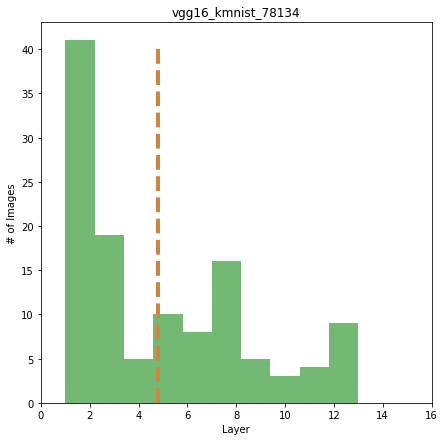

In [69]:
# plot PDs histogram
with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title(expt_name)
plt.ylabel('# of Images')
plt.xlabel('Layer')
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
# plt.ylim((0,80))
plt.hist(batch_info['pd'],bins=10,color='g',alpha=0.55)
pd_mean = np.mean(batch_info['pd'])
plt.vlines(pd_mean,0,40,color='peru',linestyle='dashed',linewidth=4)
# plt.hist(batch_info['pd'][~correct_preds_arr ],bins=100,color='r',alpha=0.55)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [56]:
os.path.join(save_dir,expt_name+'_testPDinfo.pkl')

'/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/toy_expts/output/vgg16_kmnist_78134_testPDinfo.pkl'

In [57]:
expt_name+'_testPDinfo.pkl'

'vgg16_kmnist_78134_testPDinfo.pkl'

## PD Plots Across Runs (Randomized Trials)

In [68]:
model_path = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/toy_expts/output/batch1/vgg16_fmnist_88507.pt'
train_embs_pkl_path = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/toy_expts/output/batch1/vgg16_fmnist_88507.pkl'

model = 'vgg16' # resnet18, vgg16, densenet121
dataset = 'fmnist' # mnist,kmnist
add_patch_flag = False
num_classes = 10   
num_ch=1

In [69]:
if model=='resnet18':
    net = nn.DataParallel(ResNet18(num_channels=num_ch))
elif model=='vgg16':
    net = nn.DataParallel(VGG('VGG16',num_channels=num_ch))
net.load_state_dict(torch.load(model_path)['net'])

<All keys matched successfully>

In [70]:
# adding hook function for resnet18
# def add_resnet18_hooks(net, hook):
#     net.module.bn1.register_forward_hook(hook)
    
#     net.module.layer1[0].bn1.register_forward_hook(hook)
#     net.module.layer1[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer1[1].bn1.register_forward_hook(hook)
#     net.module.layer1[1].shortcut.register_forward_hook(hook)

#     net.module.layer2[0].bn1.register_forward_hook(hook)
#     net.module.layer2[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer2[1].bn1.register_forward_hook(hook)
#     net.module.layer2[1].shortcut.register_forward_hook(hook)
    
#     net.module.layer3[0].bn1.register_forward_hook(hook)
#     net.module.layer3[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer3[1].bn1.register_forward_hook(hook)
#     net.module.layer3[1].shortcut.register_forward_hook(hook)
    
#     net.module.layer4[0].bn1.register_forward_hook(hook)
#     net.module.layer4[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer4[1].bn1.register_forward_hook(hook)
#     net.module.layer4[1].shortcut.register_forward_hook(hook)
        
#     return net

# compute_pd.py

def compute_pred_depth(arr):
    last = arr[-1]

    p_depth = 1
    for i in range(len(arr)-1):
        ele = arr[-1-(i+1)]
        if ele!=last:
            p_depth = (len(arr)-(i+1)) + 1
            break
    
    return p_depth

def add_resnet18_hooks(net, hook):
    net.module.bn1.register_forward_hook(hook)
    
    net.module.layer1[0].conv1.register_forward_hook(hook)
    net.module.layer1[0].conv2.register_forward_hook(hook)
    
    net.module.layer1[1].conv1.register_forward_hook(hook)
    net.module.layer1[1].conv2.register_forward_hook(hook)

    net.module.layer2[0].conv1.register_forward_hook(hook)
    net.module.layer2[0].conv2.register_forward_hook(hook)
    
    net.module.layer2[1].conv1.register_forward_hook(hook)
    net.module.layer2[1].conv2.register_forward_hook(hook)
    
    net.module.layer3[0].conv1.register_forward_hook(hook)
    net.module.layer3[0].conv2.register_forward_hook(hook)
    
    net.module.layer3[1].conv1.register_forward_hook(hook)
    net.module.layer3[1].conv2.register_forward_hook(hook)
    
    net.module.layer4[0].conv1.register_forward_hook(hook)
    net.module.layer4[0].conv2.register_forward_hook(hook)
    
    net.module.layer4[1].conv1.register_forward_hook(hook)
    net.module.layer4[1].conv2.register_forward_hook(hook)
        
    return net

def add_vgg16_hooks(net, hook):
    net.module.features[0].register_forward_hook(hook)
    net.module.features[3].register_forward_hook(hook)
    net.module.features[7].register_forward_hook(hook)
    net.module.features[10].register_forward_hook(hook)
    net.module.features[14].register_forward_hook(hook)
    net.module.features[17].register_forward_hook(hook)
    net.module.features[20].register_forward_hook(hook)
    net.module.features[24].register_forward_hook(hook)
    net.module.features[27].register_forward_hook(hook)
    net.module.features[30].register_forward_hook(hook)
    net.module.features[34].register_forward_hook(hook)
    net.module.features[37].register_forward_hook(hook)
    net.module.features[40].register_forward_hook(hook)        
    return net

def add_densenet121_hooks(net, hook):
    
    for idx,layer in enumerate(net.module.dense1):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense2):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense3):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense4):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    return net
    
    
feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out):
#     out = torch.nn.functional.interpolate(out,(8,8))
#     feature_maps.append(torch.mean(out,dim=[2,3]))
    feature_maps.append(torch.reshape(out, (out.shape[0],-1)))

if model=='resnet18':
    net = add_resnet18_hooks(net, hook_feat_map)
elif model=='vgg16':
    net = add_vgg16_hooks(net, hook_feat_map)
elif model=='densenet121':
    net = add_densenet121_hooks(net, hook_feat_map)
    
    
def to_cpu(arr):
    for idx,x in enumerate(arr):
        arr[idx] = x.to('cpu')
    return arr

def print_memory_profile(s):
    # print GPU memory
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(s)
    print(t/1024**3,r/1024**3,a/1024**3)
    print('\n')

In [71]:
labs = torch.tensor(testset.targets)
perm = torch.randperm(labs.size(0))
inds = perm[:num_test_imgs]
labs = labs[inds]
samples = torch.tensor(testset.data)[inds]

if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    # resize again to 32x32
    samples_resized = torch.empty((0,32,32))
    T = transforms.ToPILImage()
    for img in samples:
        samples_resized = torch.cat((samples_resized,trans(T(img))))
    test_subset = torch.utils.data.TensorDataset(samples_resized,labs)
else:
    test_subset = torch.utils.data.TensorDataset(samples,labs)
testloader2 = torch.utils.data.DataLoader(test_subset, batch_size=128, shuffle=True, num_workers=2)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [72]:
# ===================== Storing Batch Statistics =====================

batch_info = {}
ckpt_path = model_path
batch_info['readme'] = f'---- K={K} ---- ckpt_path={ckpt_path} ---- pkl_path={train_embs_pkl_path} ----'
batch_info['imgs'] = [] # test images
batch_info['preds'] = [] # corresponding model predictions
batch_info['pred_probs'] = [] # corresponding model predictions
batch_info['labels'] = [] # labels of the test images
batch_info['pd'] = [] # corresponding prediction depths
batch_info['layers_knn_prob'] = [] # for each test image we have a list of knn means for every layer
batch_info['layers_knn_mode'] = [] # for each test image we have a list of knn mode for every layer

print_memory_profile('Initial')

Initial
31.7391357421875 0.1328125 0.06749153137207031




In [73]:
# loop over test images
invalid_counter = 0 # for invalid predictions (last layer mode != model output)
data_id = random.sample(range(0, 50000), 200)
for test_id, _ in enumerate(tqdm(trainset)):
    img,lab = trainset[data_id[test_id]]
    if test_id==120:
        break
    if dataset!='mnist':
        img = img.permute([1,2,0])
    batch_info['imgs'].append(img)
    with torch.no_grad():
        to_pil_trans = transforms.ToPILImage()
        if dataset=='mnist':
            img = to_pil_trans(img.to('cuda'))
        else:
            img = to_pil_trans(img.permute(2,0,1).to('cuda'))
        img = trans(img).unsqueeze(0)
        lab = int(lab)
        if img.shape[1]==4:
            img = img[:,0,:,:].unsqueeze(0)
        feature_maps = []
        out = net(img)
        print(f'OUT = {out}')
        print(f'Model output: {out.max()}')
        batch_info['preds'].append(int(out.argmax()))
        batch_info['pred_probs'].append(float(torch.nn.functional.softmax(out).max()))
        batch_info['labels'].append(lab)

        print_memory_profile('Model forward pass')
        with open(train_embs_pkl_path, 'rb') as handle:            
            info_dict = pickle.load(handle)
            print_memory_profile('Pickle load')

            # loop over layers in densenet, and compute KNN for this test image
            knn_preds_mode = []  # layer-wise final KNN classification preds   
            knn_preds_prob = []
            for layer_id,feat in tqdm(enumerate(feature_maps)):
                X_i = feat.unsqueeze(1)  # (10000, 1, 784) test set
                X_j = info_dict['feats'][layer_id].unsqueeze(0)  # (1, 60000, 784) train set
                if lp_norm==2:
                    D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
                elif lp_norm==1:
                    D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
                else:
                    raise('Invalid lp_norm in arguments!')

                ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
                lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]
#                 print(f'!!!!!!test_img:{test_id}, nbrs in layer {layer_id}: {ind_knn[1]}')
                mode = int(lab_knn.squeeze().mode()[0])
                knn_preds_mode.append(mode)
                knn_preds_prob.append(float((lab_knn==mode).float().mean()))

            print_memory_profile('Pickle batch processed')

            # free GPU memory
            del info_dict
            torch.cuda.empty_cache()
            print_memory_profile('After GPU memory freed') 

            print('Test Image: %d' %(test_id))
            print(f'knn_preds_mode: {knn_preds_mode}')
            print(f'knn_preds_prob: {knn_preds_prob}')
            print(f'label: {lab}')
            print(f'pred: {int(out.argmax())}')
            print('\n')
            batch_info['layers_knn_prob'].append(knn_preds_prob)
            batch_info['layers_knn_mode'].append(knn_preds_mode)
            if int(out.argmax())==knn_preds_mode[-1]: # PD accurate
                if knn_pos_thresh==0.5 and knn_neg_thresh==0.5:
                    batch_info['pd'].append(compute_pred_depth(knn_preds_mode))
                else:
                    raise('Code not ready yet! Compute pred arr function also has to be updated!')
            else: # PD inaccurate, KNN pred doesn't match model pred
                print('Invalid datapoint: last_layer_mode != model_output')
                invalid_counter += 1
#                 batch_info['pd'].append(-99)
                if knn_pos_thresh==0.5 and knn_neg_thresh==0.5:
                    batch_info['pd'].append(compute_pred_depth(knn_preds_mode))
                else:
                    raise('Code not ready yet! Compute pred arr function also has to be updated!')
print(f'Invalid Counts Ratio: {invalid_counter}/{num_test_imgs}')

  0%|          | 0/60000 [00:00<?, ?it/s]

OUT = tensor([[ 0.1232, -1.3415,  0.8535,  0.4908,  1.1868, -1.5567,  1.9264, -1.0346,
          0.0388, -0.6811]], device='cuda:0')
Model output: 1.9264276027679443
Model forward pass
31.7391357421875 0.134765625 0.06852149963378906




Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Pickle load
31.7391357421875 1.65234375 1.617136001586914





13it [00:00, 922.29it/s]
  0%|          | 1/60000 [00:03<64:43:11,  3.88s/it]

Pickle batch processed
31.7391357421875 2.38671875 1.6054096221923828


After GPU memory freed
31.7391357421875 0.1015625 0.06823921203613281


Test Image: 0
knn_preds_mode: [9, 8, 7, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.800000011920929, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929]
label: 9
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.4004, -0.4671,  0.5238,  0.4228,  1.3287, -1.1691,  1.6233, -0.8763,
         -0.4278, -0.5525]], device='cuda:0')
Model output: 1.623250961303711
Model forward pass
31.7391357421875 0.123046875 0.06824684143066406


Pickle load
31.7391357421875 1.65234375 1.617136001586914





13it [00:00, 929.97it/s]
  0%|          | 2/60000 [00:06<47:42:09,  2.86s/it]

Pickle batch processed
31.7391357421875 2.38671875 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 1
knn_preds_mode: [2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 7, 8, 9]
knn_preds_prob: [0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.800000011920929, 0.6000000238418579, 1.0, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579]
label: 6
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5011, -0.8373,  0.3375,  0.7317,  0.7808, -1.0688,  1.9222, -0.3030,
         -1.1187, -0.9403]], device='cuda:0')
Model output: 1.9222016334533691
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 775.03it/s]
  0%|          | 3/60000 [00:08<42:00:53,  2.52s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 2
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [0.800000011920929, 1.0, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579, 1.0, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7992, -1.0804,  0.1255,  1.1758,  0.7325, -0.9180,  2.0833, -0.7342,
         -0.4219, -1.7540]], device='cuda:0')
Model output: 2.083300828933716
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 930.40it/s]
  0%|          | 4/60000 [00:10<39:17:49,  2.36s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 3
knn_preds_mode: [3, 3, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [1.0, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.800000011920929, 1.0, 0.800000011920929, 0.6000000238418579, 1.0, 1.0, 0.800000011920929, 0.6000000238418579, 0.800000011920929]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4118, -0.6804,  0.3491,  0.3131,  0.5971, -1.2563,  1.8495, -0.0486,
         -0.4527, -1.0757]], device='cuda:0')
Model output: 1.8494985103607178
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 929.45it/s]
  0%|          | 5/60000 [00:12<37:52:23,  2.27s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 4
knn_preds_mode: [7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.4000000059604645, 1.0, 0.6000000238418579, 1.0, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0]
label: 7
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.8183, -0.5658,  0.1860,  1.2859,  0.6340, -0.7969,  1.9303, -1.1890,
         -0.6498, -1.6458]], device='cuda:0')
Model output: 1.9303390979766846
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 931.40it/s]
  0%|          | 6/60000 [00:14<37:00:58,  2.22s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 5
knn_preds_mode: [3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0]
knn_preds_prob: [0.800000011920929, 1.0, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 0.6000000238418579, 0.6000000238418579, 0.800000011920929]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.0069, -0.9108,  0.6509,  0.8870,  1.1631, -1.9134,  1.7189, -0.9359,
         -0.1232, -0.5383]], device='cuda:0')
Model output: 1.7188663482666016
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 967.77it/s]
  0%|          | 7/60000 [00:16<36:25:49,  2.19s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 6
knn_preds_mode: [5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2]
knn_preds_prob: [0.6000000238418579, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4000000059604645]
label: 9
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5345, -1.2433,  0.1607,  0.1291,  0.4389, -0.7383,  1.7739,  0.1004,
         -0.1868, -0.9624]], device='cuda:0')
Model output: 1.7739086151123047
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 963.08it/s]
  0%|          | 8/60000 [00:18<36:05:18,  2.17s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 7
knn_preds_mode: [7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.6000000238418579, 1.0, 1.0, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 1.0, 1.0, 0.800000011920929, 0.800000011920929, 1.0, 1.0, 0.800000011920929]
label: 7
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.4180, -0.4412,  0.4840,  0.5503,  1.3605, -1.3419,  1.6052, -0.8659,
         -0.3945, -0.5329]], device='cuda:0')
Model output: 1.6052191257476807
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 931.91it/s]
  0%|          | 9/60000 [00:20<35:54:13,  2.15s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 8
knn_preds_mode: [2, 4, 4, 2, 2, 4, 3, 4, 4, 4, 2, 8, 9]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.4000000059604645, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579]
label: 2
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.4817, -0.4814,  0.4537,  0.2458,  1.3544, -1.1363,  1.6335, -0.7548,
         -0.2987, -0.5288]], device='cuda:0')
Model output: 1.6335155963897705
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 929.62it/s]
  0%|          | 10/60000 [00:22<35:47:33,  2.15s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 9
knn_preds_mode: [2, 4, 4, 4, 4, 4, 4, 4, 4, 7, 9, 8, 9]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579]
label: 4
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2414, -2.0182,  0.7612,  0.2493,  1.1049, -1.3584,  2.0209, -0.4650,
          0.3571, -0.8857]], device='cuda:0')
Model output: 2.0208654403686523
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 912.71it/s]
  0%|          | 11/60000 [00:25<35:37:12,  2.14s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 10
knn_preds_mode: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 1.0, 0.800000011920929, 0.800000011920929, 0.800000011920929, 1.0]
label: 8
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4670, -1.0441, -0.0942,  0.1951,  0.5578, -0.6989,  1.8796,  0.1006,
         -0.3389, -1.0177]], device='cuda:0')
Model output: 1.8795979022979736
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 939.15it/s]
  0%|          | 12/60000 [00:27<35:46:13,  2.15s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 11
knn_preds_mode: [7, 8, 7, 6, 5, 7, 7, 7, 7, 7, 7, 0, 0]
knn_preds_prob: [0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 1.0, 1.0, 0.800000011920929, 0.6000000238418579, 1.0, 0.6000000238418579, 0.4000000059604645]
label: 7
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4957, -1.2969,  0.3247,  1.0511,  0.4984, -1.2148,  1.6304, -0.8811,
         -0.0303, -0.5718]], device='cuda:0')
Model output: 1.6303651332855225
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 770.36it/s]
  0%|          | 13/60000 [00:29<35:40:41,  2.14s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 12
knn_preds_mode: [7, 7, 7, 5, 5, 5, 5, 5, 5, 9, 9, 3, 8]
knn_preds_prob: [0.800000011920929, 1.0, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 1.0, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 1.0, 0.6000000238418579, 0.6000000238418579]
label: 5
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7870, -0.9525, -0.0581,  1.1704,  0.5645, -0.9739,  1.9306, -0.6200,
         -0.3791, -1.4613]], device='cuda:0')
Model output: 1.9305741786956787
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 930.29it/s]
  0%|          | 14/60000 [00:31<35:36:44,  2.14s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 13
knn_preds_mode: [3, 0, 0, 6, 3, 3, 6, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 1.0, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 1.0]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7921, -0.8395,  0.0497,  1.2376,  0.6076, -0.9571,  1.9936, -0.5213,
         -0.8469, -1.5085]], device='cuda:0')
Model output: 1.9935598373413086
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 978.62it/s]
  0%|          | 15/60000 [00:33<35:25:42,  2.13s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 14
knn_preds_mode: [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 1.0, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 1.0, 1.0, 0.800000011920929, 0.800000011920929]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4146, -0.8254,  0.3994,  1.1174,  0.6625, -1.3913,  1.7379, -0.4663,
         -1.1658, -0.4784]], device='cuda:0')
Model output: 1.737943172454834
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 910.24it/s]
  0%|          | 16/60000 [00:35<35:22:24,  2.12s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 15
knn_preds_mode: [2, 2, 2, 2, 3, 2, 3, 2, 2, 0, 0, 0, 0]
knn_preds_prob: [0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 1.0, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 1.0, 0.6000000238418579, 1.0]
label: 2
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4224, -1.9628,  0.5772,  0.1620,  0.9347, -1.1460,  1.9850, -0.2764,
          0.2619, -0.9523]], device='cuda:0')
Model output: 1.984978437423706
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 725.50it/s]
  0%|          | 17/60000 [00:37<35:21:31,  2.12s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 16
knn_preds_mode: [7, 8, 8, 8, 7, 5, 7, 7, 7, 7, 8, 8, 8]
knn_preds_prob: [0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 1.0, 1.0, 0.4000000059604645, 0.800000011920929, 1.0, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 0.800000011920929]
label: 8
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.8964, -0.4457,  0.2003,  1.3200,  0.6363, -1.0899,  2.0801, -1.1734,
         -0.6514, -1.7651]], device='cuda:0')
Model output: 2.080054998397827
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 932.45it/s]
  0%|          | 18/60000 [00:39<35:22:59,  2.12s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 17
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0]
knn_preds_prob: [0.800000011920929, 1.0, 0.800000011920929, 0.800000011920929, 1.0, 1.0, 0.800000011920929, 0.6000000238418579, 1.0, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 1.0]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 4.4102e-04, -5.6771e-01,  8.3586e-01,  8.6792e-01,  1.1161e+00,
         -1.4930e+00,  1.6762e+00, -8.8410e-01, -1.1405e+00, -4.0517e-01]],
       device='cuda:0')
Model output: 1.6761631965637207
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 952.39it/s]
  0%|          | 19/60000 [00:42<35:18:44,  2.12s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 18
knn_preds_mode: [3, 3, 3, 6, 3, 3, 1, 1, 9, 9, 9, 9, 9]
knn_preds_prob: [0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.800000011920929]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4249, -0.8524,  0.3178,  0.5682,  0.7138, -0.8291,  1.8605, -0.3368,
         -0.9305, -0.9304]], device='cuda:0')
Model output: 1.8605175018310547
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 935.96it/s]
  0%|          | 20/60000 [00:44<35:18:05,  2.12s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 19
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [1.0, 0.800000011920929, 1.0, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4000000059604645, 0.800000011920929, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7275, -0.7755,  0.1516,  0.9946,  0.6797, -0.9572,  2.0043, -0.4510,
         -1.0438, -1.3236]], device='cuda:0')
Model output: 2.004340887069702
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 939.39it/s]
  0%|          | 21/60000 [00:46<35:21:18,  2.12s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 20
knn_preds_mode: [1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4826, -1.4050,  0.0887,  0.1198,  0.5750, -0.6764,  1.8245,  0.0830,
         -0.1574, -0.9282]], device='cuda:0')
Model output: 1.8244969844818115
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 947.06it/s]
  0%|          | 22/60000 [00:48<35:11:22,  2.11s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 21
knn_preds_mode: [5, 8, 5, 5, 5, 5, 7, 7, 5, 7, 7, 7, 0]
knn_preds_prob: [0.6000000238418579, 1.0, 0.800000011920929, 0.4000000059604645, 1.0, 1.0, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 1.0, 0.6000000238418579, 0.4000000059604645]
label: 7
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.0541, -2.1018,  0.7059,  0.0114,  1.1090, -0.4295,  1.8451, -0.4558,
          0.2785, -1.0114]], device='cuda:0')
Model output: 1.8451058864593506
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 943.81it/s]
  0%|          | 23/60000 [00:50<35:02:03,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 22
knn_preds_mode: [7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 7, 8, 8]
knn_preds_prob: [1.0, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4000000059604645, 1.0, 0.6000000238418579]
label: 5
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.3677, -1.9583,  0.6512,  0.0886,  0.9830, -0.5524,  1.9881, -0.8062,
          0.3803, -1.1350]], device='cuda:0')
Model output: 1.9881479740142822
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 936.87it/s]
  0%|          | 24/60000 [00:52<34:56:19,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 23
knn_preds_mode: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.800000011920929, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.800000011920929, 0.4000000059604645, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 1.0]
label: 8
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.8506, -0.5649,  0.0355,  1.2270,  0.4761, -1.0335,  1.9282, -0.9392,
         -0.3847, -1.5876]], device='cuda:0')
Model output: 1.9281513690948486
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 933.25it/s]
  0%|          | 25/60000 [00:54<34:54:08,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 24
knn_preds_mode: [3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 0]
knn_preds_prob: [1.0, 1.0, 1.0, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 1.0, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.800000011920929]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5863, -0.8280,  0.2426,  0.9495,  0.7336, -1.0814,  1.9134, -0.4001,
         -1.0620, -1.0481]], device='cuda:0')
Model output: 1.9133548736572266
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 947.49it/s]
  0%|          | 26/60000 [00:56<34:54:10,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 25
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.800000011920929, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.3804, -1.1631,  0.1572,  0.0940,  0.5091, -0.7326,  1.7605,  0.1191,
         -0.2570, -0.8614]], device='cuda:0')
Model output: 1.7605230808258057
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 946.24it/s]
  0%|          | 27/60000 [00:58<34:53:34,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 26
knn_preds_mode: [7, 8, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.800000011920929, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 1.0, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579]
label: 7
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.3601, -1.8469,  0.7783,  0.3238,  1.1316, -1.5854,  2.1073, -0.5775,
          0.2993, -0.9845]], device='cuda:0')
Model output: 2.1072561740875244
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 928.62it/s]
  0%|          | 28/60000 [01:00<34:50:47,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 27
knn_preds_mode: [8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [1.0, 0.4000000059604645, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 1.0]
label: 8
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7841, -0.8172,  0.0930,  1.1964,  0.7026, -1.0263,  2.0607, -0.7231,
         -0.5073, -1.7551]], device='cuda:0')
Model output: 2.0607481002807617
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 949.30it/s]
  0%|          | 29/60000 [01:03<34:47:31,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 28
knn_preds_mode: [0, 3, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 1.0, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 0.800000011920929]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7411, -0.7659, -0.0483,  1.1542,  0.5859, -0.9540,  1.9488, -0.6258,
         -0.4412, -1.5869]], device='cuda:0')
Model output: 1.948779582977295
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 929.30it/s]
  0%|          | 30/60000 [01:05<34:51:23,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 29
knn_preds_mode: [3, 3, 0, 6, 3, 3, 3, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 1.0, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.800000011920929]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4886, -0.5924,  0.0538,  1.0865,  0.2390, -0.9751,  1.5819, -0.6844,
         -0.5077, -0.6851]], device='cuda:0')
Model output: 1.5818932056427002
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 933.38it/s]
  0%|          | 31/60000 [01:07<34:50:31,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 30
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 0.800000011920929, 1.0, 1.0, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 1.0, 1.0, 0.6000000238418579]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.2322, -0.5700,  0.5657,  0.6178,  1.1473, -1.5325,  1.6363, -0.7180,
         -0.3602, -0.5485]], device='cuda:0')
Model output: 1.6362755298614502
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 591.54it/s]
  0%|          | 32/60000 [01:09<34:57:51,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 31
knn_preds_mode: [7, 9, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label: 9
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5336, -0.8414,  0.3039,  0.8101,  0.7644, -1.0957,  1.9167, -0.3599,
         -1.1089, -0.9176]], device='cuda:0')
Model output: 1.9166998863220215
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 773.83it/s]
  0%|          | 33/60000 [01:11<34:58:39,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 32
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [0.800000011920929, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 1.0, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.2099, -0.5529,  0.5636,  0.6490,  1.1288, -1.5543,  1.6150, -0.7208,
         -0.3852, -0.5278]], device='cuda:0')
Model output: 1.6149730682373047
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 783.72it/s]
  0%|          | 34/60000 [01:13<34:54:35,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 33
knn_preds_mode: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929]
label: 9
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.0073, -1.6204,  0.7583, -0.0360,  1.1390, -1.3849,  1.9061, -0.5970,
          0.1641, -0.3172]], device='cuda:0')
Model output: 1.90606689453125
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 936.61it/s]
  0%|          | 35/60000 [01:15<35:04:40,  2.11s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 34
knn_preds_mode: [2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2]
knn_preds_prob: [0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 1.0, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.4000000059604645]
label: 6
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.0813, -0.8685,  0.7453,  0.0965,  1.1096, -1.3817,  1.9687, -0.9864,
         -0.1117, -0.6481]], device='cuda:0')
Model output: 1.9687421321868896
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 934.72it/s]
  0%|          | 36/60000 [01:17<35:07:00,  2.11s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 35
knn_preds_mode: [2, 2, 4, 4, 4, 4, 3, 6, 4, 9, 7, 8, 7]
knn_preds_prob: [0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645]
label: 4
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.8320, -0.6652,  0.0483,  1.2245,  0.6393, -1.1403,  2.0731, -0.8093,
         -0.4598, -1.7348]], device='cuda:0')
Model output: 2.073082685470581
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 966.36it/s]
  0%|          | 37/60000 [01:19<35:06:52,  2.11s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 36
knn_preds_mode: [6, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 0.4000000059604645, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 1.0, 1.0, 1.0, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 1.0]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.3883, -0.6569,  0.5299, -0.0737,  1.2373, -1.2449,  1.7331, -0.4421,
         -0.3263, -0.3629]], device='cuda:0')
Model output: 1.7330689430236816
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 894.40it/s]
  0%|          | 38/60000 [01:22<35:08:28,  2.11s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 37
knn_preds_mode: [3, 2, 0, 2, 3, 4, 3, 4, 4, 4, 4, 8, 8]
knn_preds_prob: [0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 1.0, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.4000000059604645]
label: 4
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2629, -1.9808,  0.7157,  0.3665,  1.0015, -1.3156,  1.9109, -0.7335,
          0.2645, -0.4865]], device='cuda:0')
Model output: 1.9109408855438232
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 941.50it/s]
  0%|          | 39/60000 [01:24<35:11:32,  2.11s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 38
knn_preds_mode: [7, 7, 7, 7, 7, 7, 7, 7, 9, 9, 9, 8, 8]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 1.0, 0.800000011920929, 1.0, 0.800000011920929, 1.0, 0.800000011920929, 1.0, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.6000000238418579]
label: 7
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.2631, -0.5676,  0.5757,  0.3687,  1.2751, -1.4032,  1.7769, -0.8823,
         -0.3158, -0.5591]], device='cuda:0')
Model output: 1.7769403457641602
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 920.63it/s]
  0%|          | 40/60000 [01:26<35:12:33,  2.11s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 39
knn_preds_mode: [2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 2, 8, 9]
knn_preds_prob: [0.800000011920929, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579]
label: 2
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.8260, -0.6691, -0.1168,  1.1864,  0.4875, -0.9682,  1.9743, -0.7021,
         -0.3608, -1.6494]], device='cuda:0')
Model output: 1.9742891788482666
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 964.22it/s]
  0%|          | 41/60000 [01:28<35:14:00,  2.12s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 40
knn_preds_mode: [3, 0, 1, 6, 1, 3, 3, 1, 1, 0, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 0.4000000059604645, 0.800000011920929, 0.4000000059604645, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 1.0, 0.6000000238418579, 0.6000000238418579, 1.0, 0.800000011920929, 1.0]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.4768, -0.5459,  0.4081,  0.5443,  1.2541, -1.2435,  1.4986, -0.5053,
         -0.5650, -0.3628]], device='cuda:0')
Model output: 1.4986460208892822
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 931.80it/s]
  0%|          | 42/60000 [01:30<35:13:13,  2.11s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 41
knn_preds_mode: [4, 3, 2, 8, 4, 3, 4, 6, 6, 4, 7, 8, 9]
knn_preds_prob: [0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579]
label: 6
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.8046, -0.9201,  0.0832,  1.1868,  0.6972, -0.9035,  2.0567, -0.8293,
         -0.4094, -1.7581]], device='cuda:0')
Model output: 2.056664228439331
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 934.46it/s]
  0%|          | 43/60000 [01:32<35:17:29,  2.12s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 42
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.6000000238418579, 0.800000011920929]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.8355, -0.7517,  0.0393,  1.2238,  0.6440, -1.1056,  2.0591, -0.7859,
         -0.4183, -1.7325]], device='cuda:0')
Model output: 2.0590689182281494
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 963.82it/s]
  0%|          | 44/60000 [01:34<35:08:55,  2.11s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 43
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 1.0]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.3027, -1.8574,  0.8020,  0.0324,  1.0987, -1.4857,  2.1461, -0.3765,
          0.2789, -0.9352]], device='cuda:0')
Model output: 2.146099805831909
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 963.97it/s]
  0%|          | 45/60000 [01:36<35:00:31,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 44
knn_preds_mode: [8, 8, 8, 8, 8, 7, 7, 7, 8, 8, 8, 8, 8]
knn_preds_prob: [0.800000011920929, 1.0, 1.0, 1.0, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 1.0, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929]
label: 8
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5669, -0.8372,  0.3195,  0.8094,  0.7826, -0.9785,  1.9564, -0.3308,
         -1.1553, -1.1266]], device='cuda:0')
Model output: 1.9563720226287842
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 933.49it/s]
  0%|          | 46/60000 [01:38<34:54:26,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 45
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579, 1.0, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.0719, -0.8189,  0.7151,  0.8081,  1.1622, -1.8323,  1.6725, -0.9034,
         -0.1861, -0.5397]], device='cuda:0')
Model output: 1.6725220680236816
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 953.05it/s]
  0%|          | 47/60000 [01:40<34:54:15,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 46
knn_preds_mode: [7, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579]
label: 9
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7151, -0.6219,  0.1485,  1.1323,  0.7736, -1.1021,  2.1360, -0.6181,
         -0.6181, -1.9364]], device='cuda:0')
Model output: 2.135984182357788
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 946.50it/s]
  0%|          | 48/60000 [01:43<34:51:46,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 47
knn_preds_mode: [1, 3, 3, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 1.0, 0.800000011920929, 0.4000000059604645, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.6678, -0.4757,  0.3635,  0.2116,  1.4200, -1.1511,  1.5373, -0.5235,
         -0.3205, -0.3885]], device='cuda:0')
Model output: 1.5372751951217651
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 951.92it/s]
  0%|          | 49/60000 [01:45<34:49:07,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 48
knn_preds_mode: [6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 9]
knn_preds_prob: [0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579]
label: 4
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2697, -2.0353,  0.8080, -0.0475,  1.0859, -1.3523,  2.1109, -0.3165,
          0.3344, -0.8501]], device='cuda:0')
Model output: 2.110865831375122
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 973.50it/s]
  0%|          | 50/60000 [01:47<34:45:16,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 49
knn_preds_mode: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 1.0, 0.6000000238418579, 1.0, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 0.800000011920929]
label: 8
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.3233, -2.0424,  0.6452,  0.1030,  0.9921, -1.1490,  1.9651, -0.2406,
          0.3479, -0.9386]], device='cuda:0')
Model output: 1.9650721549987793
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 934.34it/s]
  0%|          | 51/60000 [01:49<34:46:24,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 50
knn_preds_mode: [7, 3, 3, 9, 3, 8, 7, 7, 7, 8, 8, 8, 8]
knn_preds_prob: [0.4000000059604645, 0.6000000238418579, 1.0, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.800000011920929]
label: 8
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.6900, -0.8102,  0.2951,  1.2067,  0.7064, -1.5342,  1.7941, -0.8030,
         -0.9764, -0.5637]], device='cuda:0')
Model output: 1.7941310405731201
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 828.45it/s]
  0%|          | 52/60000 [01:51<34:45:45,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 51
knn_preds_mode: [3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 0, 3, 0]
knn_preds_prob: [0.800000011920929, 0.800000011920929, 1.0, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.800000011920929]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.1380, -0.4640,  0.5415,  0.7403,  1.1548, -1.2060,  1.5910, -1.0357,
         -0.5925, -0.5860]], device='cuda:0')
Model output: 1.591005802154541
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 934.22it/s]
  0%|          | 53/60000 [01:53<34:46:29,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 52
knn_preds_mode: [6, 4, 4, 6, 3, 2, 2, 6, 4, 4, 7, 9, 9]
knn_preds_prob: [1.0, 0.4000000059604645, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.800000011920929]
label: 6
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5184, -1.8244,  0.5496,  0.1872,  0.8080, -1.1869,  2.0330, -0.3166,
          0.1993, -0.9618]], device='cuda:0')
Model output: 2.0330159664154053
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 943.05it/s]
  0%|          | 54/60000 [01:55<34:41:56,  2.08s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 53
knn_preds_mode: [3, 0, 3, 3, 3, 3, 3, 3, 5, 8, 8, 8, 8]
knn_preds_prob: [0.4000000059604645, 0.4000000059604645, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 1.0]
label: 8
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5143, -0.7235,  0.2697,  0.6353,  0.6172, -0.8999,  1.8469, -0.5405,
         -0.8383, -0.8764]], device='cuda:0')
Model output: 1.846916675567627
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 866.01it/s]
  0%|          | 55/60000 [01:57<35:12:03,  2.11s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 54
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
knn_preds_prob: [1.0, 0.800000011920929, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579, 0.6000000238418579, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.6007, -0.6475,  0.2020,  1.0548,  0.4640, -1.6702,  1.7566, -0.6410,
         -0.5784, -0.5366]], device='cuda:0')
Model output: 1.7566380500793457
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 974.81it/s]
  0%|          | 56/60000 [01:59<35:53:48,  2.16s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 55
knn_preds_mode: [2, 6, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.4000000059604645, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 1.0, 0.800000011920929, 1.0, 0.800000011920929]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4747, -1.9468,  0.5894,  0.0566,  1.0019, -0.4283,  2.1191, -0.5252,
          0.3304, -1.6631]], device='cuda:0')
Model output: 2.1191365718841553
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 871.84it/s]
  0%|          | 57/60000 [02:02<35:34:04,  2.14s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 56
knn_preds_mode: [7, 8, 5, 6, 5, 5, 5, 5, 5, 5, 8, 8, 8]
knn_preds_prob: [0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.4000000059604645, 0.800000011920929, 0.800000011920929]
label: 5
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7510, -1.4277,  0.1289,  1.0671,  0.7470, -0.8321,  2.1016, -0.5596,
         -0.2154, -1.7529]], device='cuda:0')
Model output: 2.1015844345092773
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 950.29it/s]
  0%|          | 58/60000 [02:04<35:20:34,  2.12s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 57
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 1.0, 1.0, 0.800000011920929, 0.4000000059604645, 0.800000011920929, 0.800000011920929, 1.0, 1.0, 1.0, 0.800000011920929, 0.800000011920929, 0.800000011920929]
label: 6
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4940, -1.1813,  0.2164,  0.0229,  0.6426, -0.4966,  1.8699, -0.1659,
         -0.1181, -1.2764]], device='cuda:0')
Model output: 1.8698837757110596
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 948.69it/s]
  0%|          | 59/60000 [02:06<35:10:04,  2.11s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 58
knn_preds_mode: [9, 9, 9, 9, 5, 5, 5, 5, 5, 5, 0, 0, 0]
knn_preds_prob: [1.0, 1.0, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.800000011920929, 1.0, 1.0, 0.800000011920929, 0.800000011920929, 0.800000011920929]
label: 5
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.6893, -0.8140,  0.3637,  1.0292,  0.8889, -0.9609,  2.1482, -0.6650,
         -1.2454, -1.4269]], device='cuda:0')
Model output: 2.1482133865356445
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 963.48it/s]
  0%|          | 60/60000 [02:08<35:01:07,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 59
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [0.800000011920929, 1.0, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579, 0.6000000238418579, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7032, -0.8335,  0.2569,  1.2247,  0.8457, -0.8347,  2.1413, -0.6865,
         -1.2312, -1.5785]], device='cuda:0')
Model output: 2.1412761211395264
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 955.37it/s]
  0%|          | 61/60000 [02:10<34:54:50,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 60
knn_preds_mode: [3, 8, 3, 6, 3, 4, 1, 3, 5, 0, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 1.0, 0.4000000059604645, 1.0, 0.6000000238418579, 0.800000011920929]
label: 5
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.1125, -0.7533,  0.9473,  1.1578,  1.2005, -1.6259,  1.6763, -0.8096,
         -1.6372, -0.2637]], device='cuda:0')
Model output: 1.676304578781128
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 969.45it/s]
  0%|          | 62/60000 [02:12<34:49:13,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 61
knn_preds_mode: [7, 7, 7, 7, 5, 5, 5, 9, 9, 9, 9, 9, 2]
knn_preds_prob: [0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.4000000059604645, 0.4000000059604645, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 0.4000000059604645]
label: 9
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.8620, -0.7960,  0.1791,  1.3418,  0.7157, -1.0847,  2.0798, -0.7204,
         -0.9972, -1.5728]], device='cuda:0')
Model output: 2.079824686050415
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 780.60it/s]
  0%|          | 63/60000 [02:14<34:54:07,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 62
knn_preds_mode: [3, 0, 0, 3, 3, 0, 3, 3, 3, 3, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 1.0]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.0406, -1.2566,  0.7795,  0.8054,  1.2453, -1.7576,  1.7275, -0.9446,
         -0.0157, -0.5370]], device='cuda:0')
Model output: 1.7274558544158936
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 942.44it/s]
  0%|          | 64/60000 [02:16<34:52:01,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 63
knn_preds_mode: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.6000000238418579, 0.800000011920929, 0.800000011920929, 1.0, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.800000011920929]
label: 9
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5175, -0.7801,  0.3694,  0.7487,  0.7825, -1.1347,  1.9271, -0.5599,
         -0.9689, -0.8967]], device='cuda:0')
Model output: 1.927131175994873
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 939.91it/s]
  0%|          | 65/60000 [02:18<34:48:30,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 64
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579, 1.0, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4821, -0.6913,  0.2255,  0.5834,  0.6038, -0.8645,  1.8249, -0.4129,
         -0.9159, -0.8302]], device='cuda:0')
Model output: 1.8248827457427979
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 885.87it/s]
  0%|          | 66/60000 [02:20<34:55:12,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 65
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [0.800000011920929, 0.6000000238418579, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579, 0.800000011920929, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.0839, -0.4863,  0.8245,  0.8878,  1.1700, -1.8094,  1.6238, -1.0944,
         -0.5816, -0.4455]], device='cuda:0')
Model output: 1.6238477230072021
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 944.14it/s]
  0%|          | 67/60000 [02:22<34:53:11,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 66
knn_preds_mode: [7, 7, 7, 5, 5, 9, 7, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.800000011920929, 0.4000000059604645, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579]
label: 9
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.4143, -0.5173,  0.5174,  0.2247,  1.2656, -1.1901,  1.6325, -0.6307,
         -0.4508, -0.4318]], device='cuda:0')
Model output: 1.632511854171753
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 943.21it/s]
  0%|          | 68/60000 [02:25<34:52:11,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 67
knn_preds_mode: [4, 2, 2, 2, 4, 4, 3, 4, 4, 4, 4, 8, 9]
knn_preds_prob: [0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 1.0, 0.800000011920929, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579]
label: 4
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.8125, -0.9467,  0.1693,  1.0176,  0.4324, -0.9376,  1.9620, -1.0301,
         -0.3985, -1.0745]], device='cuda:0')
Model output: 1.9619851112365723
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 936.87it/s]
  0%|          | 69/60000 [02:27<34:51:54,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 68
knn_preds_mode: [1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 0]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 1.0, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.6000000238418579]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.3126, -1.6119,  0.6206,  0.7961,  1.0090, -1.8727,  1.9119, -0.7997,
          0.0965, -0.4575]], device='cuda:0')
Model output: 1.9118545055389404
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 940.48it/s]
  0%|          | 70/60000 [02:29<34:54:44,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 69
knn_preds_mode: [7, 7, 7, 7, 7, 7, 7, 9, 9, 9, 9, 9, 7]
knn_preds_prob: [0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.800000011920929, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 0.4000000059604645]
label: 9
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2900, -2.1197,  0.4575,  0.1034,  0.8768, -0.4202,  1.8030, -0.2994,
          0.3428, -1.0272]], device='cuda:0')
Model output: 1.8030273914337158
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 945.24it/s]
  0%|          | 71/60000 [02:31<34:49:43,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 70
knn_preds_mode: [7, 8, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.6000000238418579]
label: 5
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.3217, -1.7986,  0.7689,  0.2652,  1.1306, -1.4204,  2.1046, -0.5255,
          0.2382, -1.0790]], device='cuda:0')
Model output: 2.1046297550201416
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 937.63it/s]
  0%|          | 72/60000 [02:33<34:51:13,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 71
knn_preds_mode: [8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.800000011920929, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 1.0, 1.0, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929]
label: 8
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.4232, -0.4635,  0.5223,  0.5397,  1.3961, -1.3550,  1.6580, -0.9334,
         -0.3630, -0.5727]], device='cuda:0')
Model output: 1.6579904556274414
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 946.48it/s]
  0%|          | 73/60000 [02:35<34:51:56,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 72
knn_preds_mode: [2, 4, 2, 2, 8, 2, 3, 2, 2, 4, 2, 8, 9]
knn_preds_prob: [0.800000011920929, 0.6000000238418579, 1.0, 1.0, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.6000000238418579]
label: 2
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5922, -0.6174, -0.0775,  1.1619,  0.1587, -1.0811,  1.5618, -0.5871,
         -0.5347, -0.5717]], device='cuda:0')
Model output: 1.5618104934692383
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 933.55it/s]
  0%|          | 74/60000 [02:37<34:52:23,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 73
knn_preds_mode: [4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
knn_preds_prob: [0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 1.0, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 1.0, 1.0, 0.6000000238418579]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.0662, -1.6243,  0.6848,  0.2996,  1.0056, -0.9027,  1.7748, -0.6387,
         -0.0337, -0.6258]], device='cuda:0')
Model output: 1.7748291492462158
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 981.67it/s]
  0%|          | 75/60000 [02:39<34:49:12,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 74
knn_preds_mode: [2, 4, 2, 2, 3, 4, 4, 6, 6, 4, 2, 8, 7]
knn_preds_prob: [0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645]
label: 6
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7592, -0.7233, -0.3573,  1.0707,  0.2505, -0.7233,  1.7757, -0.3813,
         -0.4008, -1.2634]], device='cuda:0')
Model output: 1.7756922245025635
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 939.08it/s]
  0%|          | 76/60000 [02:41<34:45:23,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 75
knn_preds_mode: [7, 8, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4000000059604645, 1.0, 0.800000011920929, 1.0]
label: 5
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7324, -0.8168,  0.0831,  1.2194,  0.6621, -0.8444,  2.0416, -0.4227,
         -1.1453, -1.5014]], device='cuda:0')
Model output: 2.041585922241211
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 945.88it/s]
  0%|          | 77/60000 [02:43<34:47:23,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 76
knn_preds_mode: [3, 8, 3, 3, 3, 3, 3, 3, 1, 3, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 1.0, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.800000011920929]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7163, -0.7054, -0.1270,  1.1379,  0.3282, -0.7246,  1.7010, -0.5019,
         -0.6771, -1.1412]], device='cuda:0')
Model output: 1.7010233402252197
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 929.02it/s]
  0%|          | 78/60000 [02:46<34:49:20,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 77
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 1.0, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2369, -1.2896,  0.5545,  0.9460,  1.0279, -1.7541,  1.7838, -0.8992,
         -0.0444, -0.5573]], device='cuda:0')
Model output: 1.783815622329712
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 954.44it/s]
  0%|          | 79/60000 [02:48<34:47:45,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 78
knn_preds_mode: [9, 9, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.6000000238418579, 0.800000011920929, 0.6000000238418579, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.6000000238418579]
label: 9
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.8493, -0.5721,  0.1673,  1.2553,  0.6401, -0.8281,  1.9949, -1.1473,
         -0.5433, -1.8086]], device='cuda:0')
Model output: 1.9948806762695312
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 963.88it/s]
  0%|          | 80/60000 [02:50<34:46:05,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 79
knn_preds_mode: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0]
knn_preds_prob: [0.800000011920929, 0.6000000238418579, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7529, -0.7435,  0.0026,  1.1618,  0.6206, -1.0892,  2.0137, -0.5660,
         -0.4695, -1.6754]], device='cuda:0')
Model output: 2.013674736022949
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 969.13it/s]
  0%|          | 81/60000 [02:52<34:44:07,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 80
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5241, -0.8161,  0.3051,  0.8053,  0.7482, -1.1069,  1.9084, -0.4598,
         -0.9815, -0.9216]], device='cuda:0')
Model output: 1.9083919525146484
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 952.39it/s]
  0%|          | 82/60000 [02:54<34:46:12,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 81
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [0.800000011920929, 0.800000011920929, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.800000011920929, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.3227, -1.8413,  0.7633,  0.1955,  1.0891, -1.4578,  2.1084, -0.4174,
          0.2415, -0.9984]], device='cuda:0')
Model output: 2.108391046524048
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 854.32it/s]
  0%|          | 83/60000 [02:56<34:46:48,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 82
knn_preds_mode: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [1.0, 0.6000000238418579, 1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.800000011920929]
label: 8
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7148, -0.7807,  0.2801,  0.9885,  0.7818, -0.9281,  2.0208, -0.6633,
         -1.0394, -1.3673]], device='cuda:0')
Model output: 2.0208163261413574
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 853.58it/s]
  0%|          | 84/60000 [02:58<34:50:20,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 83
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [0.800000011920929, 1.0, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.6000000238418579, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.6113, -0.8099,  0.3057,  0.9588,  1.4934, -1.1736,  1.4352, -0.7290,
         -0.4682, -0.3962]], device='cuda:0')
Model output: 1.4934104681015015
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 806.42it/s]
  0%|          | 85/60000 [03:00<34:46:43,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 84
knn_preds_mode: [3, 4, 0, 3, 4, 4, 3, 3, 4, 9, 3, 3, 9]
knn_preds_prob: [0.4000000059604645, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579]
label: 4
pred: 4


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7663, -0.6376,  0.0264,  1.1815,  0.6347, -1.0941,  2.0295, -0.7981,
         -0.4461, -1.6550]], device='cuda:0')
Model output: 2.0295050144195557
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 948.52it/s]
  0%|          | 86/60000 [03:02<34:45:30,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 85
knn_preds_mode: [1, 0, 6, 6, 1, 3, 3, 3, 0, 0, 0, 0, 0]
knn_preds_prob: [0.4000000059604645, 0.4000000059604645, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.800000011920929, 1.0]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2831, -0.7157,  0.4010,  0.8824,  0.6949, -1.4974,  1.7782, -0.5365,
         -0.7471, -0.5384]], device='cuda:0')
Model output: 1.7781970500946045
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 963.37it/s]
  0%|          | 87/60000 [03:04<34:44:07,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 86
knn_preds_mode: [2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
knn_preds_prob: [1.0, 0.800000011920929, 0.800000011920929, 1.0, 0.800000011920929, 1.0, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.4000000059604645, 0.800000011920929, 0.6000000238418579, 1.0]
label: 2
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.8745, -1.2070,  0.1613,  1.3090,  0.6669, -0.7049,  1.9990, -0.5565,
         -1.0852, -1.4498]], device='cuda:0')
Model output: 1.9989678859710693
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 917.42it/s]
  0%|          | 88/60000 [03:06<34:47:46,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 87
knn_preds_mode: [6, 0, 6, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 1.0, 1.0, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 1.0, 0.800000011920929, 1.0]
label: 6
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4904, -0.7915,  0.3715,  0.7144,  0.7900, -1.0487,  1.8981, -0.4849,
         -1.0321, -0.9022]], device='cuda:0')
Model output: 1.8980581760406494
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 958.39it/s]
  0%|          | 89/60000 [03:08<34:45:27,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 88
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579, 1.0, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.0777, -0.8737,  0.6272,  1.1420,  1.0821, -1.3832,  1.7146, -0.9898,
         -0.8883, -0.5032]], device='cuda:0')
Model output: 1.7145659923553467
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 930.03it/s]
  0%|          | 90/60000 [03:11<34:41:03,  2.08s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 89
knn_preds_mode: [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9]
knn_preds_prob: [0.4000000059604645, 0.4000000059604645, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 1.0, 1.0, 0.800000011920929, 0.6000000238418579, 0.800000011920929]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.1538, -0.7620,  0.8866,  0.4898,  1.3032, -1.6920,  2.1159, -0.6786,
         -1.2568, -0.5542]], device='cuda:0')
Model output: 2.1159491539001465
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 942.92it/s]
  0%|          | 91/60000 [03:13<34:39:49,  2.08s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 90
knn_preds_mode: [3, 3, 3, 1, 1, 1, 1, 1, 1, 5, 5, 2, 4]
knn_preds_prob: [0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 1.0, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645]
label: 4
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.0350, -1.0044,  0.7730,  0.8610,  1.2026, -1.7433,  1.6150, -0.7419,
         -0.6153, -0.3067]], device='cuda:0')
Model output: 1.614980697631836
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 819.96it/s]
  0%|          | 92/60000 [03:15<34:43:05,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 91
knn_preds_mode: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 0.800000011920929]
label: 9
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7520, -0.6330, -0.1945,  1.1815,  0.4006, -1.2551,  1.8418, -0.5496,
         -0.4559, -1.0816]], device='cuda:0')
Model output: 1.8417575359344482
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 943.26it/s]
  0%|          | 93/60000 [03:17<34:43:31,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 92
knn_preds_mode: [1, 3, 3, 3, 1, 1, 3, 0, 3, 0, 0, 0, 0]
knn_preds_prob: [0.4000000059604645, 0.800000011920929, 1.0, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.20000000298023224, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.800000011920929, 1.0]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5463, -0.8922,  0.2696,  0.6701,  0.7214, -0.7931,  1.9127, -0.2180,
         -1.1731, -1.0376]], device='cuda:0')
Model output: 1.9126524925231934
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 875.30it/s]
  0%|          | 94/60000 [03:19<34:44:29,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 93
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [0.800000011920929, 0.6000000238418579, 1.0, 1.0, 0.800000011920929, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579, 0.800000011920929, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4891, -0.8332,  0.3456,  0.6831,  0.7697, -0.8673,  1.8859, -0.5827,
         -1.0001, -0.8854]], device='cuda:0')
Model output: 1.8858850002288818
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 963.22it/s]
  0%|          | 95/60000 [03:21<34:41:44,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 94
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [0.800000011920929, 0.800000011920929, 1.0, 0.800000011920929, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.6000000238418579, 1.0, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5200, -0.8309,  0.2608,  0.7561,  0.7208, -0.9733,  1.9127, -0.2868,
         -1.0000, -1.0734]], device='cuda:0')
Model output: 1.9126884937286377
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 929.57it/s]
  0%|          | 96/60000 [03:23<34:41:18,  2.08s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 95
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [0.800000011920929, 0.800000011920929, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579, 0.800000011920929, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.2602, -0.4645,  0.5922,  0.6278,  1.2481, -1.2669,  1.6193, -0.9514,
         -0.5947, -0.5444]], device='cuda:0')
Model output: 1.6193079948425293
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 940.70it/s]
  0%|          | 97/60000 [03:25<34:42:02,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 96
knn_preds_mode: [2, 6, 2, 4, 6, 4, 4, 4, 4, 4, 2, 8, 9]
knn_preds_prob: [0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579]
label: 4
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.9444, -1.0045, -0.0026,  1.2699,  0.5412, -0.8372,  2.0170, -0.7275,
         -0.5731, -1.6202]], device='cuda:0')
Model output: 2.016964912414551
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





0it [00:00, ?it/s]
13it [00:01, 12.36it/s][A
  0%|          | 98/60000 [03:29<42:10:42,  2.53s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 97
knn_preds_mode: [3, 6, 4, 6, 3, 3, 3, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 1.0, 1.0, 1.0, 0.800000011920929, 1.0]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7252, -0.7263,  0.1112,  0.8297,  0.6345, -0.7090,  2.1024, -0.2367,
         -1.1277, -1.5958]], device='cuda:0')
Model output: 2.1023638248443604
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 939.52it/s]
  0%|          | 99/60000 [03:31<42:25:43,  2.55s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 98
knn_preds_mode: [3, 8, 3, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 1.0, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.800000011920929]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.2379, -0.5016,  0.7152,  0.8527,  1.1926, -1.4913,  1.5662, -0.9438,
         -0.6349, -0.5115]], device='cuda:0')
Model output: 1.5662481784820557
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 933.04it/s]
  0%|          | 100/60000 [03:33<40:14:17,  2.42s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 99
knn_preds_mode: [7, 7, 7, 7, 7, 5, 7, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.800000011920929]
label: 9
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.3017, -0.5312,  0.4517,  0.7778,  1.3439, -1.4101,  1.6760, -0.8777,
         -0.5092, -0.6141]], device='cuda:0')
Model output: 1.6759674549102783
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 930.57it/s]
  0%|          | 101/60000 [03:36<38:43:56,  2.33s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 100
knn_preds_mode: [4, 4, 2, 2, 2, 4, 3, 2, 4, 4, 2, 8, 9]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579]
label: 2
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.3965, -0.5490,  0.5080,  0.8343,  1.3449, -1.5429,  1.5185, -0.7675,
         -0.4635, -0.4805]], device='cuda:0')
Model output: 1.518481731414795
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 904.83it/s]
  0%|          | 102/60000 [03:38<37:40:14,  2.26s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 101
knn_preds_mode: [4, 2, 2, 2, 3, 2, 2, 2, 2, 2, 9, 9, 9]
knn_preds_prob: [0.800000011920929, 0.6000000238418579, 0.4000000059604645, 0.800000011920929, 0.4000000059604645, 0.6000000238418579, 0.4000000059604645, 1.0, 0.800000011920929, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 0.800000011920929]
label: 2
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5111, -0.7727,  0.3575,  0.7597,  0.7714, -1.0138,  1.8960, -0.6849,
         -0.8880, -0.9313]], device='cuda:0')
Model output: 1.8959863185882568
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 940.15it/s]
  0%|          | 103/60000 [03:40<36:54:07,  2.22s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 102
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [0.800000011920929, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579, 1.0, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5314, -1.1463,  0.0993,  0.0221,  0.2867, -0.6563,  1.8410,  0.1398,
         -0.2145, -0.8971]], device='cuda:0')
Model output: 1.8409786224365234
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 923.70it/s]
  0%|          | 104/60000 [03:42<36:21:10,  2.18s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 103
knn_preds_mode: [7, 7, 7, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7]
knn_preds_prob: [0.6000000238418579, 1.0, 0.800000011920929, 0.800000011920929, 1.0, 0.6000000238418579, 1.0, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 0.6000000238418579]
label: 7
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7608, -0.6593, -0.1688,  1.1623,  0.4793, -0.9106,  1.9045, -0.5516,
         -0.4875, -1.5213]], device='cuda:0')
Model output: 1.9044768810272217
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 968.64it/s]
  0%|          | 105/60000 [03:44<36:00:15,  2.16s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 104
knn_preds_mode: [3, 0, 0, 6, 3, 6, 6, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 1.0]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.8315, -0.7732,  0.0059,  1.2102,  0.6132, -1.1120,  2.0481, -0.6571,
         -0.4150, -1.7436]], device='cuda:0')
Model output: 2.048051357269287
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 871.82it/s]
  0%|          | 106/60000 [03:46<35:45:05,  2.15s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 105
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 1.0, 0.6000000238418579, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 1.0]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7418, -0.8117,  0.0438,  1.1493,  0.6474, -0.9331,  2.0060, -0.6680,
         -0.4998, -1.6677]], device='cuda:0')
Model output: 2.0059616565704346
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 949.27it/s]
  0%|          | 107/60000 [03:48<35:33:07,  2.14s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 106
knn_preds_mode: [3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [1.0, 0.800000011920929, 1.0, 0.800000011920929, 0.800000011920929, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 1.0, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 0.800000011920929]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7961, -1.3720, -0.2142,  1.0416,  0.3585, -0.8459,  1.8470, -0.2459,
         -0.1753, -1.1832]], device='cuda:0')
Model output: 1.8470485210418701
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 950.43it/s]
  0%|          | 108/60000 [03:50<35:24:54,  2.13s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 107
knn_preds_mode: [4, 0, 0, 3, 6, 3, 0, 6, 0, 0, 0, 0, 0]
knn_preds_prob: [0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.4000000059604645, 1.0, 1.0, 0.800000011920929, 1.0]
label: 6
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2958, -2.0249,  0.8105, -0.0108,  1.0906, -1.4120,  2.1348, -0.2676,
          0.2973, -0.9076]], device='cuda:0')
Model output: 2.1348400115966797
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 930.87it/s]
  0%|          | 109/60000 [03:52<35:22:36,  2.13s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 108
knn_preds_mode: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
knn_preds_prob: [0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579, 1.0, 0.800000011920929, 0.800000011920929, 0.6000000238418579, 0.800000011920929]
label: 8
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4484, -1.8209,  0.6607,  0.3038,  1.0443, -1.4268,  2.1097, -0.4784,
          0.2289, -1.0635]], device='cuda:0')
Model output: 2.109731435775757
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 883.35it/s]
  0%|          | 110/60000 [03:55<35:17:23,  2.12s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 109
knn_preds_mode: [8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8]
knn_preds_prob: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4000000059604645, 1.0, 0.800000011920929, 0.6000000238418579, 0.800000011920929, 1.0]
label: 8
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.9096, -0.9979,  0.5159,  1.2365,  0.8252, -1.1950,  2.1915, -1.5942,
          0.0164, -1.9005]], device='cuda:0')
Model output: 2.1915130615234375
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 807.13it/s]
  0%|          | 111/60000 [03:57<35:14:03,  2.12s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 110
knn_preds_mode: [5, 8, 5, 6, 5, 5, 5, 3, 3, 8, 3, 0, 0]
knn_preds_prob: [1.0, 1.0, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 0.6000000238418579]
label: 5
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.1066, -0.7818,  0.7996,  1.0189,  1.2627, -1.3757,  1.5725, -0.7819,
         -1.3120, -0.2904]], device='cuda:0')
Model output: 1.572502851486206
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 936.76it/s]
  0%|          | 112/60000 [03:59<35:05:09,  2.11s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 111
knn_preds_mode: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
knn_preds_prob: [0.800000011920929, 0.6000000238418579, 0.800000011920929, 1.0, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 1.0, 1.0, 1.0, 1.0, 0.800000011920929]
label: 9
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4122, -1.1166,  0.3706,  1.1147,  0.8494, -1.5552,  1.8397, -0.9571,
         -0.2745, -0.6785]], device='cuda:0')
Model output: 1.8396739959716797
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 935.70it/s]
  0%|          | 113/60000 [04:01<34:59:22,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 112
knn_preds_mode: [3, 2, 2, 2, 3, 3, 3, 3, 6, 6, 3, 3, 0]
knn_preds_prob: [0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.800000011920929]
label: 6
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.2945, -0.4653,  0.5343,  0.6193,  1.3014, -1.3671,  1.6481, -0.9443,
         -0.4658, -0.5606]], device='cuda:0')
Model output: 1.6481008529663086
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 941.27it/s]
  0%|          | 114/60000 [04:03<34:54:42,  2.10s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 113
knn_preds_mode: [2, 4, 2, 2, 2, 2, 2, 4, 4, 4, 2, 8, 9]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 1.0, 1.0, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.800000011920929, 0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579]
label: 2
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4309, -0.8521,  0.4670,  1.1736,  0.7097, -1.3238,  1.7562, -0.4784,
         -1.5190, -0.3599]], device='cuda:0')
Model output: 1.7561631202697754
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 942.34it/s]
  0%|          | 115/60000 [04:05<34:49:33,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 114
knn_preds_mode: [4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 0.4000000059604645, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579, 1.0, 0.800000011920929, 0.4000000059604645, 0.800000011920929, 0.6000000238418579, 1.0]
label: 2
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5235, -0.7392,  0.3788,  0.7851,  0.7799, -1.1429,  1.9241, -0.6972,
         -0.8532, -0.9542]], device='cuda:0')
Model output: 1.924079418182373
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 946.20it/s]
  0%|          | 116/60000 [04:07<34:50:10,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 115
knn_preds_mode: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 1.0, 1.0, 0.800000011920929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579, 1.0, 1.0]
label: 1
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2098, -2.0044,  0.6362,  0.2498,  0.9325, -1.0948,  1.8400, -0.4401,
          0.2090, -0.5322]], device='cuda:0')
Model output: 1.840000867843628
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 958.98it/s]
  0%|          | 117/60000 [04:09<34:44:27,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 116
knn_preds_mode: [8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8]
knn_preds_prob: [0.800000011920929, 1.0, 1.0, 1.0, 1.0, 0.800000011920929, 1.0, 0.4000000059604645, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929]
label: 8
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7313, -0.7914,  0.0986,  1.2391,  0.5821, -0.8658,  1.7943, -0.9080,
         -0.6794, -1.1945]], device='cuda:0')
Model output: 1.7942712306976318
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 953.22it/s]
  0%|          | 118/60000 [04:11<34:43:20,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 117
knn_preds_mode: [3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 1.0, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 1.0, 1.0, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2977, -1.9695,  0.6602,  0.0870,  0.9979, -1.0648,  1.9669, -0.3309,
          0.3261, -0.9648]], device='cuda:0')
Model output: 1.9668664932250977
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 951.67it/s]
  0%|          | 119/60000 [04:13<34:45:54,  2.09s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 118
knn_preds_mode: [8, 3, 3, 4, 3, 9, 8, 5, 8, 8, 8, 8, 8]
knn_preds_prob: [1.0, 0.6000000238418579, 1.0, 0.4000000059604645, 1.0, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929, 0.800000011920929]
label: 8
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.8267, -0.5908,  0.2543,  1.2597,  0.8275, -1.2297,  2.1878, -1.1629,
         -0.6160, -1.7494]], device='cuda:0')
Model output: 2.1878318786621094
Model forward pass
31.7391357421875 0.115234375 0.06852149963378906


Pickle load
31.7391357421875 1.64453125 1.617410659790039





13it [00:00, 924.23it/s]
  0%|          | 120/60000 [04:15<35:28:45,  2.13s/it]

Pickle batch processed
31.7391357421875 2.37890625 1.6056842803955078


After GPU memory freed
31.7391357421875 0.09375 0.06851387023925781


Test Image: 119
knn_preds_mode: [4, 4, 1, 4, 1, 1, 1, 3, 3, 0, 0, 0, 0]
knn_preds_prob: [0.6000000238418579, 0.6000000238418579, 0.4000000059604645, 0.6000000238418579, 1.0, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.800000011920929, 0.800000011920929, 1.0]
label: 0
pred: 6


Invalid datapoint: last_layer_mode != model_output
Invalid Counts Ratio: 120/100


In [74]:
# ===================== Save results =====================
rnum = int(random.random()*1000)
with open(os.path.join(save_dir,expt_name+f'_testPDinfo{rnum}.pkl'), 'wb') as handle:
    pickle.dump(batch_info, handle)
    

In [ ]:
# plot PDs histogram
with open(os.path.join(save_dir,expt_name+f'_testPDinfo{rnum}.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title(expt_name)
plt.ylabel('# of Images')
plt.xlabel('Layer')
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
plt.ylim((0,80))
plt.hist(batch_info['pd'][batch_info['pd']<8],bins=10,color='g',alpha=0.55)
# plt.hist(batch_info['pd'][~correct_preds_arr ],bins=100,color='r',alpha=0.55)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot2.png'))

In [ ]:
save_dir+expt_name+f'_testPDinfo{rnum}.pkl'

# Viz some Image

In [ ]:
T1 = transforms.ToPILImage()
T2 = transforms.Resize((256,256))
# img = train_subset[100][0]
img = testset.data[100]
T2(T1((img)))

# GradCAM on Intermediate Layers

### Option-1

In [ ]:
# using grad_cam_forward pass

In [ ]:
# load checkpoint
expt_name = 'vgg16_mnist_patch_34272'
net = nn.DataParallel(VGG('VGG16',num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()
layer_id1 = 3 # vgg layer to viz net.module.features[layer_id1]
               # 0,3,7,10,14,17,20,24,27,30,34,37,40
layer_id2 = 1 # info_dict['feats'][layer_id2]
              # 0,1,2,3,4,5,6,7,8,9,10,11,12
img_id = 19

In [ ]:
# add hook to layer you want to viz    
feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out):
    feature_maps.append(torch.reshape(out, (out.shape[0],-1)))
    
net.module.features[layer_id1].register_forward_hook(hook_feat_map)

In [ ]:
# get the nearest K neighbours
K = 29
lp_norm = 1
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')

img = testset.data[img_id]
lab = testset.targets[img_id]

with torch.no_grad():
    # make img compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img = to_pil_trans(img.to('cuda'))
    else:
        img = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img = trans(img).unsqueeze(0)
    if img.shape[1]==4:
        img = img[:,0,:,:].unsqueeze(0)
        
    feature_maps = []
    out = torch.sigmoid(net(img))
    print(f'Model output: {out}')
    
    with open(train_embs_pkl_path, 'rb') as handle:            
        info_dict = pickle.load(handle)

        X_i = feature_maps[0].unsqueeze(1)  # (10000, 1, 784) test set
        X_j = info_dict['feats'][layer_id2].unsqueeze(0)  # (1, 60000, 784) train set
        if lp_norm==2:
            D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
        elif lp_norm==1:
            D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
        else:
            raise('Invalid lp_norm in arguments!')

        ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
        lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]


    # free GPU memory
    del info_dict
    torch.cuda.empty_cache()

In [ ]:
nbr_inds = np.array(ind_knn[1][0].detach().cpu())
nbr_feats = X_j[0,nbr_inds,:].to('cuda')
nbr_labels = lab_knn.squeeze()
s = float(torch.median(-ind_knn[0]).detach().cpu()) # for the median trick


# pre-process the img to make it compatible for forward pass
to_pil_trans = transforms.ToPILImage()
if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    img = to_pil_trans(img.squeeze().to('cuda'))
else:
    img = to_pil_trans(img.permute(2,0,1).to('cuda'))
img = trans(img).unsqueeze(0)
lab = int(lab)
if img.shape[1]==4:
    img = img[:,0,:,:].unsqueeze(0)
feature_maps = []
out, img_feat = net.module.gradcam_forward(img.to('cuda'),nbr_feats,nbr_labels,layer_id1,s)

# show intermediate gradcam
out.backward()

# pull the gradients out of the model
gradients = net.module.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = img_feat.detach()

# weight the channels by corresponding gradients
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze().detach().cpu()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= (torch.max(heatmap)+1e-10)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [ ]:
T1 = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256,256)),
        torchvision.transforms.ToTensor(),
#         torchvision.transforms.Lambda(center_crop()),
        torchvision.transforms.Lambda(lambda x: x.repeat(3,1,1)),
    ])
img = testset.data[img_id]
img = T1(to_pil_trans(img.squeeze()))
   
T2 = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((256,256)),
        torchvision.transforms.ToTensor(),
#         torchvision.transforms.Lambda(center_crop()),
    ])
heatmap = T2(heatmap)

jet = cm.get_cmap('jet')
heatmap2 = jet(heatmap.squeeze())

img2 = torch.cat((img,1.0*torch.ones(256,256).unsqueeze(0)))
plt.figure(figsize=(10,10))
plt.imshow(1.0*img2.permute(1,2,0)+1.0*heatmap2)
# plt.imshow(1.2*img2.permute(1,2,0))

In [ ]:
# 0,3,7,10,14,17,20,24,27,30,34,37,40

### Option-2

In [ ]:
# visualizing the final output, but with different target layers

In [ ]:
# # load checkpoint
# img_id = 18
# img = testset.data[img_id]
# lab = testset.targets[img_id]
# expt_name = 'vgg16_kmnist_patch_48316'
# net = nn.DataParallel(VGG('VGG16',num_channels=1))
# net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
# net.eval()
# layer_id1 = -1 # vgg layer to viz net.module.features[layer_id1]
#                # 0,3,7,10,14,17,20,24,27,30,34,37,40
    


# # pre-process the img to make it compatible for forward pass
# to_pil_trans = transforms.ToPILImage()
# if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
#     img = to_pil_trans(img.squeeze().to('cuda'))
# else:
#     img = to_pil_trans(img.permute(2,0,1).to('cuda'))
# img = trans(img).unsqueeze(0)
# if img.shape[1]==4:
#     img = img[:,0,:,:].unsqueeze(0)
# feature_maps = []
# # out, img_feat = net.module.gradcam_forward(img.to('cuda'),nbr_feats,nbr_labels,layer_id1,s)
# out = net(img.to('cuda'))

# # compute grad cam masks
# targets = [ClassifierOutputTarget(0)]
# target_layers = [net.module.features[layer_id1]]

# # fetch Class Activation Maps (cams)
# cam = EigenCAM(model=net, target_layers=target_layers, use_cuda=True)
# grayscale_cams = cam(input_tensor=img, targets=targets, aug_smooth=True, eigen_smooth=True)

# # overlay cam on original images
# img = img.squeeze().unsqueeze(-1).detach().cpu().numpy()
# cam_op = show_cam_on_image(img, grayscale_cams[0]*0.5, use_rgb=True)
# img_list = []
# img_list.append(cam_op)

# # plot overlays
# plot_images(img_list,1,1)

In [ ]:
# user hyperparams
expt_name = 'vgg16_kmnist_patch_48316'
layer_id1 = 42

# load model
net = nn.DataParallel(VGG('VGG16',num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

# loop over test images
for _ in range(30):
    img_id = int(random.random()*len(testset.data))
    img = testset.data[img_id]
    
    # pre-process the img to make it compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img_tensor = to_pil_trans(img.squeeze().to('cuda'))
    else:
        img_tensor = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img_tensor = trans(img_tensor).unsqueeze(0)
    if img_tensor.shape[1]==4:
        img_tensor = img_tensor[:,0,:,:].unsqueeze(0)
        
    img_rgb = img_tensor.squeeze().unsqueeze(-1).expand(32,32,3)

    # gradCAM code
    targets = [ClassifierOutputTarget(0)]
    target_layers = [net.module.features[layer_id1]]

    cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)
    grayscale_cams = cam(input_tensor=img_tensor, targets=targets, aug_smooth=False, eigen_smooth=True)
    cam_op = show_cam_on_image(np.array(img_rgb), grayscale_cams[0], use_rgb=True)
    
    img_list = []
    img_list.append(img_rgb)
    img_list.append(grayscale_cams[0])
    img_list.append(cam_op)

    # plot results
    plot_images(img_list,rows=1,cols=3,titles=['Original Img','Heat Map','Overlay'])

### Option-3 SHAP (on final outputs)

In [ ]:
# user hyperparams
expt_name = 'vgg16_kmnist_27437'

# load model
net = nn.DataParallel(VGG('VGG16',num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

batch = next(iter(testloader))
images, _ = batch

shap_train_imgs = images[:10].to('cuda')
shap_test_imgs = images[10:14].to('cuda')

e = shap.DeepExplainer(net, shap_train_imgs)
shap_values = e.shap_values(shap_test_imgs)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(shap_test_imgs.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy, width=100.0)

In [ ]:
net(shap_test_imgs).shape, len(shap_values), shap_values[0].shape

In [ ]:
for x in shap_train_imgs:
    print(x.unsqueeze(0).shape)

### Option-3 SHAP (on custom intermediate soft-KNN output)

In [ ]:
# user hyperparams
expt_name = 'vgg16_kmnist_27437'
layer_id = 0 # vgg layer to viz net.module.features[layer_id]
               # 0,3,7,10,14,17,20,24,27,30,34,37,40
train_emb_idx = 0 # info_dict['feats'][train_emb_idx]
              # 0,1,2,3,4,5,6,7,8,9,10,11,12

# load model
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')
net = nn.DataParallel(customVGG2('VGG16', train_embs_pkl_path, layer_id, train_emb_idx, num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

# load batch of images
batch = next(iter(testloader))
images, _ = batch

# prepare shap train and test images
shap_train_imgs = images[:100].to('cuda')
shap_test_imgs = images[100:102].to('cuda')

e = shap.DeepExplainer(net, shap_train_imgs)
shap_values = e.shap_values(test_img)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_img.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy, width=100.0)

### Option-4
Using grad-cam for intermediate layers as described in:
https://jacobgil.github.io/pytorch-gradcam-book/Pixel%20Attribution%20for%20embeddings.html

In [ ]:
# ===========user hyper-params==================
expt_name = 'vgg16_mnist_patch_34272'
net = nn.DataParallel(customVGG('VGG16',num_channels=1))
img_id = 5
layer_id1 = 0 # vgg layer to viz net.module.features[layer_id1]
               # 0,3,7,10,14,17,20,24,27,30,34,37,40
layer_id2 = 0 # info_dict['feats'][layer_id2]
              # 0,1,2,3,4,5,6,7,8,9,10,11,12
# =============================

In [ ]:
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()
# add hook to layer you want to viz    
feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out):
    feature_maps.append(torch.reshape(out, (out.shape[0],-1)))
    
net.module.features[layer_id1].register_forward_hook(hook_feat_map)

# get the nearest K neighbours
K = 29
lp_norm = 1
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')

img = testset.data[img_id]
lab = testset.targets[img_id]

with torch.no_grad():
    # make img compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img = to_pil_trans(img.to('cuda'))
    else:
        img = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img = trans(img).unsqueeze(0)
    if img.shape[1]==4:
        img = img[:,0,:,:].unsqueeze(0)
        
    feature_maps = []
    out = torch.sigmoid(net.module.simpleForward(img.to('cuda')))
    print(f'Model output: {out}')
    
    with open(train_embs_pkl_path, 'rb') as handle:            
        info_dict = pickle.load(handle)

        X_i = feature_maps[0].unsqueeze(1)  # (10000, 1, 784) test set
        X_j = info_dict['feats'][layer_id2].unsqueeze(0)  # (1, 60000, 784) train set
        if lp_norm==2:
            D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
        elif lp_norm==1:
            D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
        else:
            raise('Invalid lp_norm in arguments!')

        ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
        lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]


    # free GPU memory
    del info_dict
    torch.cuda.empty_cache()

In [ ]:
nbr_inds = np.array(ind_knn[1][0].detach().cpu())
nbr_feats = X_j[0,nbr_inds,:].to('cuda')
nbr_labels = lab_knn.squeeze()
s = float(torch.median(-ind_knn[0]).detach().cpu()) # for the median trick

net.module.nbr_feats = nbr_feats
net.module.nbr_labels = nbr_labels
net.module.s = s
net.module.layer_id = layer_id1

In [ ]:
# pre-process the img to make it compatible for forward pass
to_pil_trans = transforms.ToPILImage()
if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    img = to_pil_trans(img.squeeze().to('cuda'))
else:
    img = to_pil_trans(img.permute(2,0,1).to('cuda'))
img = trans(img).unsqueeze(0)
if img.shape[1]==4:
    img = img[:,0,:,:].unsqueeze(0)

# compute grad cam masks
targets = [ClassifierOutputTarget(0)]
target_layers = [net.module.features[layer_id1]]

# fetch Class Activation Maps (cams)
cam = GradCAMPlusPlus(model=net, target_layers=target_layers, use_cuda=True)
grayscale_cams = cam(input_tensor=img, targets=targets, aug_smooth=False, eigen_smooth=True)

# overlay cam on original images
img = img.squeeze().unsqueeze(-1).detach().cpu().numpy()
cam_op = show_cam_on_image(img, grayscale_cams[0], use_rgb=True)
img_list = []
img_list.append(img)
img_list.append(grayscale_cams[0])
img_list.append(cam_op)

# plot overlays
plot_images(img_list,rows=1,cols=3)

In [ ]:
# code in loop
expt_name = 'vgg16_mnist_patch_34272'
net = nn.DataParallel(customVGG('VGG16',num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()
for _ in range(1000):
    # ===========user hyper-params==================
    img_id = int(random.random()*len(testset.data))
    layer_id1 = 40 # vgg layer to viz net.module.features[layer_id1]
                   # 0,3,7,10,14,17,20,24,27,30,34,37,40
    layer_id2 = 12 # info_dict['feats'][layer_id2]
                  # 0,1,2,3,4,5,6,7,8,9,10,11,12
    # =============================
    # add hook to layer you want to viz    
    feature_maps = []  # This will be a list of Tensors, each representing a feature map
    def hook_feat_map(mod, inp, out):
        feature_maps.append(torch.reshape(out, (out.shape[0],-1)))

    net.module.features[layer_id1].register_forward_hook(hook_feat_map)

    # get the nearest K neighbours
    K = 29
    lp_norm = 1
    train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')

    img = testset.data[img_id]
    lab = testset.targets[img_id]

    with torch.no_grad():
        # make img compatible for forward pass
        to_pil_trans = transforms.ToPILImage()
        if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
            img = to_pil_trans(img.to('cuda'))
        else:
            img = to_pil_trans(img.permute(2,0,1).to('cuda'))
        img = trans(img).unsqueeze(0)
        if img.shape[1]==4:
            img = img[:,0,:,:].unsqueeze(0)

        feature_maps = []
        out = torch.sigmoid(net.module.simpleForward(img.to('cuda')))
        print(f'Model output: {out}')

        with open(train_embs_pkl_path, 'rb') as handle:            
            info_dict = pickle.load(handle)

            X_i = feature_maps[0].unsqueeze(1)  # (10000, 1, 784) test set
            X_j = info_dict['feats'][layer_id2].unsqueeze(0)  # (1, 60000, 784) train set
            if lp_norm==2:
                D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
            elif lp_norm==1:
                D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
            else:
                raise('Invalid lp_norm in arguments!')

            ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
            lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]


        # free GPU memory
        del info_dict
        torch.cuda.empty_cache()

    nbr_inds = np.array(ind_knn[1][0].detach().cpu())
    nbr_feats = X_j[0,nbr_inds,:].to('cuda')
    nbr_labels = lab_knn.squeeze()
    s = float(torch.median(-ind_knn[0]).detach().cpu()) # for the median trick

    net.module.nbr_feats = nbr_feats
    net.module.nbr_labels = nbr_labels
    net.module.s = s
    net.module.layer_id = layer_id1

    # pre-process the img to make it compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img = to_pil_trans(img.squeeze().to('cuda'))
    else:
        img = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img = trans(img).unsqueeze(0)
    if img.shape[1]==4:
        img = img[:,0,:,:].unsqueeze(0)

    # compute grad cam masks
    targets = [ClassifierOutputTarget(0)]
    target_layers = [net.module.features[layer_id1]]

    # fetch Class Activation Maps (cams)
    cam = GradCAMPlusPlus(model=net, target_layers=target_layers, use_cuda=True)
    grayscale_cams = cam(input_tensor=img, targets=targets, aug_smooth=False, eigen_smooth=True)

    # overlay cam on original images
    img = img.squeeze().unsqueeze(-1).detach().cpu().numpy()
    cam_op = show_cam_on_image(img, grayscale_cams[0], use_rgb=True)
    img_list = []
    img_list.append(img)
    img_list.append(grayscale_cams[0])
    img_list.append(cam_op)

    # plot overlays
    plot_images(img_list,rows=1,cols=3,titles=['Original Img','Heat Map','Overlay'])

# Re-Train Only Initial Layers on Randomized Labels

In [ ]:
# user hyperparams
expt_name = 'vgg16_kmnist_patch_48316'
num_ch = 1

In [ ]:
net = nn.DataParallel(VGG('VGG16',num_channels=num_ch))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
for i in range(10,45,1):
    for param in net.module.features[i].parameters():
        param.requires_grad = False
for param in net.module.classifier.parameters():
        param.requires_grad = False

In [ ]:
# sanity checking if all gradients false except initial layers
for param in net.module.parameters():
    print(param.requires_grad)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
net = net.to(device)
    
if device == 'cuda':
    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch, randomize_labels=False):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        if randomize_labels:
            targets = targets[torch.randperm(targets.shape[0])] # randomize labels
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))


In [ ]:
train(2,randomize_labels=True)
test(2)
scheduler.step()

print('Saving..')
state = {
    'net': net.state_dict(),
    'epoch': 2,
}
#         if not os.path.isdir(f'{args['expt_name']}_checkpoint'):
#             os.mkdir('checkpoint')
torch.save(state, os.path.join(save_dir,f'{expt_name}_a.pt'))

# Re-Train Only Final Layers on True Labels

In [ ]:
# freeze initial layers
for param in net.parameters():
    param.requires_grad = True

for i in range(0,10,1):
    for param in net.module.features[i].parameters():
        param.requires_grad = False

In [ ]:
# sanity checking if all gradients false except initial layers
for param in net.module.parameters():
    print(param.requires_grad)

In [ ]:
epoch = 3
train(epoch,randomize_labels=False)
test(epoch)
scheduler.step()

print('Saving..')
state = {
    'net': net.state_dict(),
    'epoch': epoch,
}
#         if not os.path.isdir(f'{args['expt_name']}_checkpoint'):
#             os.mkdir('checkpoint')
torch.save(state, os.path.join(save_dir,f'{expt_name}_b.pt'))

# Misc

In [ ]:
expt_name = 'vgg16_mnist_75872'

In [ ]:
# plot PDs histogram

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title('MNIST', fontsize=25)
plt.ylabel('No. of Images', fontsize=25)
plt.xlabel('VGG16 Layers', fontsize=25)
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
plt.ylim((0,80))
plt.hist(batch_info['pd'][correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='g',alpha=0.55)
plt.hist(batch_info['pd'][~correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='r',alpha=0.55)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [ ]:
expt_name = 'vgg16_fmnist_88507'

In [ ]:
# plot PDs histogram

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title('FMNIST', fontsize=25)
plt.ylabel('No. of Images', fontsize=25)
plt.xlabel('VGG16 Layers', fontsize=25)
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
plt.ylim((0,80))
plt.hist(batch_info['pd'][correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='g',alpha=0.55)
plt.hist(batch_info['pd'][~correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='r',alpha=0.55)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [ ]:
expt_name = 'vgg16_cifar10_18394'

In [ ]:
# plot PDs histogram

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title('CIFAR10', fontsize=25)
plt.ylabel('No. of Images', fontsize=25)
plt.xlabel('VGG16 Layers', fontsize=25)
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
plt.ylim((0,80))
plt.hist(batch_info['pd'],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='g',alpha=0.55)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [ ]:
expt_name = 'vgg16_kmnist_27437'

In [ ]:
# plot PDs histogram

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title('KMNIST w/o patch', fontsize=25)
plt.ylabel('No. of Images', fontsize=25)
plt.xlabel('VGG16 Layers', fontsize=25)
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
plt.ylim((0,80))
plt.hist(batch_info['pd'][correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='g',alpha=0.55)
plt.hist(batch_info['pd'][~correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='r',alpha=0.55)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [ ]:
df = pd.read_csv('/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/mimic/full/train.csv')
df[df['pneumothorax']==0]

In [ ]:
212023/7977

In [ ]:
# loop over test images
invalid_counter = 0 # for invalid predictions (last layer mode != model output)
loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
for test_id, (img,lab) in enumerate(tqdm(loader)):

    batch_info['imgs'].append(img)
    img, lab = img.to(device), lab.to(device)
    with torch.no_grad():
        # lab = int(lab)
        feature_maps = []
        out = net(img)
        print(f'OUT = {out}')
        print(f'Model output: {out.max()}')
        batch_info['preds'].append(int(out.argmax()))
        batch_info['pred_probs'].append(float(torch.nn.functional.softmax(out).max()))
        batch_info['labels'].append(lab)

        print_memory_profile('Model forward pass')
        with open(train_embs_pkl_path, 'rb') as handle:            
            info_dict = pickle.load(handle)
            print_memory_profile('Pickle load')

            # loop over layers in densenet, and compute KNN for this test image
            knn_preds_mode = []  # layer-wise final KNN classification preds   
            knn_preds_prob = []
            for layer_id,feat in tqdm(enumerate(feature_maps)):
                X_i = feat.unsqueeze(1)  # (10000, 1, 784) test set
                X_j = info_dict['feats'][layer_id].unsqueeze(0)  # (1, 60000, 784) train set
                if lp_norm==2:
                    D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
                elif lp_norm==1:
                    D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
                else:
                    raise('Invalid lp_norm in arguments!')

                ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
                lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]
#                 print(f'!!!!!!test_img:{test_id}, nbrs in layer {layer_id}: {ind_knn[1]}')
                mode = int(lab_knn.squeeze().mode()[0])
                knn_preds_mode.append(mode)
                knn_preds_prob.append(float((lab_knn==mode).float().mean()))

            print_memory_profile('Pickle batch processed')

            # free GPU memory
            del info_dict
            torch.cuda.empty_cache()
            print_memory_profile('After GPU memory freed') 

            print('Test Image: %d' %(test_id))
            print(f'knn_preds_mode: {knn_preds_mode}')
            print(f'knn_preds_prob: {knn_preds_prob}')
            print(f'label: {lab}')
            print(f'pred: {int(out.argmax())}')
            print('\n')
            batch_info['layers_knn_prob'].append(knn_preds_prob)
            batch_info['layers_knn_mode'].append(knn_preds_mode)
            if int(out.argmax())==knn_preds_mode[-1]: # PD accurate
                if knn_pos_thresh==0.5 and knn_neg_thresh==0.5:
                    batch_info['pd'].append(compute_pred_depth(knn_preds_mode))
                else:
                    raise('Code not ready yet! Compute pred arr function also has to be updated!')
            else: # PD inaccurate, KNN pred doesn't match model pred
                print('Invalid datapoint: last_layer_mode != model_output')
                invalid_counter += 1
                batch_info['pd'].append(-99)
print(f'Invalid Counts Ratio: {invalid_counter}/{num_test_imgs}')